# Our paper to be submitted to the eLife journal

In [1]:
from IPython import display
import matplotlib.colors as colors
from collections import Counter

import time 
import numpy as np 

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
zero_one_scaler = MinMaxScaler()

from sklearn.decomposition import PCA as PCA
from sklearn.manifold import TSNE as TSNE
from sklearn.manifold import Isomap as ISOMAP
from sklearn.manifold import LocallyLinearEmbedding as LLE
from sklearn.manifold import MDS
from sklearn.cluster import KMeans

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import average, fcluster
from scipy.spatial.distance import pdist
from scipy.special import comb
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import umap

from scipy.spatial.distance import cdist as cdist

### Tensorflow packages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

### PyTorch packages
import torch
import torch.nn as nn
from torch.autograd import Variable

import warnings
warnings.filterwarnings('ignore')

def to_var(x):
    return Variable(x)

def traintestsplit_r(X_in,y_in,trainfrac):
    NX = X_in.shape[0]
    X_all_ind = np.linspace(0,NX-1,num=NX)
    X_train_ind = np.random.choice(NX,size=np.ceil(trainfrac*NX).astype(int),replace=False)
    X_test_ind = np.isin(X_all_ind,X_train_ind,invert=True)
    X_train = X_in[X_train_ind,:] # Randomly select samples for training
    y_train = y_in[X_train_ind]
    X_test = X_in[X_test_ind,:]
    y_test = y_in[X_test_ind]

# Combine all training data and all testing data
    return [X_train, X_test, y_train, y_test]

def traintestsplit_c(X_in,y_in,trainfrac):
    C = np.unique(y_in).shape[0] # Find number of classes in y
    
    X = dict()
    y = dict()
    NX = dict()
    X_all_ind = dict()
    X_train = dict()
    X_train_ind = dict()
    X_test = dict()
    X_test_ind = dict()
    y_train = dict()
    y_test = dict()
    
    for c in range(0,C):
        X[c] = X_in[(y_in == c),:]
        y[c] = y_in[(y_in == c)]
        NX[c] = X[c].shape[0]
        X_all_ind[c] = np.linspace(0,NX[c]-1,num=NX[c])
        X_train_ind[c] = np.random.choice(NX[c],size=np.ceil(trainfrac*NX[c]).astype(int),replace=False)
        X_train[c] = X[c][X_train_ind[c],:] # Randomly select samples from Class c for training
        X_test_ind[c] = np.isin(X_all_ind[c],X_train_ind[c],invert=True)
        X_test[c] = X[c][X_test_ind[c],:]
        y_train[c] = y[c][X_train_ind[c]]
        y_test[c] = y[c][X_test_ind[c]]
        
    # Combine all training data and all testing data
    X_train_all = np.array([]).reshape(0,X_train[0].shape[1])
    X_test_all = np.array([]).reshape(0,X_test[0].shape[1])
    y_train_all = np.array([]).reshape(0,)
    y_test_all = np.array([]).reshape(0,)
    for c in range(0,C):
        X_train_ADD = X_train[c]
        X_test_ADD = X_test[c]
        y_train_ADD = y_train[c]
        y_test_ADD = y_test[c]
        
        X_train_all = np.concatenate((X_train_all,X_train_ADD))
        X_test_all = np.concatenate((X_test_all,X_test_ADD))
        y_train_all = np.concatenate((y_train_all,y_train_ADD))
        y_test_all = np.concatenate((y_test_all,y_test_ADD))
    
    return [X_train_all, X_test_all, y_train_all, y_test_all, X_train_ind, X_test_ind]

def custom_scale(X_1,X_base):
    scaler = StandardScaler()
    scaler.fit(X_base)
    X_custom_scaled = scaler.transform(X_1)
    
    return X_custom_scaled

### Make windows
def make_windows(X_vec,Y_vec,NT,d,window_size,steps_ahead):
    """
   Make windows created a windows matrix so the neural network can observe past values 
   This function workswith a Y_vec
   X_vec = X matrix of input variables
   Y_vec = Target variable
   NT = number of samples of the X matrix 
   d = number of variables in the X matrix
   window size = number of past values included forthe model
   steps_ahead = how far you want to look forward into the future
   returns a windowed X matrix, a corrected output vector, and the newsize of the output vector
    """ 
    num_windows = NT-window_size+1-steps_ahead

    X_images = np.zeros((num_windows,window_size,d))
    y_images = np.zeros((num_windows,1))
    X_extra_images = np.zeros((steps_ahead,window_size,d))

    for i in range(0,num_windows):
        X_images[i,:,:] = X_vec[i:(i+window_size),:]
        y_images[i] = Y_vec[i+window_size-1+steps_ahead]
    
    for i in range(num_windows,num_windows+steps_ahead):
        X_extra_images[i-num_windows,:,:] = X_vec[i:(i+window_size),:]

    return X_images, y_images, X_extra_images

## Train test split for 4d arrays:

def traintestsplit_c_4d(X_in,y_in,trainfrac):
    C = np.unique(y_in).shape[0] # Find number of classes in y
    
    X = dict()
    y = dict()
    NX = dict()
    X_all_ind = dict()
    X_train = dict()
    X_train_ind = dict()
    X_test = dict()
    X_test_ind = dict()
    y_train = dict()
    y_test = dict()
    
    for c in range(0,C):
        X[c] = X_in[(y_in == c),:,:,:]
        y[c] = y_in[(y_in == c)]
        NX[c] = X[c].shape[0]
        X_all_ind[c] = np.linspace(0,NX[c]-1,num=NX[c])
        X_train_ind[c] = np.random.choice(NX[c],size=np.ceil(trainfrac*NX[c]).astype(int),replace=False)
        X_train[c] = X[c][X_train_ind[c],:] # Randomly select samples from Class c for training
        X_test_ind[c] = np.isin(X_all_ind[c],X_train_ind[c],invert=True)
        X_test[c] = X[c][X_test_ind[c],:]
        y_train[c] = y[c][X_train_ind[c]]
        y_test[c] = y[c][X_test_ind[c]]
        
    # Combine all training data and all testing data
    X_train_all = np.array([]).reshape(0,X_train[0].shape[1],X_train[0].shape[2],X_train[0].shape[3])
    X_test_all = np.array([]).reshape(0,X_test[0].shape[1],X_test[0].shape[2],X_test[0].shape[3])
    y_train_all = np.array([]).reshape(0,)
    y_test_all = np.array([]).reshape(0,)
    for c in range(0,C):
        X_train_ADD = X_train[c]
        X_test_ADD = X_test[c]
        y_train_ADD = y_train[c]
        y_test_ADD = y_test[c]

        X_train_all = np.concatenate((X_train_all,X_train_ADD))
        X_test_all = np.concatenate((X_test_all,X_test_ADD))
        y_train_all = np.concatenate((y_train_all,y_train_ADD))
        y_test_all = np.concatenate((y_test_all,y_test_ADD))

    return [X_train_all, X_test_all, y_train_all, y_test_all]

def relu(x):
    return torch.max(torch.zeros(1,1),x) # Assuming x is already in torch format

def relu_numpy(x):
    return np.max(np.zeros(1,1),x) # Assuming x is in numpy format

def find_shortest_indices(aa,bb):

    cc = cdist(aa,bb,metric='euclidean')
    row_numb = ( np.argmin(cc) ) // bb.shape[0] + 1
    row_numb_numpy = row_numb - 1

    mod_ans = (np.argmin(cc)+1 ) % bb.shape[0]
    if mod_ans == 0:
        col_numb = bb.shape[0]
    else:
        col_numb = mod_ans

    col_numb_numpy = col_numb - 1
    
    ## row_numb_numpy = element to pick in aa 
    ## col_numb_numpy = element to pick in bb
    
    return [row_numb_numpy,col_numb_numpy]

# Task 0: Data Import and Pre-Processing

**March 22 Note:** Ask Dr. Geng and Vikash about the minor differences in patient names???

In [2]:
df_raw = pd.read_excel("March_21_2022_All_Patients.xlsx")
df_raw_labels = pd.read_excel("March_21_2022_Patient_Labels.xlsx",skiprows=[0])

protein_IDs = df_raw['Accession'].values

patient_IDs = df_raw_labels["Monogram"].values
patient_labels = df_raw_labels["SSc AB"].values

df_raw_patients = df_raw.loc[:,"VALA Area":"ANRA Area"]

### Sanity check: Do any of these patients have missing protein abundance counts?
print(df_raw_patients.isna().sum())
print("")

### Log transformation of values: Add one to all values, then take log base 10
df_raw_patients_log10 = np.log10(df_raw_patients + 1)

### Normalize ALL values in the protein matrix
df_patients_scaled = pd.DataFrame(MinMaxScaler().fit_transform(df_raw_patients_log10),columns=df_raw_patients_log10.columns)

### Sanity check to ensure normalization was performed properly
print(df_patients_scaled.min())
print("")
print(df_patients_scaled.max())

VALA Area     0
MASH Area     0
DEARS Area    0
MEAS Area     0
PARS Area     0
GEES Area     0
SHRI Area     0
IASA Area     0
KAOH Area     0
ANRA Area     0
dtype: int64

VALA Area     0.0
MASH Area     0.0
DEARS Area    0.0
MEAS Area     0.0
PARS Area     0.0
GEES Area     0.0
SHRI Area     0.0
IASA Area     0.0
KAOH Area     0.0
ANRA Area     0.0
dtype: float64

VALA Area     1.0
MASH Area     1.0
DEARS Area    1.0
MEAS Area     1.0
PARS Area     1.0
GEES Area     1.0
SHRI Area     1.0
IASA Area     1.0
KAOH Area     1.0
ANRA Area     1.0
dtype: float64


## 0.1: Distributions of raw and scaled data

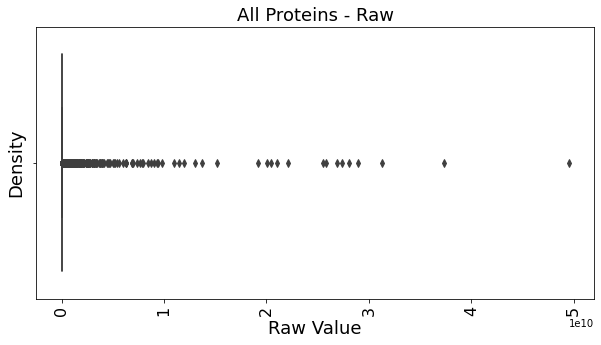

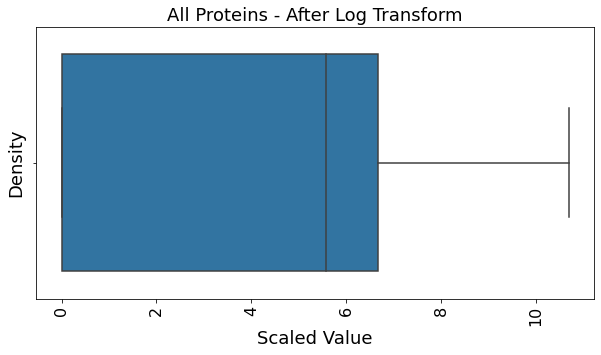

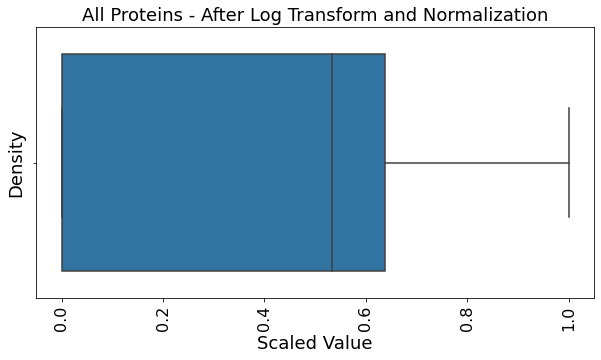

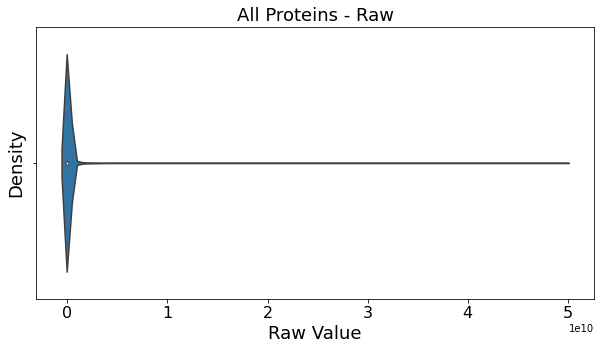

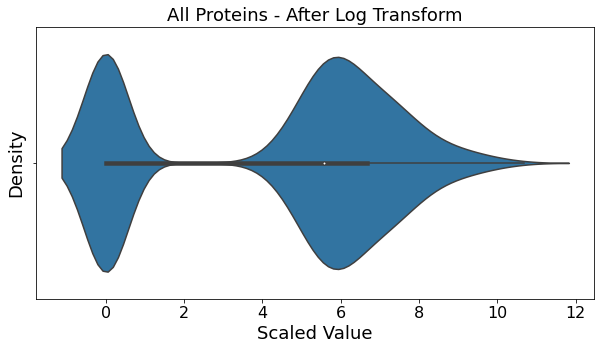

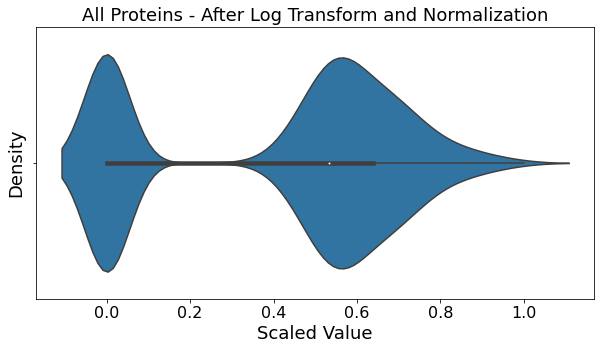

In [3]:
### Box Plots
plt.figure(figsize=(10,5))
sns.boxplot(df_raw_patients.values)
plt.xlabel("Raw Value",fontsize=18)
plt.xticks(fontsize=16,rotation=90)
plt.ylabel("Density",fontsize=18)
plt.yticks(fontsize=16)
plt.title("All Proteins - Raw",fontsize=18)
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(df_raw_patients_log10.values)
plt.xlabel("Scaled Value",fontsize=18)
plt.xticks(fontsize=16,rotation=90)
plt.ylabel("Density",fontsize=18)
plt.yticks(fontsize=16)
plt.title("All Proteins - After Log Transform",fontsize=18)
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(df_patients_scaled.values)
plt.xlabel("Scaled Value",fontsize=18)
plt.xticks(fontsize=16,rotation=90)
plt.ylabel("Density",fontsize=18)
plt.yticks(fontsize=16)
plt.title("All Proteins - After Log Transform and Normalization",fontsize=18)
plt.show()

### Violin Plots
plt.figure(figsize=(10,5))
sns.violinplot(df_raw_patients.values)
plt.xlabel("Raw Value",fontsize=18)
plt.xticks(fontsize=16,rotation=0)
plt.ylabel("Density",fontsize=18)
plt.yticks(fontsize=16)
plt.title("All Proteins - Raw",fontsize=18)
plt.show()

plt.figure(figsize=(10,5))
sns.violinplot(df_raw_patients_log10.values)
plt.xlabel("Scaled Value",fontsize=18)
plt.xticks(fontsize=16,rotation=0)
plt.ylabel("Density",fontsize=18)
plt.yticks(fontsize=16)
plt.title("All Proteins - After Log Transform",fontsize=18)
plt.show()

plt.figure(figsize=(10,5))
sns.violinplot(df_patients_scaled.values)
plt.xlabel("Scaled Value",fontsize=18)
plt.xticks(fontsize=16,rotation=0)
plt.ylabel("Density",fontsize=18)
plt.yticks(fontsize=16)
plt.title("All Proteins - After Log Transform and Normalization",fontsize=18)
plt.show()

In [4]:
np.max(df_patients_scaled)

VALA Area     1.0
MASH Area     1.0
DEARS Area    1.0
MEAS Area     1.0
PARS Area     1.0
GEES Area     1.0
SHRI Area     1.0
IASA Area     1.0
KAOH Area     1.0
ANRA Area     1.0
dtype: float64

### Finally, transform patient types into numerical class labels

- Class $0$: ACA+
- Class $1$: SCL70+

In [5]:
N = df_patients_scaled.shape[1]
d = df_patients_scaled.shape[0]

X_scaled = df_patients_scaled.values.T
y_labels = np.zeros((N,))

for i in range(0,N):
    if patient_labels[i] == 'Scl70+':
        y_labels[i] = 1
        
y_labels = y_labels.astype(int)
C = np.unique(y_labels).shape[0]
print(patient_labels)
print(y_labels)

['Scl70+' 'ACA+' 'Scl70+' 'ACA+' 'Scl70+' 'Scl70+' 'ACA+' 'ACA+' 'Scl70+'
 'ACA+']
[1 0 1 0 1 1 0 0 1 0]


# Task 1: Supervised Learning Using All Proteins

## 1.1 Random Forests (RFs)

In [6]:
num_experiments = 100

conf_matrix_dict = {}
RF_train_acc_array = []
RF_test_acc_array = []
RF_importances_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(X_scaled,y_labels,trainfrac)

    RF_model = RFC(random_state=0)
    RF_model.fit(X_train_all, y_train_all)
    RF_importances_array.append(RF_model.feature_importances_)

    y_train_hat = RF_model.predict(X_train_all)
    RF_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    RF_train_acc_array.append(RF_train_acc)

    y_test_hat = RF_model.predict(X_test_all)
    RF_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    RF_test_acc_array.append(RF_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)
    
    print("Experiment {} now complete.".format(i))

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

### Report accuracies.

Average training accuracy is 100.00%.
Maximum training accuracy is 100.00%.
Minimum training accuracy is 100.00%.
Average testing accuracy is 69.50%.
Maximum testing accuracy is 100.00%.
Minimum testing accuracy is 0.00%.


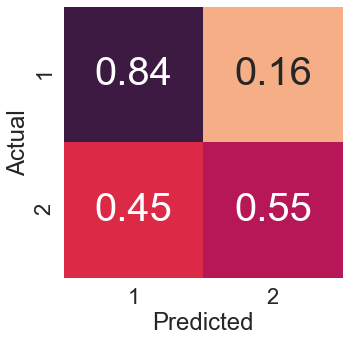

In [7]:
print("Average training accuracy is {:.2f}%.".format(np.mean(RF_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(RF_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(RF_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(RF_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(RF_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(RF_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_RF = np.zeros((C,C))
for i in range(0,conf_matrix_RF.shape[0]):
    conf_matrix_RF[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_RF = pd.DataFrame(conf_matrix_RF, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_RF, cbar=False, annot=True, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

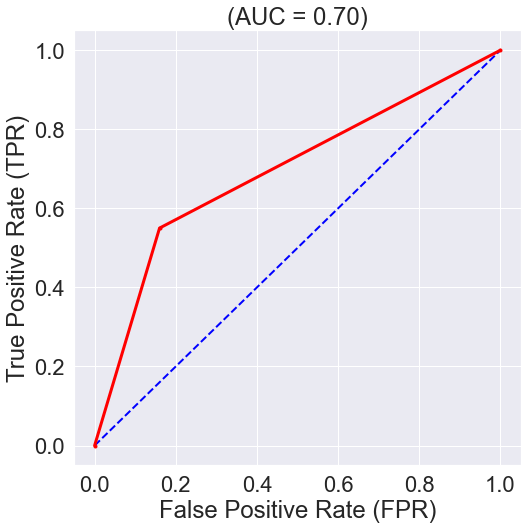

In [8]:
%matplotlib inline

TP = conf_matrix_RF[1,1]
FN = conf_matrix_RF[1,0]
FP = conf_matrix_RF[0,1]
TN = conf_matrix_RF[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='RF Model')
plt.title('(AUC = {:.2f})'.format(AUC))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

### Feature Extraction

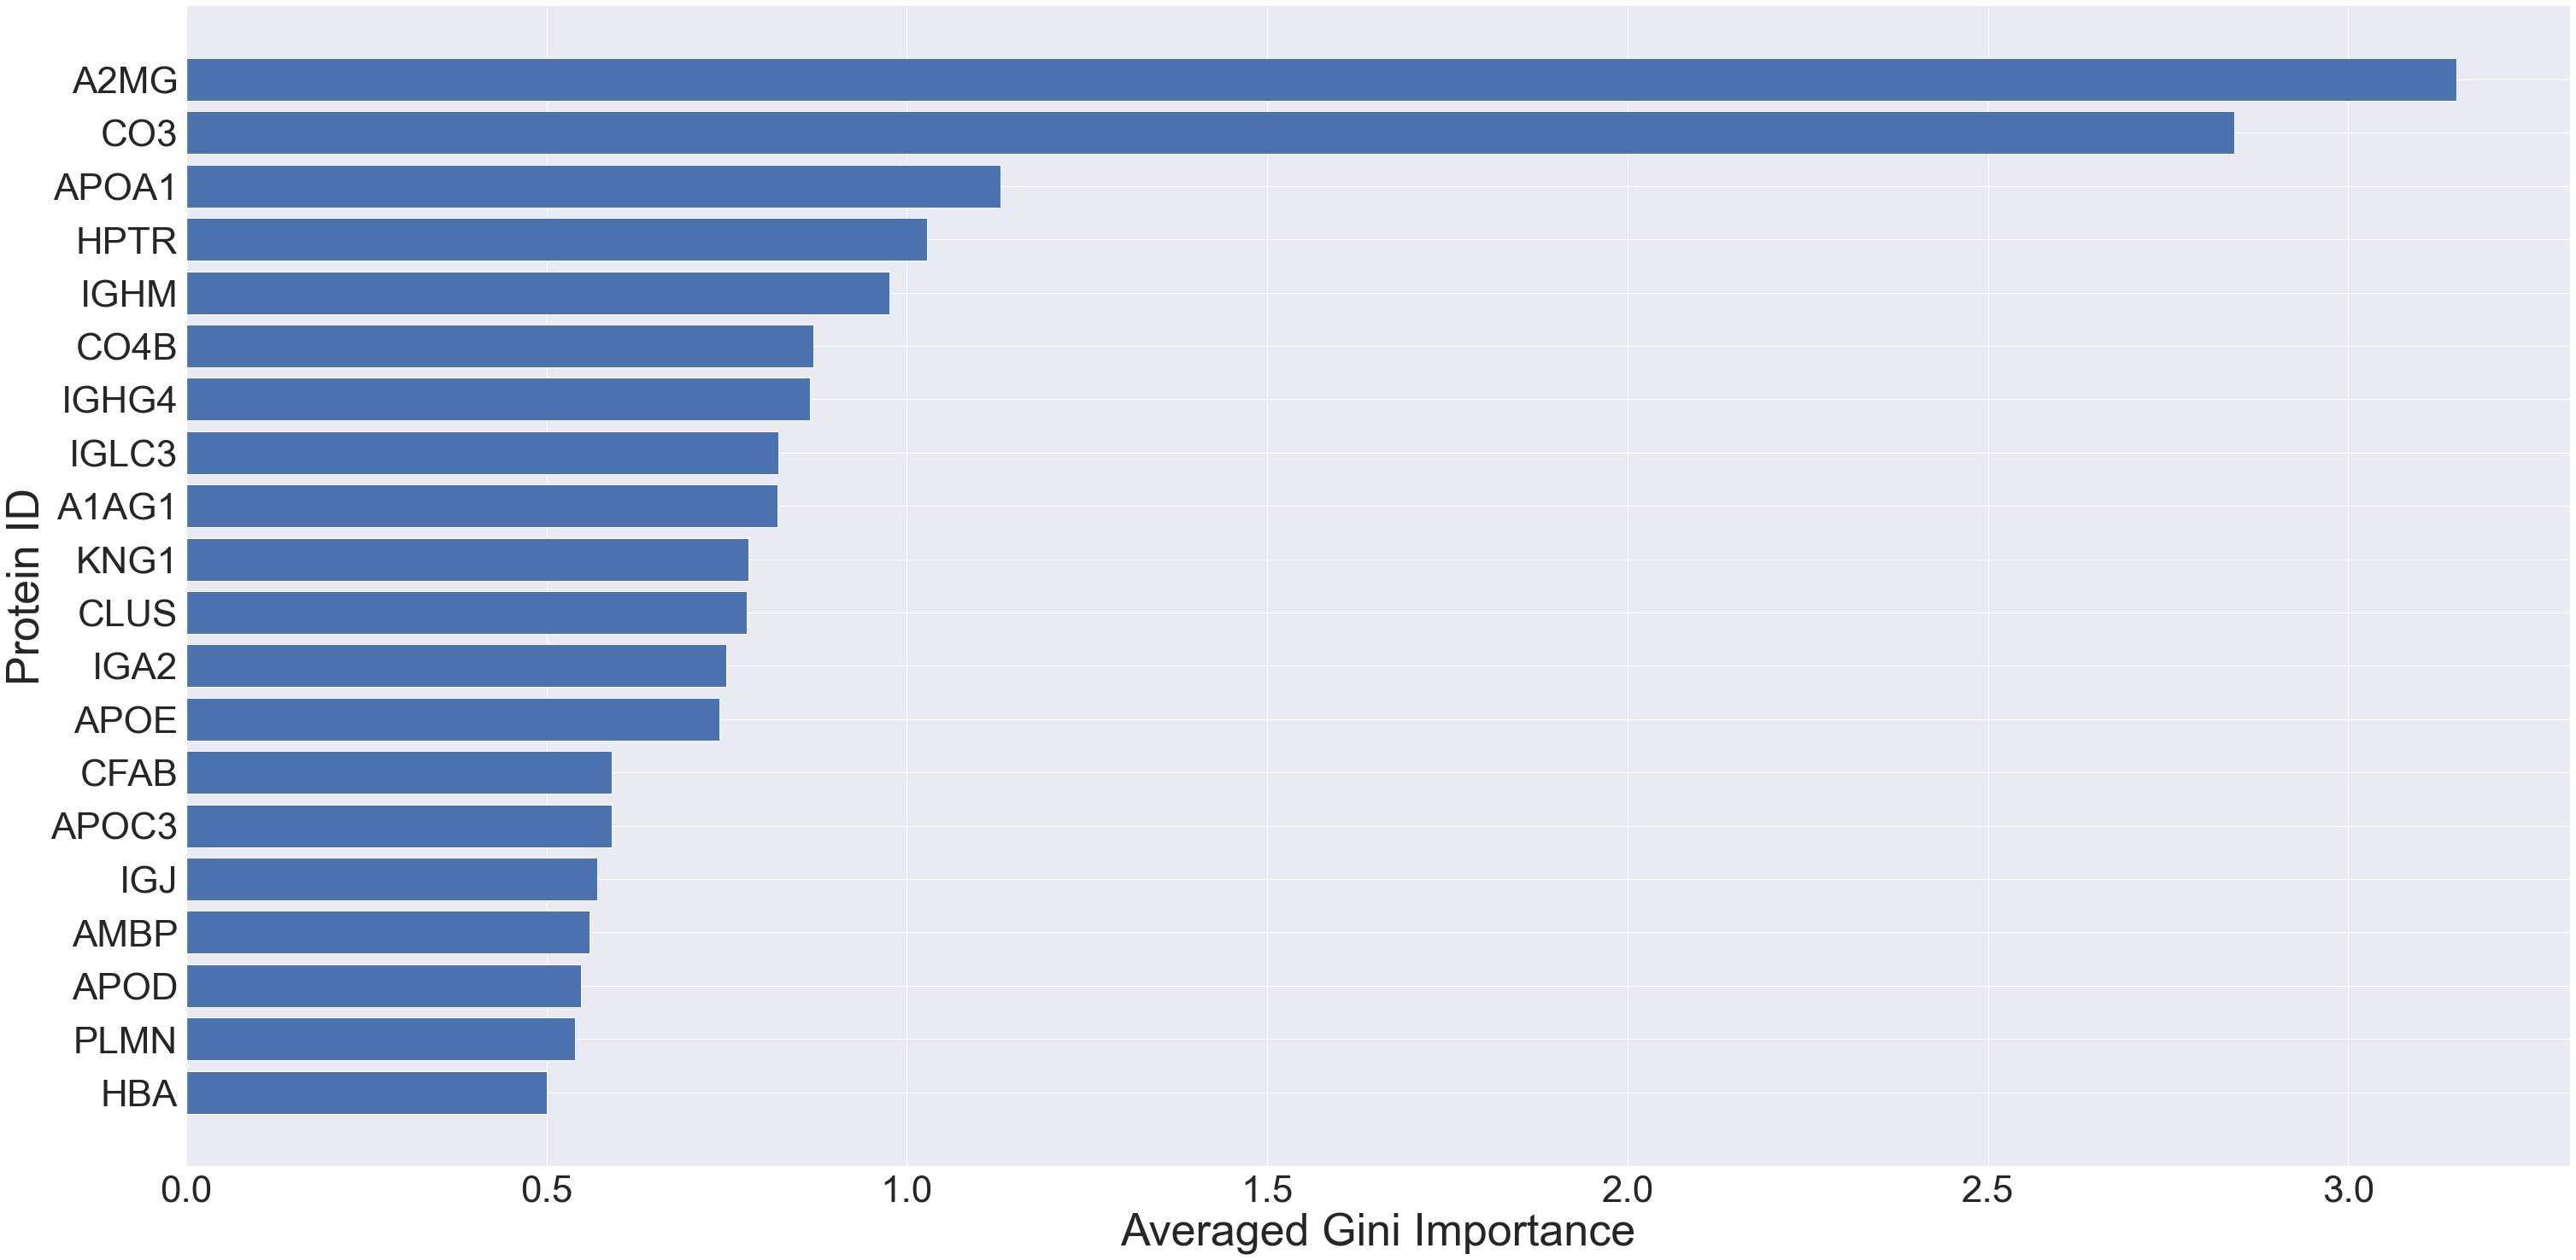

Time required to perform RFE: 46 sec


array(['P12259|FA5_HUMAN', 'P51884|LUM_HUMAN', 'P02765|FETUA_HUMAN',
       'P01876|IGHA1_HUMAN', 'A0A0C4DH25|KVD20_HUMAN',
       'P55290|CAD13_HUMAN', 'P00734|THRB_HUMAN', 'P03952|KLKB1_HUMAN',
       'P01008|ANT3_HUMAN', 'P01614|KVD40_HUMAN', 'Q9ULI3|HEG1_HUMAN',
       'P02774|VTDB_HUMAN', 'P00450|CERU_HUMAN', 'P08779|K1C16_HUMAN',
       'Q12802|AKP13_HUMAN', 'Q8IWI9|MGAP_HUMAN', 'P12111|CO6A3_HUMAN',
       'Q9Y267|S22AE_HUMAN', 'Q92922|SMRC1_HUMAN', 'P67936|TPM4_HUMAN'],
      dtype=object)

In [9]:
## Feature Selection via MDG
num_top = 20
sorted_indices_array = []
sorted_importances_array = []

for i in range(0,num_experiments):
    sorted_indices_array.append(np.argsort(-RF_importances_array[i])[0:num_top])
    sorted_importances_array.append(-np.sort(-RF_importances_array[i])[0:num_top])
    
sorted_indices_array = np.array(sorted_indices_array)
sorted_importances_array = np.array(sorted_importances_array)

unique_indices = np.unique(sorted_indices_array)
unique_importances = np.zeros((unique_indices.shape[0],))

for ii in range(0,unique_indices.shape[0]):
    unique_importances[ii] = np.sum(sorted_importances_array[sorted_indices_array == unique_indices[ii]])
    
final_importances = -np.sort(-unique_importances)[0:num_top]
final_indices = unique_indices[np.argsort(-unique_importances)[0:num_top]]

RF_biomarkers_MDG = protein_IDs[unique_indices]
RF_biomarkers_MDG_plot = []
for s in RF_biomarkers_MDG:
    start = s.find("|") + len("|")
    end = s.find("_")
    RF_biomarkers_MDG_plot.append(s[start:end])

plt.figure(figsize = (50,25))
y_ticks = np.arange(num_top,0,-1)
plt.barh(y_ticks, final_importances)
plt.yticks(y_ticks,RF_biomarkers_MDG_plot,fontsize=44)
plt.ylabel("Protein ID",fontsize=52)
plt.xticks(fontsize=44)
plt.xlabel("Averaged Gini Importance",fontsize=52)
#plt.title("Random Forests - MDG Importances",fontsize=40)
plt.show()

## Feature Selection via RFE
RF_model_RFE = RFC(random_state=0, n_estimators=100)
[X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(X_scaled,y_labels,trainfrac)

time_start = time.time()

## Feature Importances
RFE_selector = RFE(RF_model_RFE, n_features_to_select=num_top, step=1)
RFE_selector = RFE_selector.fit(X_train_all, y_train_all)
time_end = time.time()

print("Time required to perform RFE: {:.0f} sec".format(time_end-time_start))

## Print the top features
RF_RFE_ranking = RFE_selector.ranking_
RF_biomarkers_RFE = protein_IDs[RF_RFE_ranking == 1]
RF_biomarkers_RFE

## 1.2 Support Vector Machines (SVMs)

In [10]:
num_experiments = 100

conf_matrix_dict = {}
SVM_train_acc_array = []
SVM_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(X_scaled,y_labels,trainfrac)
    
    SVM_model = svm.SVC(decision_function_shape='ovr',gamma='auto', random_state=0)
    SVM_model.fit(X_train_all, y_train_all)

    y_train_hat = SVM_model.predict(X_train_all)
    SVM_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    SVM_train_acc_array.append(SVM_train_acc)

    y_test_hat = SVM_model.predict(X_test_all)
    SVM_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    SVM_test_acc_array.append(SVM_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)
        
    print("Experiment {} now complete.".format(i))

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

### Report accuracies.

Average training accuracy is 98.12%.
Maximum training accuracy is 100.00%.
Minimum training accuracy is 87.50%.
Average testing accuracy is 46.50%.
Maximum testing accuracy is 50.00%.
Minimum testing accuracy is 0.00%.


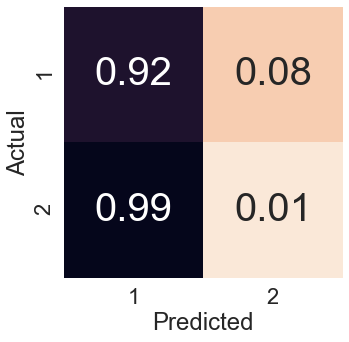

In [11]:
print("Average training accuracy is {:.2f}%.".format(np.mean(SVM_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(SVM_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(SVM_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(SVM_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(SVM_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(SVM_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_SVM = np.zeros((C,C))
for i in range(0,conf_matrix_SVM.shape[0]):
    conf_matrix_SVM[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_SVM = pd.DataFrame(conf_matrix_SVM, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_SVM, annot=True, cbar=False, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

Text(0.5, 1.0, '(AUC = 0.47)')

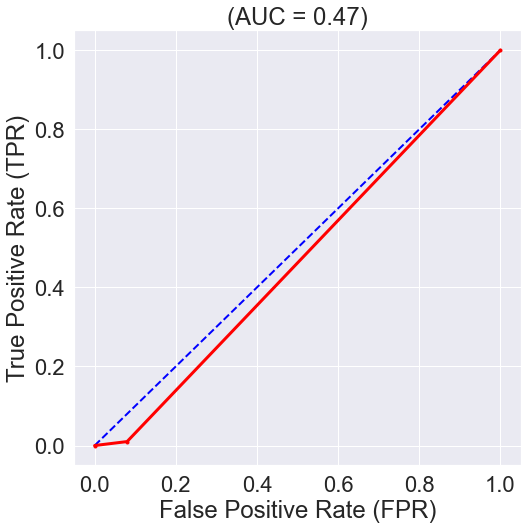

In [12]:
%matplotlib inline

TP = conf_matrix_SVM[1,1]
FN = conf_matrix_SVM[1,0]
FP = conf_matrix_SVM[0,1]
TN = conf_matrix_SVM[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='SVM Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('(AUC = {:.2f})'.format(AUC))

### Feature Extraction

In [13]:
SVM_model_RFE = svm.SVC(decision_function_shape='ovr',gamma='auto', random_state=0)
[X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(X_scaled,y_labels,trainfrac)

## Feature Importances
time_start = time.time()

SVM_model_RFE = svm.SVC(kernel='linear',decision_function_shape='ovr',gamma='auto', random_state=0)
RFE_selector_SVM = RFE(SVM_model_RFE, n_features_to_select=num_top, step=1)
RFE_selector_SVM.fit(X_train_all, y_train_all)
time_end = time.time()

print("Time required to perform RFE: {:.0f} sec".format(time_end-time_start))

## Print the top features
SVM_importance_ranking = RFE_selector_SVM.ranking_
SVM_biomarkers_RFE = protein_IDs[SVM_importance_ranking == 1]
SVM_biomarkers_RFE

Time required to perform RFE: 0 sec


array(['P37802|TAGL2_HUMAN', 'Q9ULI3|HEG1_HUMAN', 'P02679|FIBG_HUMAN',
       'A0A0B4J1Y9|HV372_HUMAN', 'Q04756|HGFA_HUMAN',
       'P35609|ACTN2_HUMAN', 'P01266|THYG_HUMAN', 'Q99758|ABCA3_HUMAN',
       'Q9NU22|MDN1_HUMAN', 'A0A075B6I9|LV746_HUMAN',
       'Q96M86|DNHD1_HUMAN', 'Q13201|MMRN1_HUMAN', 'Q9Y267|S22AE_HUMAN',
       'Q92922|SMRC1_HUMAN', 'A0A0C4DH67|KV108_HUMAN',
       'Q7LG56|RIR2B_HUMAN', 'Q7Z6I6|RHG30_HUMAN', 'P13473|LAMP2_HUMAN',
       'Q8NDY6|BHE23_HUMAN', 'O60488|ACSL4_HUMAN'], dtype=object)

## 1.3 Supervised Learning Using Extracted Features

### 1.3.1 Random Forests Using Extracted Features

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

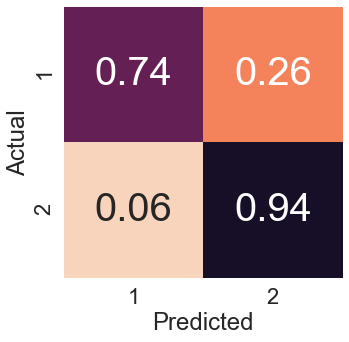

Text(0.5, 1.0, '(AUC = 0.84)')

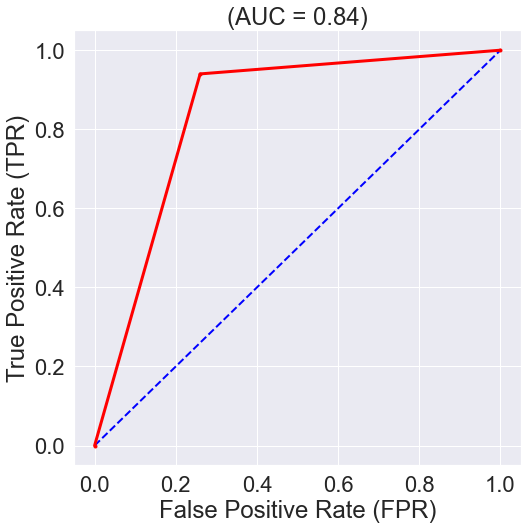

In [14]:
RF_biomarkers_indices = []

for jj in range(0,num_top):
    RF_biomarkers_indices.append(np.arange(0,d,1)[protein_IDs == RF_biomarkers_MDG[jj]].reshape(-1))

RF_biomarkers_indices = np.array(RF_biomarkers_indices).reshape(-1)

X_biomarkers = X_scaled[:,RF_biomarkers_indices]

num_experiments = 100

conf_matrix_dict = {}
RF_train_acc_array = []
RF_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(X_biomarkers,y_labels,trainfrac)

    RF_model = RFC(random_state=0)
    RF_model.fit(X_train_all, y_train_all)

    y_train_hat = RF_model.predict(X_train_all)
    RF_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    RF_train_acc_array.append(RF_train_acc)

    y_test_hat = RF_model.predict(X_test_all)
    RF_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    RF_test_acc_array.append(RF_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)
    
    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(RF_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(RF_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(RF_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(RF_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(RF_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(RF_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_RF = np.zeros((C,C))
for i in range(0,conf_matrix_RF.shape[0]):
    conf_matrix_RF[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_RF = pd.DataFrame(conf_matrix_RF, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_RF, cbar=False, annot=True, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_RF[1,1]
FN = conf_matrix_RF[1,0]
FP = conf_matrix_RF[0,1]
TN = conf_matrix_RF[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='RF Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('(AUC = {:.2f})'.format(AUC))

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

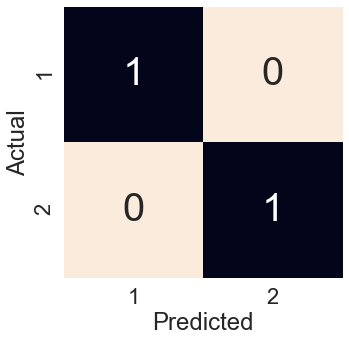

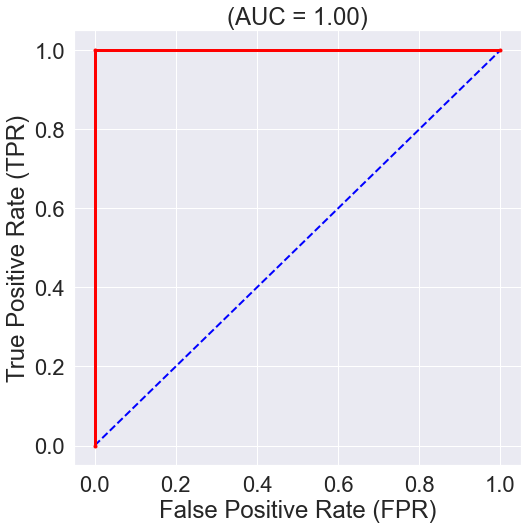

In [15]:
RF_biomarkers_indices = []

for jj in range(0,num_top):
    RF_biomarkers_indices.append(np.arange(0,d,1)[protein_IDs == RF_biomarkers_RFE[jj]].reshape(-1))

RF_biomarkers_indices = np.array(RF_biomarkers_indices).reshape(-1)

X_biomarkers = X_scaled[:,RF_biomarkers_indices]

num_experiments = 100

conf_matrix_dict = {}
RF_train_acc_array = []
RF_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(X_biomarkers,y_labels,trainfrac)

    RF_model = RFC(random_state=0)
    RF_model.fit(X_train_all, y_train_all)

    y_train_hat = RF_model.predict(X_train_all)
    RF_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    RF_train_acc_array.append(RF_train_acc)

    y_test_hat = RF_model.predict(X_test_all)
    RF_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    RF_test_acc_array.append(RF_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)
    
    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(RF_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(RF_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(RF_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(RF_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(RF_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(RF_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_RF = np.zeros((C,C))
for i in range(0,conf_matrix_RF.shape[0]):
    conf_matrix_RF[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_RF = pd.DataFrame(conf_matrix_RF, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_RF, cbar=False, annot=True, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_RF[1,1]
FN = conf_matrix_RF[1,0]
FP = conf_matrix_RF[0,1]
TN = conf_matrix_RF[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='RF Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('(AUC = {:.2f})'.format(AUC))
plt.show()

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

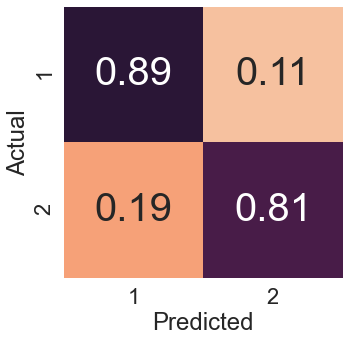

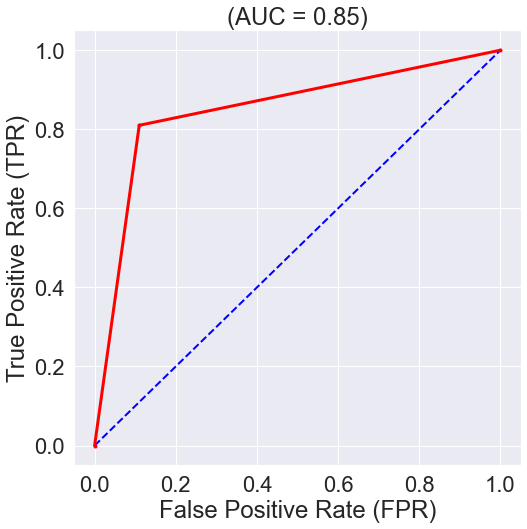

In [16]:
RF_biomarkers_indices = []

for jj in range(0,num_top):
    RF_biomarkers_indices.append(np.arange(0,d,1)[protein_IDs == SVM_biomarkers_RFE[jj]].reshape(-1))

RF_biomarkers_indices = np.array(RF_biomarkers_indices).reshape(-1)

X_biomarkers = X_scaled[:,RF_biomarkers_indices]

num_experiments = 100

conf_matrix_dict = {}
RF_train_acc_array = []
RF_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(X_biomarkers,y_labels,trainfrac)

    RF_model = RFC(random_state=0)
    RF_model.fit(X_train_all, y_train_all)

    y_train_hat = RF_model.predict(X_train_all)
    RF_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    RF_train_acc_array.append(RF_train_acc)

    y_test_hat = RF_model.predict(X_test_all)
    RF_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    RF_test_acc_array.append(RF_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)
    
    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(RF_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(RF_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(RF_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(RF_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(RF_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(RF_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_RF = np.zeros((C,C))
for i in range(0,conf_matrix_RF.shape[0]):
    conf_matrix_RF[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_RF = pd.DataFrame(conf_matrix_RF, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_RF, cbar=False, annot=True, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_RF[1,1]
FN = conf_matrix_RF[1,0]
FP = conf_matrix_RF[0,1]
TN = conf_matrix_RF[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='RF Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('(AUC = {:.2f})'.format(AUC))
plt.show()

### 1.3.2 Support Vector Machines Using Extracted Features

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

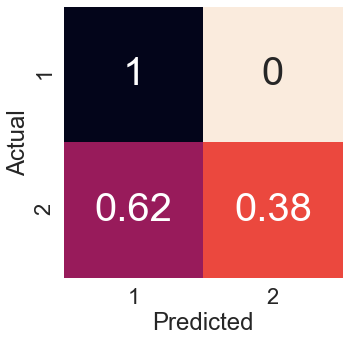

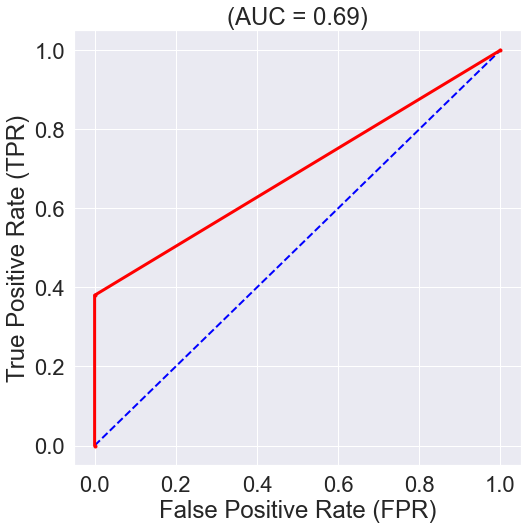

In [17]:
SVM_biomarkers_indices = []

for jj in range(0,num_top):
    SVM_biomarkers_indices.append(np.arange(0,d,1)[protein_IDs == RF_biomarkers_MDG[jj]].reshape(-1))

SVM_biomarkers_indices = np.array(SVM_biomarkers_indices).reshape(-1)

X_biomarkers = X_scaled[:,SVM_biomarkers_indices]

num_experiments = 100

conf_matrix_dict = {}
SVM_train_acc_array = []
SVM_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(X_biomarkers,y_labels,trainfrac)
    
    SVM_model = svm.SVC(decision_function_shape='ovr',gamma='auto', random_state=0)
    SVM_model.fit(X_train_all, y_train_all)

    y_train_hat = SVM_model.predict(X_train_all)
    SVM_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    SVM_train_acc_array.append(SVM_train_acc)

    y_test_hat = SVM_model.predict(X_test_all)
    SVM_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    SVM_test_acc_array.append(SVM_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)
        
    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(SVM_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(SVM_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(SVM_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(SVM_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(SVM_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(SVM_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_SVM = np.zeros((C,C))
for i in range(0,conf_matrix_SVM.shape[0]):
    conf_matrix_SVM[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_SVM = pd.DataFrame(conf_matrix_SVM, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_SVM, cbar=False, annot=True, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_SVM[1,1]
FN = conf_matrix_SVM[1,0]
FP = conf_matrix_SVM[0,1]
TN = conf_matrix_SVM[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='SVM Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('(AUC = {:.2f})'.format(AUC))
plt.show()

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

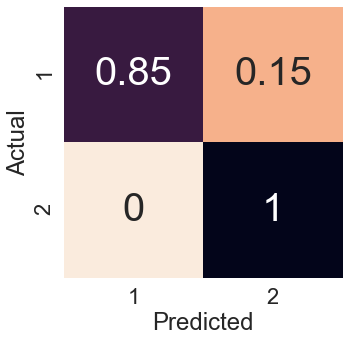

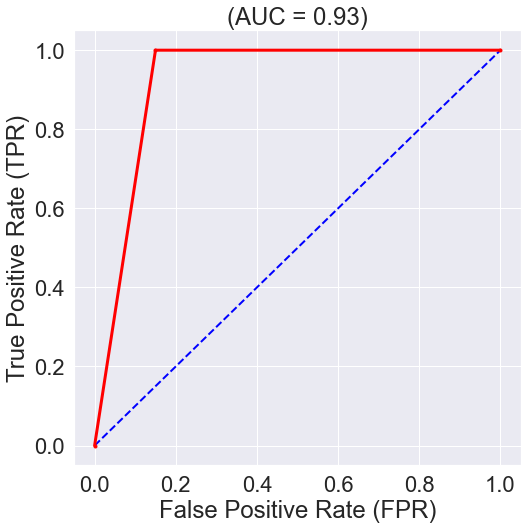

In [18]:
SVM_biomarkers_indices = []

for jj in range(0,num_top):
    SVM_biomarkers_indices.append(np.arange(0,d,1)[protein_IDs == RF_biomarkers_RFE[jj]].reshape(-1))

SVM_biomarkers_indices = np.array(SVM_biomarkers_indices).reshape(-1)

X_biomarkers = X_scaled[:,SVM_biomarkers_indices]

num_experiments = 100

conf_matrix_dict = {}
SVM_train_acc_array = []
SVM_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(X_biomarkers,y_labels,trainfrac)
    
    SVM_model = svm.SVC(decision_function_shape='ovr',gamma='auto', random_state=0)
    SVM_model.fit(X_train_all, y_train_all)

    y_train_hat = SVM_model.predict(X_train_all)
    SVM_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    SVM_train_acc_array.append(SVM_train_acc)

    y_test_hat = SVM_model.predict(X_test_all)
    SVM_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    SVM_test_acc_array.append(SVM_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)
        
    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(SVM_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(SVM_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(SVM_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(SVM_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(SVM_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(SVM_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_SVM = np.zeros((C,C))
for i in range(0,conf_matrix_SVM.shape[0]):
    conf_matrix_SVM[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_SVM = pd.DataFrame(conf_matrix_SVM, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_SVM, cbar=False, annot=True, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_SVM[1,1]
FN = conf_matrix_SVM[1,0]
FP = conf_matrix_SVM[0,1]
TN = conf_matrix_SVM[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='SVM Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('(AUC = {:.2f})'.format(AUC))
plt.show()

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

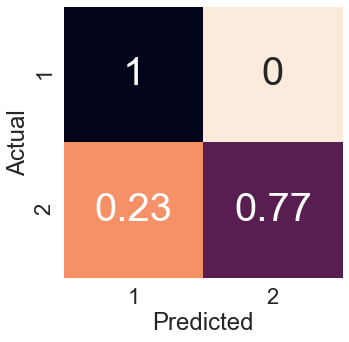

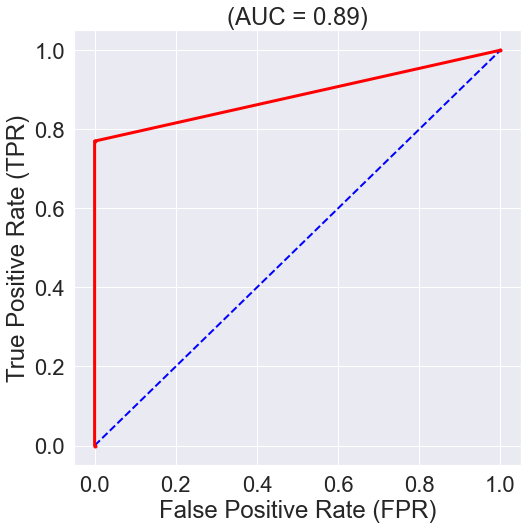

In [19]:
SVM_biomarkers_indices = []

for jj in range(0,num_top):
    SVM_biomarkers_indices.append(np.arange(0,d,1)[protein_IDs == SVM_biomarkers_RFE[jj]].reshape(-1))

SVM_biomarkers_indices = np.array(SVM_biomarkers_indices).reshape(-1)

X_biomarkers = X_scaled[:,SVM_biomarkers_indices]

num_experiments = 100

conf_matrix_dict = {}
SVM_train_acc_array = []
SVM_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(X_biomarkers,y_labels,trainfrac)
    
    SVM_model = svm.SVC(decision_function_shape='ovr',gamma='auto', random_state=0)
    SVM_model.fit(X_train_all, y_train_all)

    y_train_hat = SVM_model.predict(X_train_all)
    SVM_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    SVM_train_acc_array.append(SVM_train_acc)

    y_test_hat = SVM_model.predict(X_test_all)
    SVM_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    SVM_test_acc_array.append(SVM_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)
        
    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(SVM_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(SVM_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(SVM_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(SVM_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(SVM_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(SVM_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_SVM = np.zeros((C,C))
for i in range(0,conf_matrix_SVM.shape[0]):
    conf_matrix_SVM[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_SVM = pd.DataFrame(conf_matrix_SVM, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_SVM, cbar=False, annot=True, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_SVM[1,1]
FN = conf_matrix_SVM[1,0]
FP = conf_matrix_SVM[0,1]
TN = conf_matrix_SVM[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='SVM Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('(AUC = {:.2f})'.format(AUC))
plt.show()

# Task 2: Supervised Learning Using Traditional Latent Features

The following traditional Unsupervised Learning techniques will be explored:

- Principal Component Analysis (PCA)
- Multidimensional Scaling (MDS)
- Isometric Mapping (ISOMAP)
- Locally Linear Embedding (LLE)
- Uniform Manifold Approximation and Projection (UMAP)

## 2.1: Principal Component Analysis (PCA)

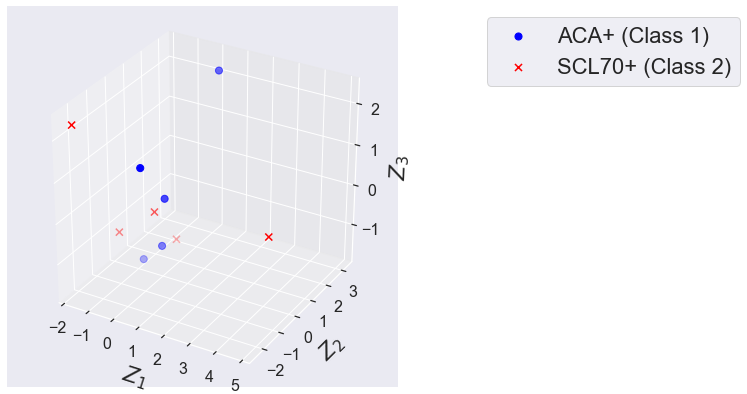

In [20]:
%matplotlib inline

k_PCA = 3

PCA_model = PCA(n_components = k_PCA)
Z_PCA = PCA_model.fit_transform(X_scaled)

## Label samples using known patient outcomes
Z_0_PCA = Z_PCA[y_labels==0] # Class 0, ACA+
Z_1_PCA = Z_PCA[y_labels==1] # Class 1, SCL70+

## Latent Space Plots
dim_1 = 0
dim_2 = 1
dim_3 = 2

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection='3d')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.scatter(Z_0_PCA[:,dim_1], Z_0_PCA[:,dim_2], Z_0_PCA[:,dim_3], marker='o', s=50, color='blue', label = "ACA+ (Class 1)")
ax.scatter(Z_1_PCA[:,dim_1], Z_1_PCA[:,dim_2], Z_1_PCA[:,dim_3], marker='x', s=50, color='red', label = "SCL70+ (Class 2)")

ax.set_xlabel('$Z_{}$'.format(dim_1+1),fontsize=22,labelpad=10)
ax.set_ylabel('$Z_{}$'.format(dim_2+1),fontsize=22,labelpad=10)
ax.set_zlabel('$Z_{}$'.format(dim_3+1),fontsize=22,labelpad=10)

ax.legend(bbox_to_anchor=(1.2,1))
plt.show()

### Pre-processing for Supervised Learning
Z_PCA_scaled = MinMaxScaler().fit_transform(Z_PCA)
Z_0_PCA_scaled = Z_PCA_scaled[y_labels == 0]
Z_1_PCA_scaled = Z_PCA_scaled[y_labels == 1]

### 2.1.1 RF modelling on PCA latent features

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

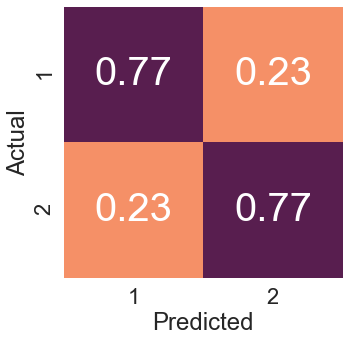

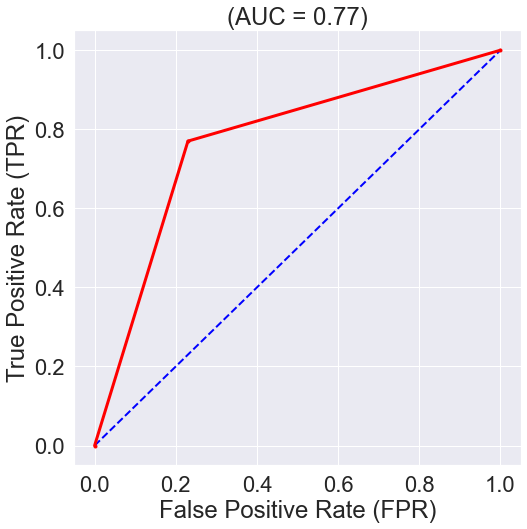

In [21]:
num_experiments = 100

conf_matrix_dict = {}
RF_train_acc_array = []
RF_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(Z_PCA_scaled,y_labels,trainfrac)

    RF_model = RFC(random_state=0)
    RF_model.fit(X_train_all, y_train_all)

    y_train_hat = RF_model.predict(X_train_all)
    RF_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    RF_train_acc_array.append(RF_train_acc)

    y_test_hat = RF_model.predict(X_test_all)
    RF_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    RF_test_acc_array.append(RF_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)

    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(RF_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(RF_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(RF_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(RF_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(RF_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(RF_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_RF = np.zeros((C,C))
for i in range(0,conf_matrix_RF.shape[0]):
    conf_matrix_RF[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_RF = pd.DataFrame(conf_matrix_RF, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_RF, cbar=False, annot=True, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_RF[1,1]
FN = conf_matrix_RF[1,0]
FP = conf_matrix_RF[0,1]
TN = conf_matrix_RF[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='RF Model')
plt.title('(AUC = {:.2f})'.format(AUC))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

### 2.1.2 SVM modelling on PCA latent features

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

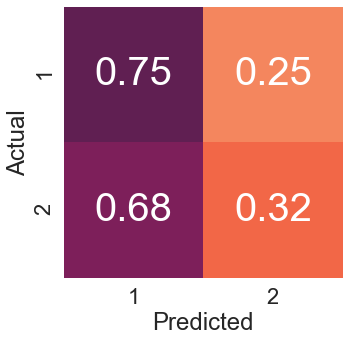

Text(0.5, 1.0, '(AUC = 0.54)')

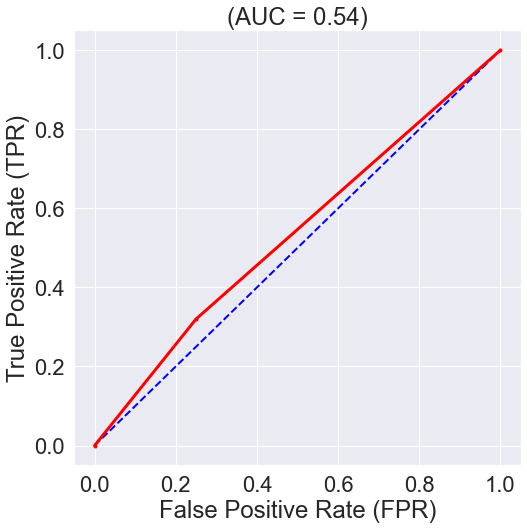

In [22]:
num_experiments = 100

conf_matrix_dict = {}
SVM_train_acc_array = []
SVM_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(Z_PCA_scaled,y_labels,trainfrac)
    
    SVM_model = svm.SVC(decision_function_shape='ovr',gamma='auto', random_state=0)
    SVM_model.fit(X_train_all, y_train_all)

    y_train_hat = SVM_model.predict(X_train_all)
    SVM_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    SVM_train_acc_array.append(SVM_train_acc)

    y_test_hat = SVM_model.predict(X_test_all)
    SVM_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    SVM_test_acc_array.append(SVM_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)
    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(SVM_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(SVM_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(SVM_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(SVM_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(SVM_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(SVM_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_SVM = np.zeros((C,C))
for i in range(0,conf_matrix_SVM.shape[0]):
    conf_matrix_SVM[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_SVM = pd.DataFrame(conf_matrix_SVM, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_SVM, annot=True, cbar=False, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_SVM[1,1]
FN = conf_matrix_SVM[1,0]
FP = conf_matrix_SVM[0,1]
TN = conf_matrix_SVM[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='SVM Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('(AUC = {:.2f})'.format(AUC))

## 2.2 Multidimensional Scaling (MDS)

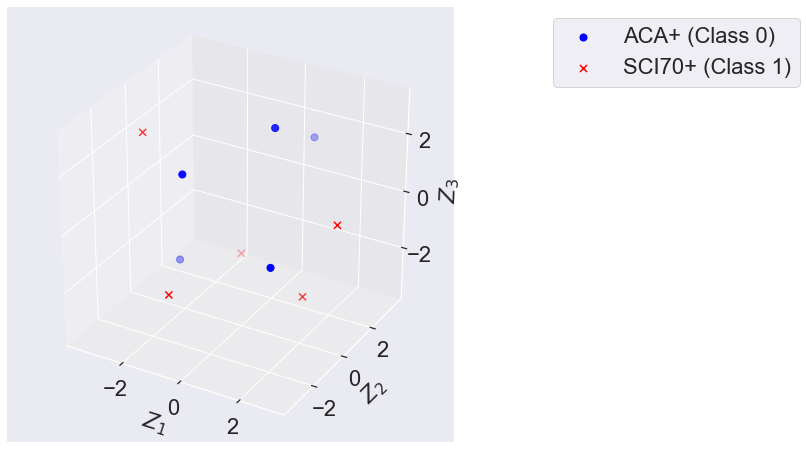

In [99]:
%matplotlib inline

k_MDS = 3

MDS_model = MDS(n_components = k_MDS)
Z_MDS = MDS_model.fit_transform(X_scaled)

## Label samples using known patient outcomes
Z_0_MDS = Z_MDS[y_labels==0] # Class 0, ACA+
Z_1_MDS = Z_MDS[y_labels==1] # Class 1, SCL70+

## Latent Space Plots
dim_1 = 0
dim_2 = 1
dim_3 = 2

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(Z_0_MDS[:,dim_1], Z_0_MDS[:,dim_2], Z_0_MDS[:,dim_3], marker='o', s=50, color='blue', label = "ACA+ (Class 0)")
ax.scatter(Z_1_MDS[:,dim_1], Z_1_MDS[:,dim_2], Z_1_MDS[:,dim_3], marker='x', s=50, color='red', label = "SCI70+ (Class 1)")

ax.set_xlabel('$Z_{}$'.format(dim_1+1),fontsize=22,labelpad=10)
ax.set_ylabel('$Z_{}$'.format(dim_2+1),fontsize=22,labelpad=10)
ax.set_zlabel('$Z_{}$'.format(dim_3+1),fontsize=22,labelpad=10)

ax.legend(bbox_to_anchor=(1.8,1))
plt.show()

### Pre-processing for Supervised Learning
Z_MDS_scaled = MinMaxScaler().fit_transform(Z_MDS)
Z_0_MDS_scaled = Z_MDS_scaled[y_labels == 0]
Z_1_MDS_scaled = Z_MDS_scaled[y_labels == 1]

### 2.2.1 RF modelling on MDS latent features

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

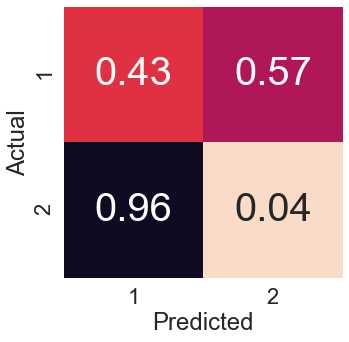

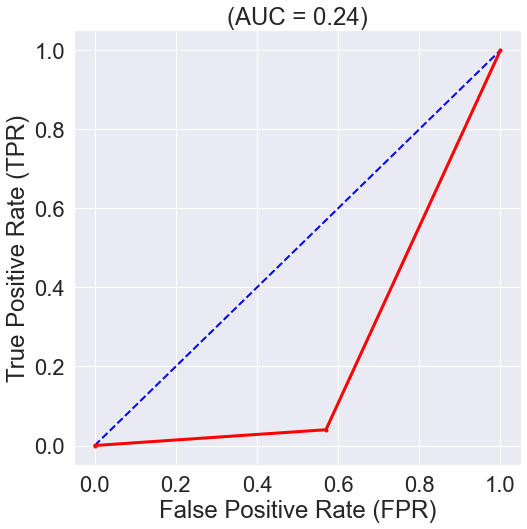

In [24]:
num_experiments = 100

conf_matrix_dict = {}
RF_train_acc_array = []
RF_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(Z_MDS_scaled,y_labels,trainfrac)

    RF_model = RFC(random_state=0)
    RF_model.fit(X_train_all, y_train_all)

    y_train_hat = RF_model.predict(X_train_all)
    RF_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    RF_train_acc_array.append(RF_train_acc)

    y_test_hat = RF_model.predict(X_test_all)
    RF_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    RF_test_acc_array.append(RF_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)

    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(RF_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(RF_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(RF_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(RF_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(RF_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(RF_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_RF = np.zeros((C,C))
for i in range(0,conf_matrix_RF.shape[0]):
    conf_matrix_RF[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_RF = pd.DataFrame(conf_matrix_RF, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_RF, cbar=False, annot=True, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_RF[1,1]
FN = conf_matrix_RF[1,0]
FP = conf_matrix_RF[0,1]
TN = conf_matrix_RF[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='RF Model')
plt.title('(AUC = {:.2f})'.format(AUC))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

### 2.2.2 SVM modelling on MDS latent features

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

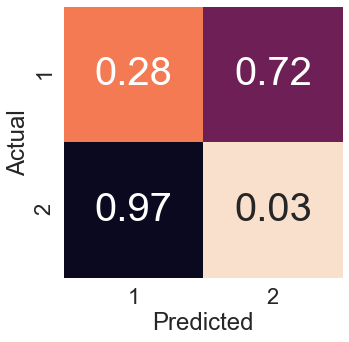

Text(0.5, 1.0, '(AUC = 0.16)')

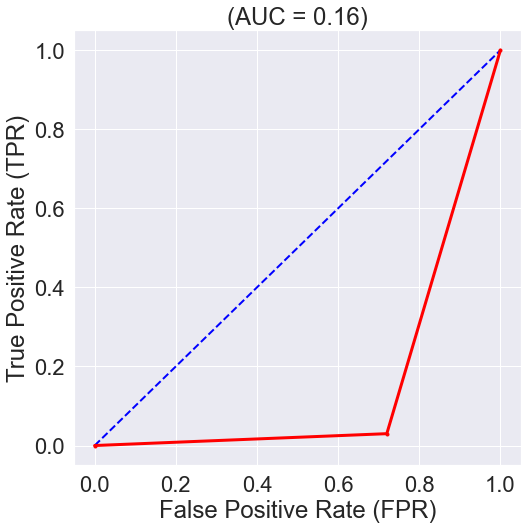

In [25]:
num_experiments = 100

conf_matrix_dict = {}
SVM_train_acc_array = []
SVM_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(Z_MDS_scaled,y_labels,trainfrac)
    
    SVM_model = svm.SVC(decision_function_shape='ovr',gamma='auto', random_state=0)
    SVM_model.fit(X_train_all, y_train_all)

    y_train_hat = SVM_model.predict(X_train_all)
    SVM_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    SVM_train_acc_array.append(SVM_train_acc)

    y_test_hat = SVM_model.predict(X_test_all)
    SVM_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    SVM_test_acc_array.append(SVM_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)
    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(SVM_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(SVM_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(SVM_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(SVM_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(SVM_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(SVM_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_SVM = np.zeros((C,C))
for i in range(0,conf_matrix_SVM.shape[0]):
    conf_matrix_SVM[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_SVM = pd.DataFrame(conf_matrix_SVM, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_SVM, annot=True, cbar=False, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_SVM[1,1]
FN = conf_matrix_SVM[1,0]
FP = conf_matrix_SVM[0,1]
TN = conf_matrix_SVM[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='SVM Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('(AUC = {:.2f})'.format(AUC))

## 2.3 Isometric Mapping (ISOMAP)

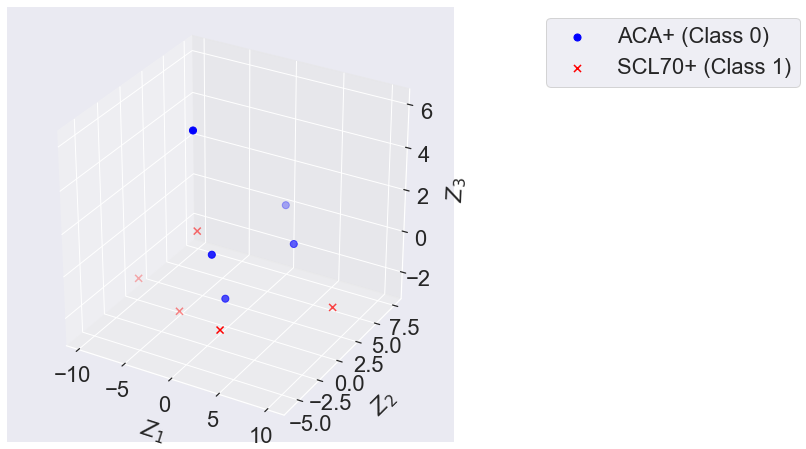

In [26]:
%matplotlib inline

k_ISOMAP = 3
knn_ISOMAP = 2

ISOMAP_model = ISOMAP(n_components = k_ISOMAP,n_neighbors=knn_ISOMAP)
Z_ISOMAP = ISOMAP_model.fit_transform(X_scaled)

## Label samples using known patient outcomes
Z_0_ISOMAP = Z_ISOMAP[y_labels==0] # Class 0, ACA+
Z_1_ISOMAP = Z_ISOMAP[y_labels==1] # Class 1, SCL70+

## Latent Space Plots
dim_1 = 0
dim_2 = 1
dim_3 = 2

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(Z_0_ISOMAP[:,dim_1], Z_0_ISOMAP[:,dim_2], Z_0_ISOMAP[:,dim_3], marker='o', s=50, color='blue', label = "ACA+ (Class 0)")
ax.scatter(Z_1_ISOMAP[:,dim_1], Z_1_ISOMAP[:,dim_2], Z_1_ISOMAP[:,dim_3], marker='x', s=50, color='red', label = "SCL70+ (Class 1)")

ax.set_xlabel('$Z_{}$'.format(dim_1+1),fontsize=22,labelpad=15)
ax.set_ylabel('$Z_{}$'.format(dim_2+1),fontsize=22,labelpad=20)
ax.set_zlabel('$Z_{}$'.format(dim_3+1),fontsize=22,labelpad=15)

ax.legend(bbox_to_anchor=(1.8,1))
plt.show()

### Pre-processing for Supervised Learning
Z_ISOMAP_scaled = MinMaxScaler().fit_transform(Z_ISOMAP)
Z_0_ISOMAP_scaled = Z_ISOMAP_scaled[y_labels == 0]
Z_1_ISOMAP_scaled = Z_ISOMAP_scaled[y_labels == 1]

### 2.3.1 RF modelling on ISOMAP latent features

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

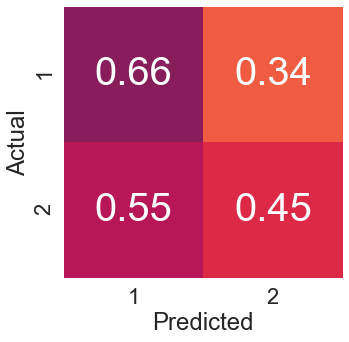

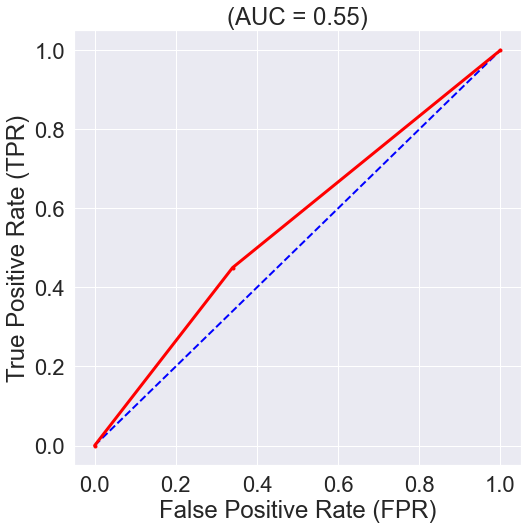

In [27]:
num_experiments = 100

conf_matrix_dict = {}
RF_train_acc_array = []
RF_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(Z_ISOMAP_scaled,y_labels,trainfrac)

    RF_model = RFC(random_state=0)
    RF_model.fit(X_train_all, y_train_all)

    y_train_hat = RF_model.predict(X_train_all)
    RF_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    RF_train_acc_array.append(RF_train_acc)

    y_test_hat = RF_model.predict(X_test_all)
    RF_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    RF_test_acc_array.append(RF_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)

    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(RF_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(RF_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(RF_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(RF_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(RF_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(RF_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_RF = np.zeros((C,C))
for i in range(0,conf_matrix_RF.shape[0]):
    conf_matrix_RF[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_RF = pd.DataFrame(conf_matrix_RF, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_RF, cbar=False, annot=True, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_RF[1,1]
FN = conf_matrix_RF[1,0]
FP = conf_matrix_RF[0,1]
TN = conf_matrix_RF[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='RF Model')
plt.title('(AUC = {:.2f})'.format(AUC))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

### 2.3.2 SVM modelling on ISOMAP latent features

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

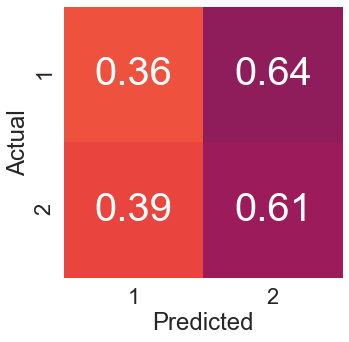

Text(0.5, 1.0, '(AUC = 0.48)')

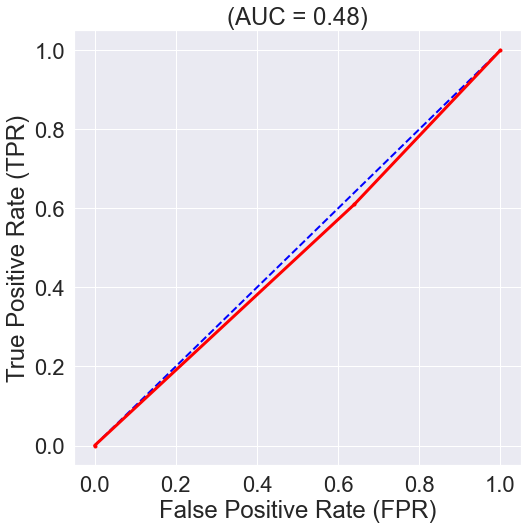

In [28]:
num_experiments = 100

conf_matrix_dict = {}
SVM_train_acc_array = []
SVM_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(Z_ISOMAP_scaled,y_labels,trainfrac)
    
    SVM_model = svm.SVC(decision_function_shape='ovr',gamma='auto', random_state=0)
    SVM_model.fit(X_train_all, y_train_all)

    y_train_hat = SVM_model.predict(X_train_all)
    SVM_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    SVM_train_acc_array.append(SVM_train_acc)

    y_test_hat = SVM_model.predict(X_test_all)
    SVM_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    SVM_test_acc_array.append(SVM_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)
    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(SVM_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(SVM_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(SVM_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(SVM_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(SVM_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(SVM_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_SVM = np.zeros((C,C))
for i in range(0,conf_matrix_SVM.shape[0]):
    conf_matrix_SVM[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_SVM = pd.DataFrame(conf_matrix_SVM, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_SVM, annot=True, cbar=False, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_SVM[1,1]
FN = conf_matrix_SVM[1,0]
FP = conf_matrix_SVM[0,1]
TN = conf_matrix_SVM[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='SVM Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('(AUC = {:.2f})'.format(AUC))

## 2.4 Locally Linear Embedding (LLE)

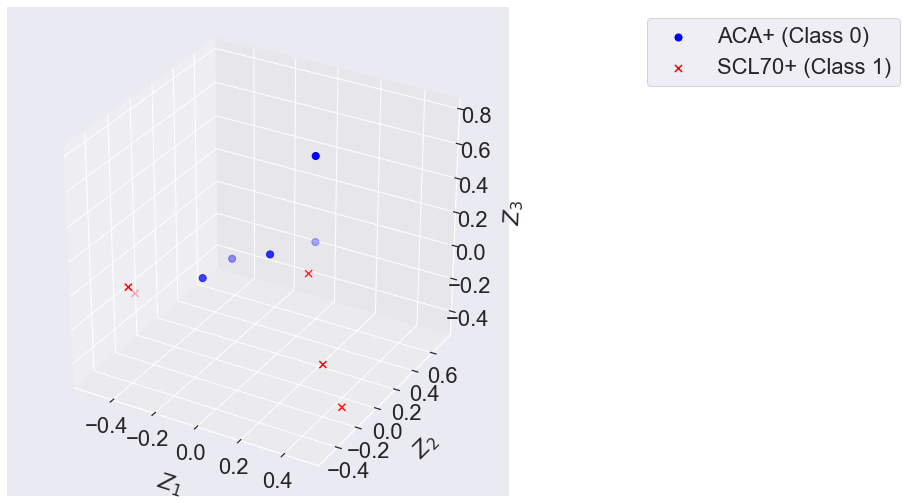

In [29]:
%matplotlib inline

k_LLE = 3
knn_LLE = 2

LLE_model = LLE(n_components = k_LLE,n_neighbors=knn_LLE)
Z_LLE = LLE_model.fit_transform(X_scaled)

## Label samples using known patient outcomes
Z_0_LLE = Z_LLE[y_labels==0] # Class 0, ACA+
Z_1_LLE = Z_LLE[y_labels==1] # Class 1, SCL70+

## Latent Space Plots
dim_1 = 0
dim_2 = 1
dim_3 = 2

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(projection='3d')
ax.scatter(Z_0_LLE[:,dim_1], Z_0_LLE[:,dim_2], Z_0_LLE[:,dim_3], marker='o', s=50, color='blue', label = "ACA+ (Class 0)")
ax.scatter(Z_1_LLE[:,dim_1], Z_1_LLE[:,dim_2], Z_1_LLE[:,dim_3], marker='x', s=50, color='red', label = "SCL70+ (Class 1)")

ax.set_xlabel('$Z_{}$'.format(dim_1+1),fontsize=22,labelpad=20)
ax.set_ylabel('$Z_{}$'.format(dim_2+1),fontsize=22,labelpad=20)
ax.set_zlabel('$Z_{}$'.format(dim_3+1),fontsize=22,labelpad=20)

ax.legend(bbox_to_anchor=(1.8,1))
plt.show()

### Pre-processing for Supervised Learning
Z_LLE_scaled = MinMaxScaler().fit_transform(Z_LLE)
Z_0_LLE_scaled = Z_LLE_scaled[y_labels == 0]
Z_1_LLE_scaled = Z_LLE_scaled[y_labels == 1]

### 2.4.1 RF modelling on LLE latent features

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

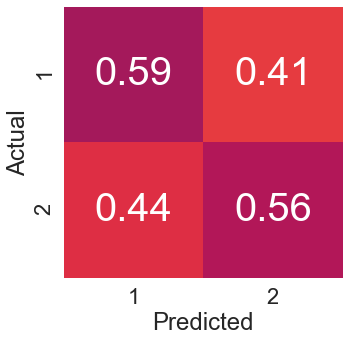

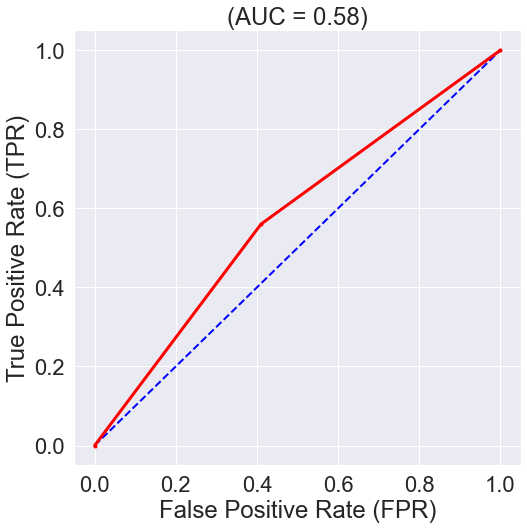

In [30]:
num_experiments = 100

conf_matrix_dict = {}
RF_train_acc_array = []
RF_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(Z_LLE_scaled,y_labels,trainfrac)

    RF_model = RFC(random_state=0)
    RF_model.fit(X_train_all, y_train_all)

    y_train_hat = RF_model.predict(X_train_all)
    RF_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    RF_train_acc_array.append(RF_train_acc)

    y_test_hat = RF_model.predict(X_test_all)
    RF_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    RF_test_acc_array.append(RF_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)

    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(RF_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(RF_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(RF_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(RF_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(RF_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(RF_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_RF = np.zeros((C,C))
for i in range(0,conf_matrix_RF.shape[0]):
    conf_matrix_RF[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_RF = pd.DataFrame(conf_matrix_RF, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_RF, cbar=False, annot=True, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_RF[1,1]
FN = conf_matrix_RF[1,0]
FP = conf_matrix_RF[0,1]
TN = conf_matrix_RF[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='RF Model')
plt.title('(AUC = {:.2f})'.format(AUC))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

### 2.4.2 SVM modelling on LLE latent features

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

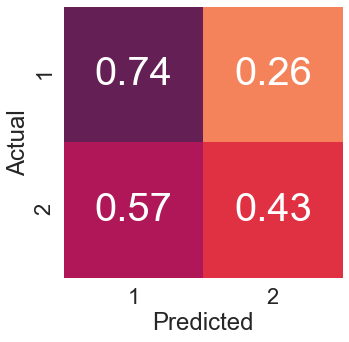

Text(0.5, 1.0, '(AUC = 0.58)')

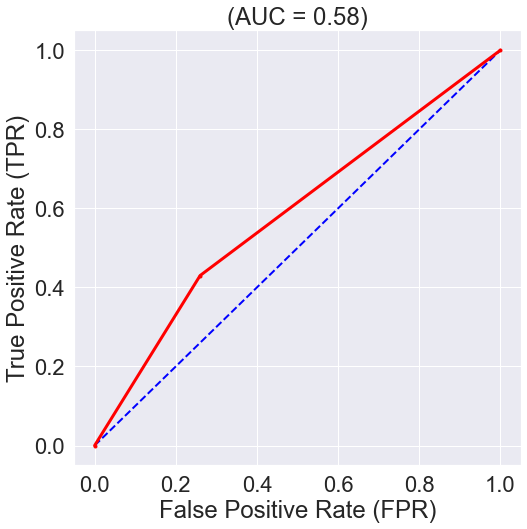

In [31]:
num_experiments = 100

conf_matrix_dict = {}
SVM_train_acc_array = []
SVM_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(Z_LLE_scaled,y_labels,trainfrac)
    
    SVM_model = svm.SVC(decision_function_shape='ovr',gamma='auto', random_state=0)
    SVM_model.fit(X_train_all, y_train_all)

    y_train_hat = SVM_model.predict(X_train_all)
    SVM_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    SVM_train_acc_array.append(SVM_train_acc)

    y_test_hat = SVM_model.predict(X_test_all)
    SVM_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    SVM_test_acc_array.append(SVM_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)
    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(SVM_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(SVM_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(SVM_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(SVM_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(SVM_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(SVM_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_SVM = np.zeros((C,C))
for i in range(0,conf_matrix_SVM.shape[0]):
    conf_matrix_SVM[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_SVM = pd.DataFrame(conf_matrix_SVM, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_SVM, annot=True, cbar=False, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_SVM[1,1]
FN = conf_matrix_SVM[1,0]
FP = conf_matrix_SVM[0,1]
TN = conf_matrix_SVM[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='SVM Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('(AUC = {:.2f})'.format(AUC))

## 2.5 t-Stochastic Neighbor Embedding (t-SNE)

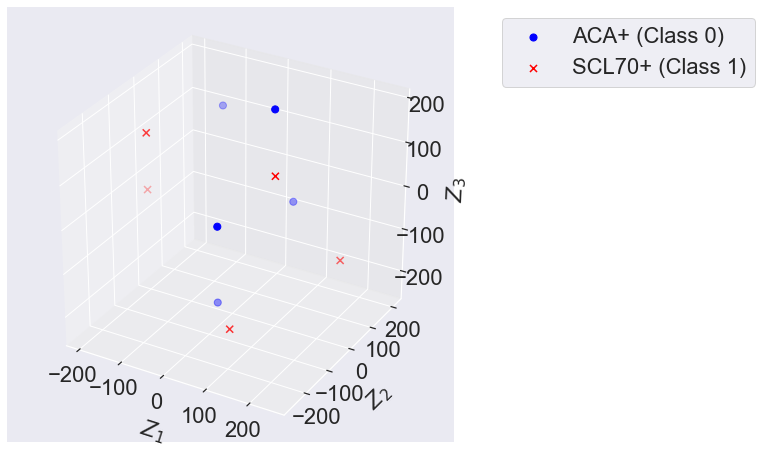

In [32]:
%matplotlib inline

k_TSNE = 3

TSNE_model = TSNE(n_components = k_TSNE)
Z_TSNE = TSNE_model.fit_transform(X_scaled)

## Label samples using known patient outcomes
Z_0_TSNE = Z_TSNE[y_labels==0] # Class 0, ACA+
Z_1_TSNE = Z_TSNE[y_labels==1] # Class 1, SCL70+

## Latent Space Plots
dim_1 = 0
dim_2 = 1
dim_3 = 2

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(Z_0_TSNE[:,dim_1], Z_0_TSNE[:,dim_2], Z_0_TSNE[:,dim_3], marker='o', s=50, color='blue', label = "ACA+ (Class 0)")
ax.scatter(Z_1_TSNE[:,dim_1], Z_1_TSNE[:,dim_2], Z_1_TSNE[:,dim_3], marker='x', s=50, color='red', label = "SCL70+ (Class 1)")

ax.set_xlabel('$Z_{}$'.format(dim_1+1),fontsize=22,labelpad=15)
ax.set_ylabel('$Z_{}$'.format(dim_2+1),fontsize=22,labelpad=15)
ax.set_zlabel('$Z_{}$'.format(dim_3+1),fontsize=22,labelpad=15)

ax.legend(bbox_to_anchor=(1.7,1))
plt.show()

### Pre-processing for Supervised Learning
Z_TSNE_scaled = MinMaxScaler().fit_transform(Z_TSNE)
Z_0_TSNE_scaled = Z_TSNE_scaled[y_labels == 0]
Z_1_TSNE_scaled = Z_TSNE_scaled[y_labels == 1]

### 2.5.1 RF modelling on t-SNE latent features

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

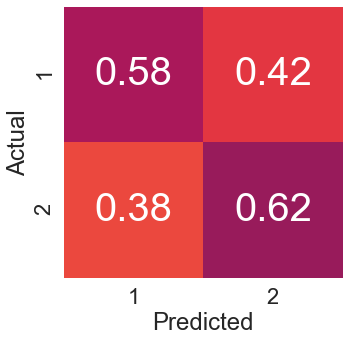

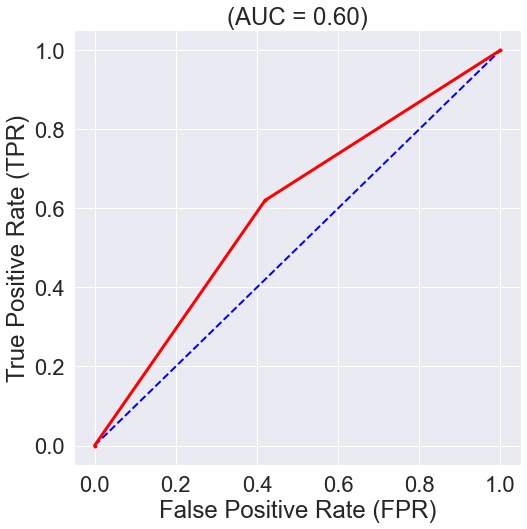

In [33]:
num_experiments = 100

conf_matrix_dict = {}
RF_train_acc_array = []
RF_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(Z_TSNE_scaled,y_labels,trainfrac)

    RF_model = RFC(random_state=0)
    RF_model.fit(X_train_all, y_train_all)

    y_train_hat = RF_model.predict(X_train_all)
    RF_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    RF_train_acc_array.append(RF_train_acc)

    y_test_hat = RF_model.predict(X_test_all)
    RF_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    RF_test_acc_array.append(RF_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)

    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(RF_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(RF_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(RF_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(RF_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(RF_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(RF_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_RF = np.zeros((C,C))
for i in range(0,conf_matrix_RF.shape[0]):
    conf_matrix_RF[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_RF = pd.DataFrame(conf_matrix_RF, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_RF, cbar=False, annot=True, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_RF[1,1]
FN = conf_matrix_RF[1,0]
FP = conf_matrix_RF[0,1]
TN = conf_matrix_RF[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='RF Model')
plt.title('(AUC = {:.2f})'.format(AUC))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

### 2.5.2 SVM modelling on t-SNE latent features

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

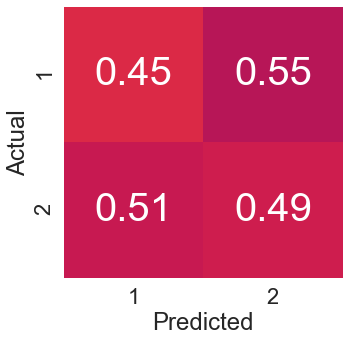

Text(0.5, 1.0, '(AUC = 0.47)')

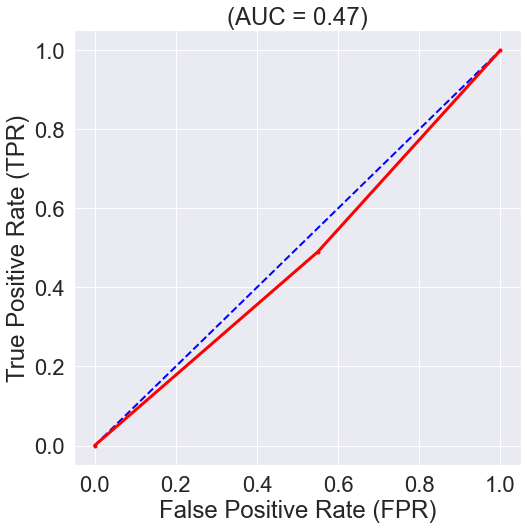

In [34]:
num_experiments = 100

conf_matrix_dict = {}
SVM_train_acc_array = []
SVM_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(Z_TSNE_scaled,y_labels,trainfrac)
    
    SVM_model = svm.SVC(decision_function_shape='ovr',gamma='auto', random_state=0)
    SVM_model.fit(X_train_all, y_train_all)

    y_train_hat = SVM_model.predict(X_train_all)
    SVM_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    SVM_train_acc_array.append(SVM_train_acc)

    y_test_hat = SVM_model.predict(X_test_all)
    SVM_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    SVM_test_acc_array.append(SVM_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)
    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(SVM_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(SVM_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(SVM_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(SVM_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(SVM_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(SVM_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_SVM = np.zeros((C,C))
for i in range(0,conf_matrix_SVM.shape[0]):
    conf_matrix_SVM[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_SVM = pd.DataFrame(conf_matrix_SVM, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_SVM, annot=True, cbar=False, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_SVM[1,1]
FN = conf_matrix_SVM[1,0]
FP = conf_matrix_SVM[0,1]
TN = conf_matrix_SVM[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='SVM Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('(AUC = {:.2f})'.format(AUC))

## 2.6 Uniform Manifold Approximation and Projection (UMAP)

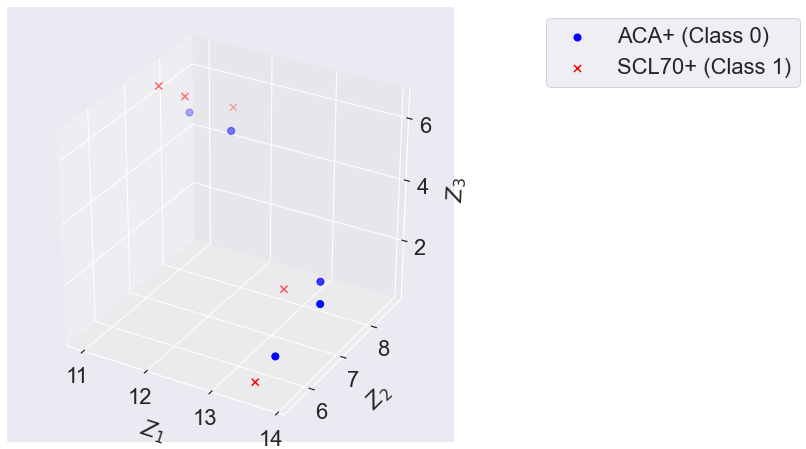

In [35]:
%matplotlib inline

k_UMAP = 3
knn_UMAP = 2

UMAP_model = umap.UMAP(n_components = k_UMAP,n_neighbors=knn_UMAP)
Z_UMAP = UMAP_model.fit_transform(X_scaled)

## Label samples using known patient outcomes
Z_0_UMAP = Z_UMAP[y_labels==0] # Class 0, ACA+
Z_1_UMAP = Z_UMAP[y_labels==1] # Class 1, SCL70+

## Latent Space Plots
dim_1 = 0
dim_2 = 1
dim_3 = 2

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(Z_0_UMAP[:,dim_1], Z_0_UMAP[:,dim_2], Z_0_UMAP[:,dim_3], marker='o', s=50, color='blue', label = "ACA+ (Class 0)")
ax.scatter(Z_1_UMAP[:,dim_1], Z_1_UMAP[:,dim_2], Z_1_UMAP[:,dim_3], marker='x', s=50, color='red', label = "SCL70+ (Class 1)")

ax.set_xlabel('$Z_{}$'.format(dim_1+1),fontsize=22,labelpad=15)
#ax.set_xlim([-6,0])
ax.set_ylabel('$Z_{}$'.format(dim_2+1),fontsize=22,labelpad=15)
ax.set_zlabel('$Z_{}$'.format(dim_3+1),fontsize=22,labelpad=15)

ax.legend(bbox_to_anchor=(1.8,1))
plt.show()

### Pre-processing for Supervised Learning
Z_UMAP_scaled = MinMaxScaler().fit_transform(Z_UMAP)
Z_0_UMAP_scaled = Z_UMAP_scaled[y_labels == 0]
Z_1_UMAP_scaled = Z_UMAP_scaled[y_labels == 1]

### 2.6.1 RF modelling on UMAP latent features

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

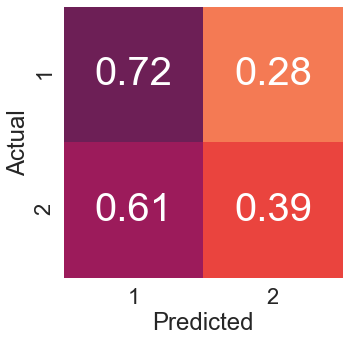

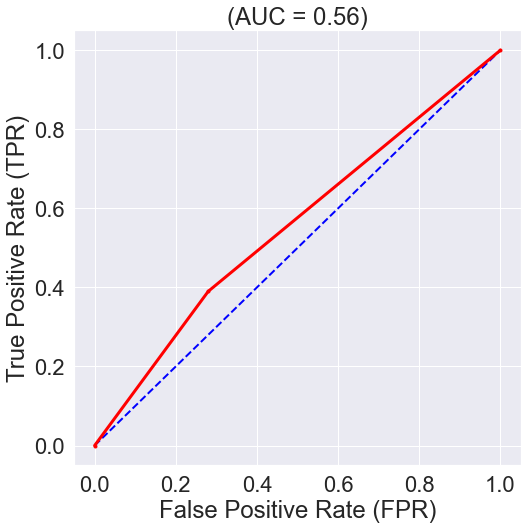

In [36]:
num_experiments = 100

conf_matrix_dict = {}
RF_train_acc_array = []
RF_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(Z_UMAP_scaled,y_labels,trainfrac)

    RF_model = RFC(random_state=0)
    RF_model.fit(X_train_all, y_train_all)

    y_train_hat = RF_model.predict(X_train_all)
    RF_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    RF_train_acc_array.append(RF_train_acc)

    y_test_hat = RF_model.predict(X_test_all)
    RF_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    RF_test_acc_array.append(RF_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)

    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(RF_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(RF_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(RF_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(RF_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(RF_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(RF_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_RF = np.zeros((C,C))
for i in range(0,conf_matrix_RF.shape[0]):
    conf_matrix_RF[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_RF = pd.DataFrame(conf_matrix_RF, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_RF, cbar=False, annot=True, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_RF[1,1]
FN = conf_matrix_RF[1,0]
FP = conf_matrix_RF[0,1]
TN = conf_matrix_RF[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='RF Model')
plt.title('(AUC = {:.2f})'.format(AUC))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

### 2.6.2 SVM modelling on UMAP latent features

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

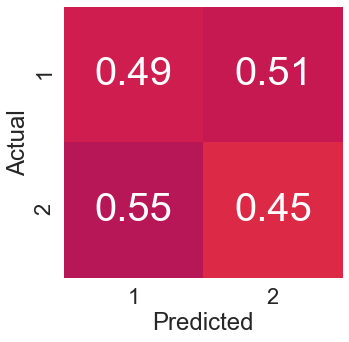

Text(0.5, 1.0, '(AUC = 0.47)')

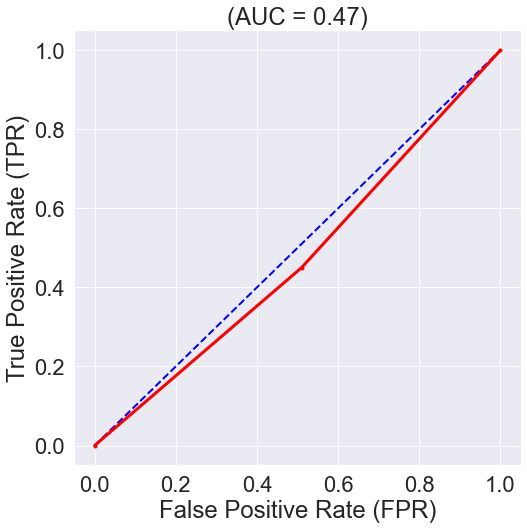

In [37]:
num_experiments = 100

conf_matrix_dict = {}
SVM_train_acc_array = []
SVM_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(Z_UMAP_scaled,y_labels,trainfrac)
    
    SVM_model = svm.SVC(decision_function_shape='ovr',gamma='auto', random_state=0)
    SVM_model.fit(X_train_all, y_train_all)

    y_train_hat = SVM_model.predict(X_train_all)
    SVM_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    SVM_train_acc_array.append(SVM_train_acc)

    y_test_hat = SVM_model.predict(X_test_all)
    SVM_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    SVM_test_acc_array.append(SVM_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)
    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(SVM_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(SVM_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(SVM_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(SVM_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(SVM_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(SVM_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_SVM = np.zeros((C,C))
for i in range(0,conf_matrix_SVM.shape[0]):
    conf_matrix_SVM[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_SVM = pd.DataFrame(conf_matrix_SVM, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_SVM, annot=True, cbar=False, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_SVM[1,1]
FN = conf_matrix_SVM[1,0]
FP = conf_matrix_SVM[0,1]
TN = conf_matrix_SVM[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='SVM Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('(AUC = {:.2f})'.format(AUC))

# Task 3: Deep Learning with Discriminative Center Loss by Wen et al (2016)

Paper: "A Discriminative Feature Learning Approach for Deep Face Recognition" (2016) https://ydwen.github.io/papers/WenECCV16.pdf. 

Starting loss of 2.2325 and ending loss of 1.6178, on epoch 400.
Starting loss of 2.2552 and ending loss of 1.6241, on epoch 400.
Starting loss of 2.2346 and ending loss of 1.6452, on epoch 400.
Starting loss of 2.2721 and ending loss of 1.6156, on epoch 400.
Starting loss of 2.2199 and ending loss of 0.0798, on epoch 999.
Run 0 now finished, with starting loss of 2.2199 and ending loss of 0.0798, on epoch 999.
Total elapsed time: 3.1 sec.


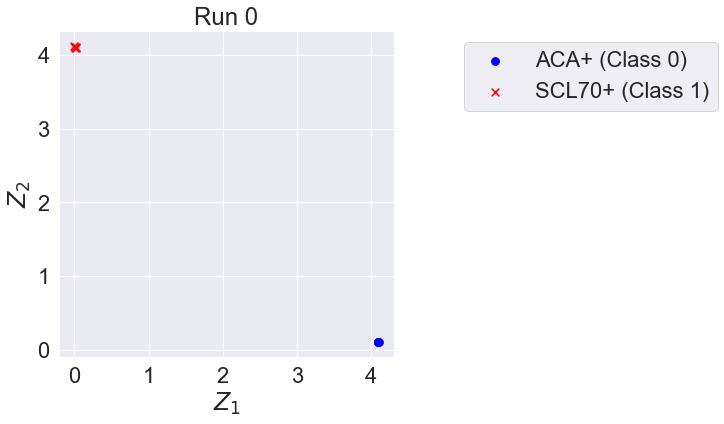

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 23
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 9
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 17

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.34618613 0.32469073 0.30603135 0.30139488]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.37668973 0.34604642 0.3232131  0.29939196]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.2811365  -0.22379111 -0.21989374 -0.18950254]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.30714038 -0.29580098 -0.28119835 -0.2512781 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2655 and ending loss of 0.0789, on epoch 999.
Run 1 now finished, with starting loss of 2.2655 and ending loss of 0.0789, on epoch 999.
Total elapsed time: 1.1 sec.


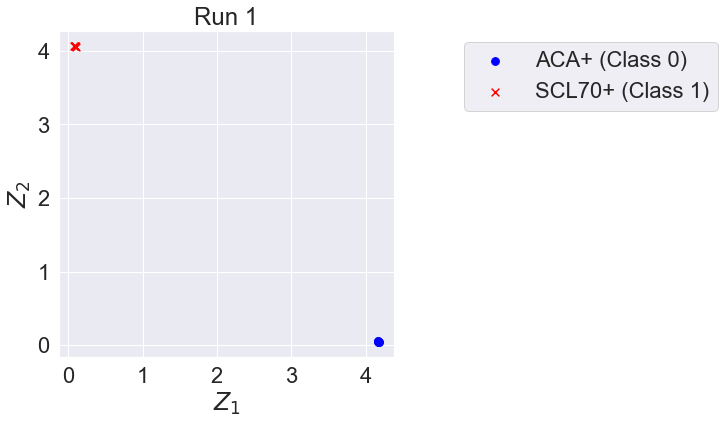

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 15

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.32756022 0.31591988 0.2994965  0.2960279 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.34424233 0.33462822 0.31961253 0.3160945 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.31870487 -0.27027458 -0.25673062 -0.25146222]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.2806798  -0.27595183 -0.25488308 -0.22995958]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2427 and ending loss of 1.6404, on epoch 400.
Starting loss of 2.2361 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2361 and ending loss of 0.0814, on epoch 999.
Run 2 now finished, with starting loss of 

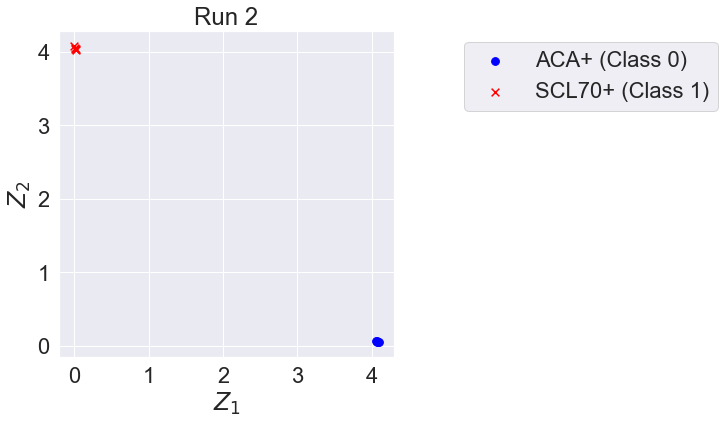

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 21
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 11
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 15

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.32530123 0.30612543 0.30100408 0.28799987]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3687491  0.355896   0.33871022 0.2942783 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.2623185  -0.25471276 -0.25086054 -0.25036442]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.25405243 -0.2538577  -0.24923825 -0.242337  ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2669 and ending loss of 0.0795, on epoch 999.
Run 3 now finished, with starting loss of 2.2669 and ending loss of 0.0795, on epoch 999.
Total elapsed time: 1.1 sec.


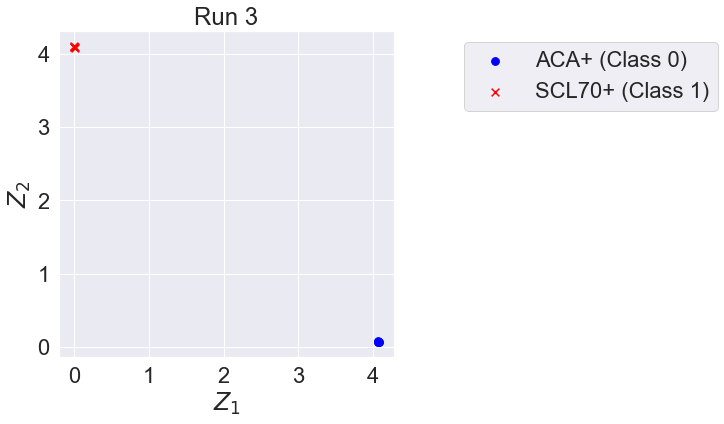

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 14
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 13

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.34051168 0.33127207 0.2948864  0.28753868]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3783004  0.32499626 0.32414794 0.32091418]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.2983617  -0.2770272  -0.27515098 -0.2741241 ]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.28146407 -0.25574344 -0.24979743 -0.2201173 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2361 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2523 and ending loss of 0.0788, on epoch 999.
Run 4 now finished, with starting loss of 2.2523 and ending loss of 0.0788, on epoch 999.
Total elapsed tim

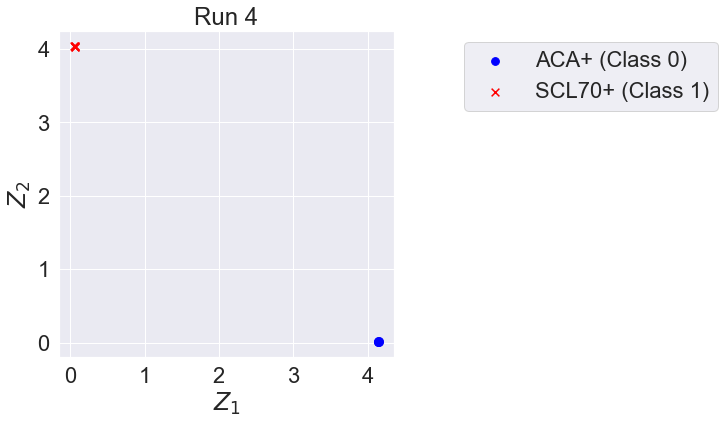

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 21
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 11
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 12
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 20

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.32701138 0.31828064 0.30867547 0.2980858 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.36398557 0.32335895 0.32018894 0.30391824]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.22732979 -0.22298555 -0.1674411  -0.14893158]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.31240448 -0.28472504 -0.2643641  -0.25982052]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2496 and ending loss of 1.6220, on epoch 400.
Starting loss of 2.2404 and ending loss of 1.6513, on epoch 400.
Starting loss of 2.2680 and ending loss of 0.0799, on epoch 999.
Run 5 now finished, with starting loss of 

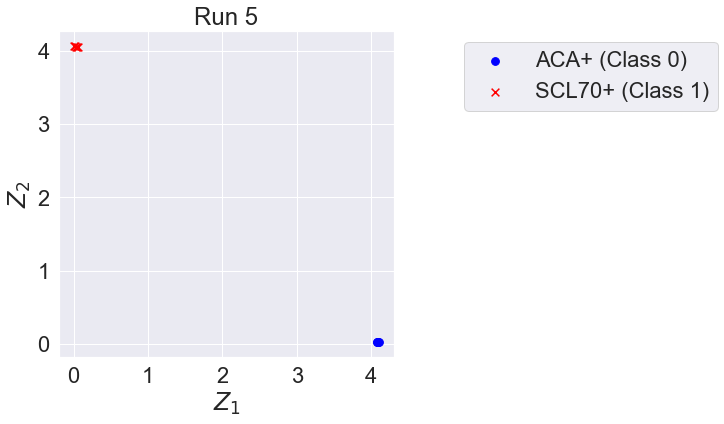

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 16

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.36178482 0.35361814 0.31495324 0.27725568]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3237003  0.3121143  0.30349812 0.296992  ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.28206313 -0.24330288 -0.23905514 -0.23651895]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.23147099 -0.22974035 -0.22856875 -0.22787453]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2810 and ending loss of 0.0822, on epoch 999.
Run 6 now finished, with starting loss of 2.2810 and ending loss of 0.0822, on epoch 999.
Total elapsed time: 1.1 sec.


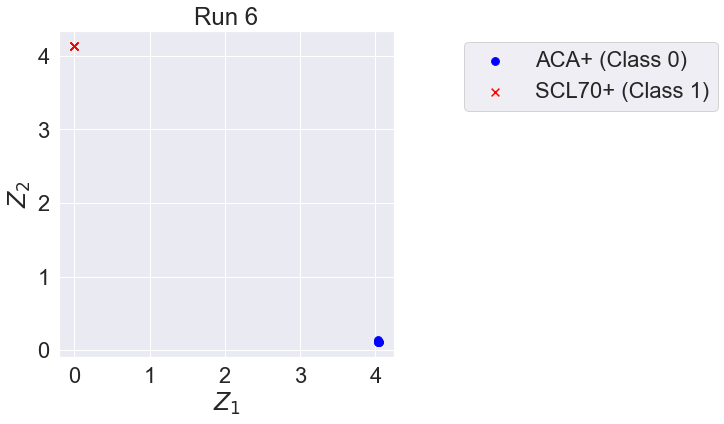

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 21
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 11

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.36702648 0.3420376  0.33684015 0.29831582]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.37925076 0.321773   0.30833852 0.27662528]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.2873645  -0.28428102 -0.27592626 -0.27159774]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.32071704 -0.32044026 -0.25055537 -0.24475637]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2567 and ending loss of 0.0795, on epoch 999.
Run 7 now finished, with starting loss of 2.2567 and ending loss of 0.0795, on epoch 999.
Total elapsed time: 1.2 sec.


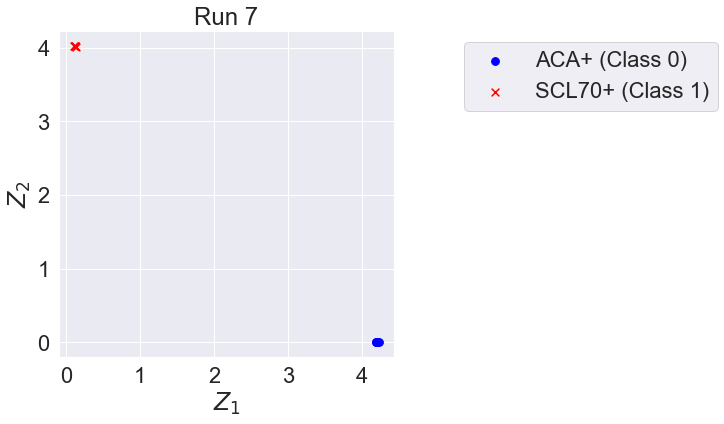

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 14
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 17

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.35410145 0.3337606  0.3132361  0.31271982]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3437569  0.3303982  0.32673723 0.30652615]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.2733837  -0.26789373 -0.2451844  -0.24115488]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.29810745 -0.23492262 -0.22351614 -0.19497442]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2252 and ending loss of 0.0795, on epoch 999.
Run 8 now finished, with starting loss of 2.2252 and ending loss of 0.0795, on epoch 999.
Total elapsed time: 1.1 sec.


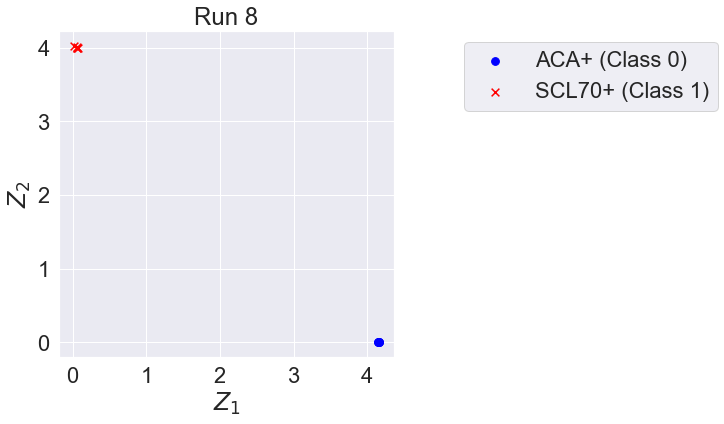

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 14
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 14

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3791506  0.3392186  0.30045304 0.2971712 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.33378997 0.32169947 0.32139376 0.32053626]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.29631266 -0.28380412 -0.25934094 -0.24536087]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.33312282 -0.27405325 -0.26389644 -0.2407927 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2670 and ending loss of 0.0781, on epoch 999.
Run 9 now finished, with starting loss of 2.2670 and ending loss of 0.0781, on epoch 999.
Total elapsed time: 1.2 sec.


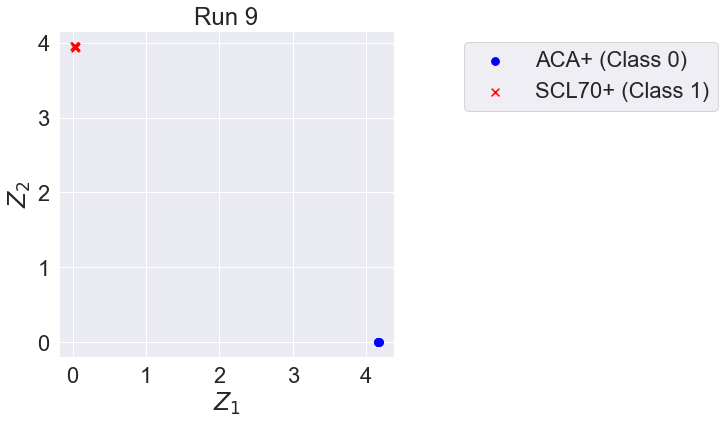

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 13

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.37620792 0.34002265 0.33511835 0.31571087]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.2943458  0.29355222 0.28283018 0.27938327]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.282396   -0.25864223 -0.2574646  -0.24798998]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.36024657 -0.3267697  -0.31474906 -0.31398022]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2361 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2394 and ending loss of 0.0788, on epoch 999.
Run 10 now finished, with starting loss of 2.2394 and ending loss of 0.0788, on epoch 999.
Total elapsed ti

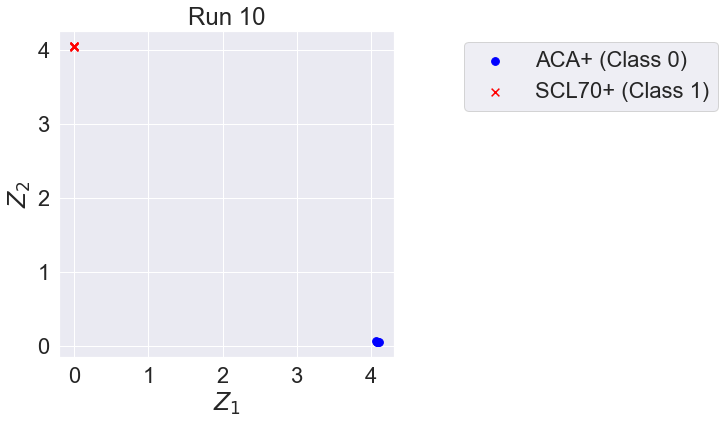

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 21
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 11
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 17

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3849864  0.3019065  0.3006456  0.29911545]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.32814243 0.29279283 0.29092422 0.27061385]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.23322885 -0.21747413 -0.20807895 -0.20292288]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.36456478 -0.2746652  -0.26485574 -0.2591209 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2364 and ending loss of 1.6304, on epoch 400.
Starting loss of 2.2906 and ending loss of 0.0780, on epoch 999.
Run 11 now finished, with starting loss of 2.2906 and ending loss of 0.0780, on epoch 999.
Total elapsed ti

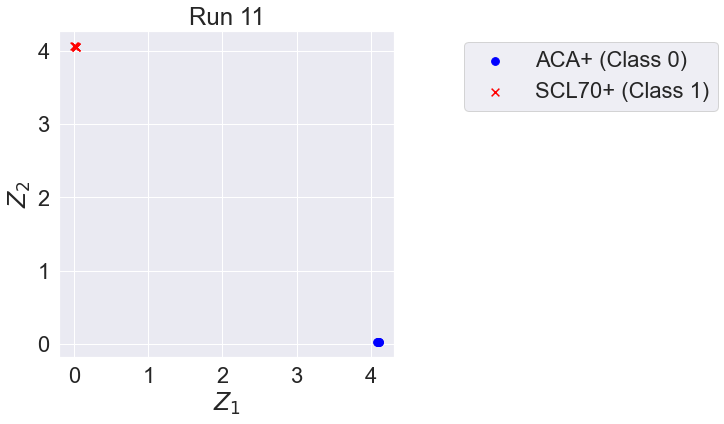

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 13

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.34935147 0.33065656 0.3235805  0.31349328]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.31987238 0.3126085  0.30741075 0.28536546]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.25064766 -0.23094672 -0.2180088  -0.1996361 ]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.28484762 -0.26663223 -0.2600309  -0.25363824]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2067 and ending loss of 1.6217, on epoch 400.
Starting loss of 2.2712 and ending loss of 0.0786, on epoch 999.
Run 12 now finished, with starting loss of 2.2712 and ending loss of 0.0786, on epoch 999.
Total elapsed ti

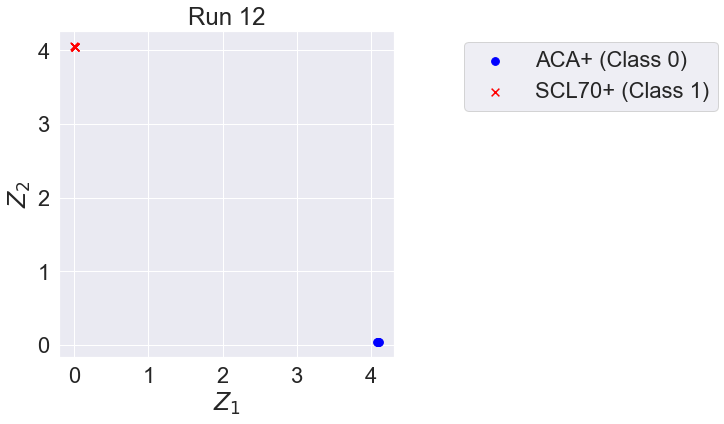

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 13
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 13

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.36408925 0.30503824 0.29528937 0.29471365]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.36932978 0.32764393 0.3008628  0.2937392 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.30240384 -0.29047582 -0.25136265 -0.2456317 ]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.32613498 -0.30872977 -0.27194518 -0.23344712]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2336 and ending loss of 1.6554, on epoch 400.
Starting loss of 2.2376 and ending loss of 1.6564, on epoch 400.
Starting loss of 2.2599 and ending loss of 1.6225, on epoch 400.
Starting loss of 2.2275 and ending loss of

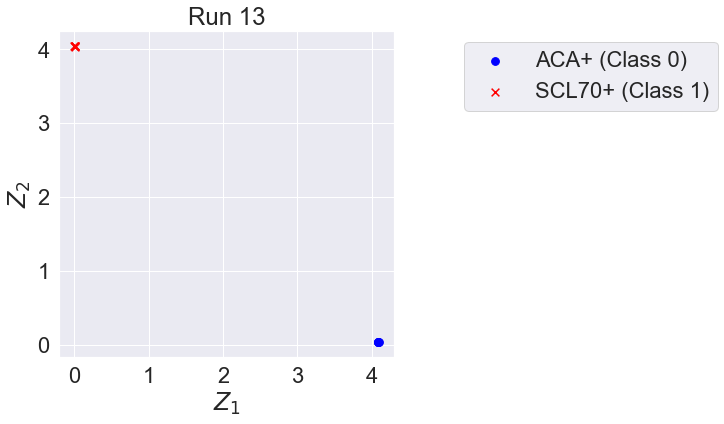

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 13
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 17

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.38448367 0.3474836  0.34138644 0.33457577]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.35797828 0.30542606 0.30289054 0.30146194]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.2570282  -0.22508201 -0.22007668 -0.2017108 ]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.34352434 -0.3340644  -0.3095075  -0.281493  ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2560 and ending loss of 1.6258, on epoch 400.
Starting loss of 2.2495 and ending loss of 1.6335, on epoch 400.
Starting loss of 2.2198 and ending loss of 0.0774, on epoch 999.
Run 14 now finished, with starting loss of

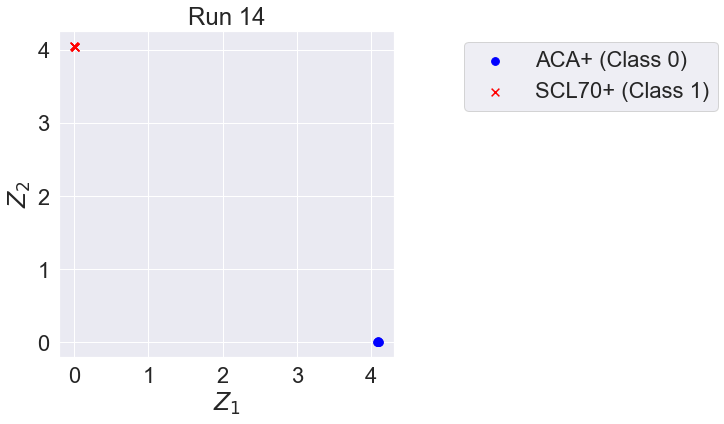

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 13
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 14
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 18

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3413862  0.2806418  0.27966553 0.26636168]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.41424638 0.3231862  0.28952342 0.27719134]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.31230387 -0.29858914 -0.2813594  -0.24671651]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.26893842 -0.2616267  -0.26070166 -0.24379101]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2285 and ending loss of 0.0783, on epoch 999.
Run 15 now finished, with starting loss of 2.2285 and ending loss of 0.0783, on epoch 999.
Total elapsed time: 1.1 sec.


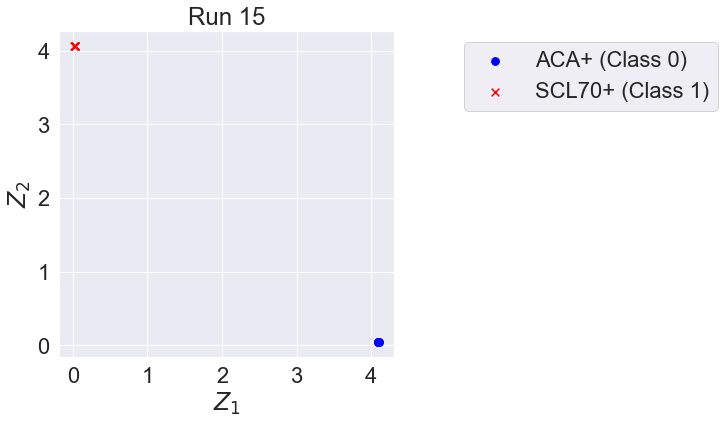

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 15

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.31617886 0.31477332 0.3075518  0.30423382]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.37661907 0.34760496 0.31482917 0.30428818]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.30929866 -0.2842297  -0.23359576 -0.22198915]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.30596834 -0.2953271  -0.25750872 -0.23611306]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2458 and ending loss of 1.6236, on epoch 400.
Starting loss of 2.2529 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2361 and ending loss of 1.6551, on epoch 400.
Starting loss of 2.2461 and ending loss of

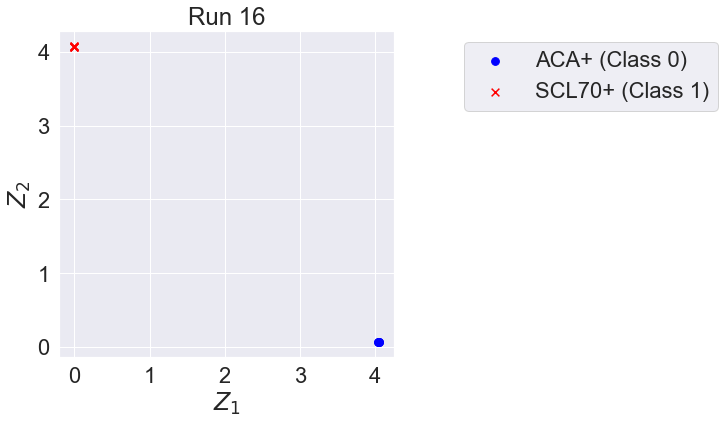

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 16

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3525537  0.33193636 0.31566724 0.31555808]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3337275  0.31887573 0.28580666 0.28553414]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.25140208 -0.22333227 -0.1706575  -0.16946813]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.30047888 -0.2500264  -0.22998285 -0.223614  ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2582 and ending loss of 0.0809, on epoch 999.
Run 17 now finished, with starting loss of 2.2582 and ending loss of 0.0809, on epoch 999.
Total elapsed time: 1.2 sec.


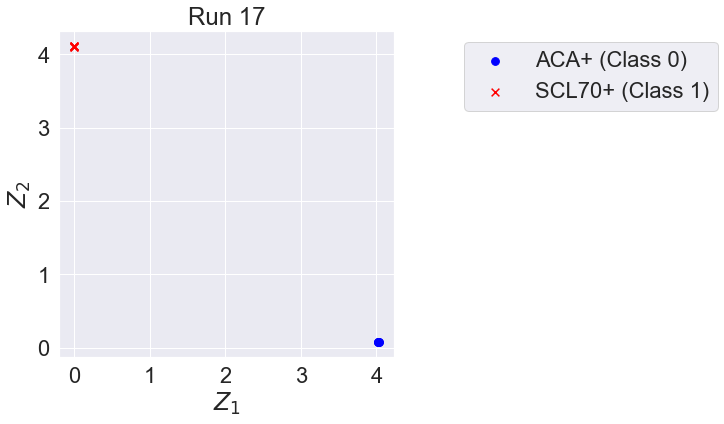

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 21
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 11
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 13
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 19

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.36493462 0.30956978 0.3083011  0.28888226]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.34355098 0.30906692 0.30617273 0.29988182]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.27831617 -0.2655966  -0.24641994 -0.24039836]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.30986887 -0.30001044 -0.27386752 -0.27376932]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2587 and ending loss of 0.0785, on epoch 999.
Run 18 now finished, with starting loss of 2.2587 and ending loss of 0.0785, on epoch 999.
Total elapsed time: 1.2 sec.


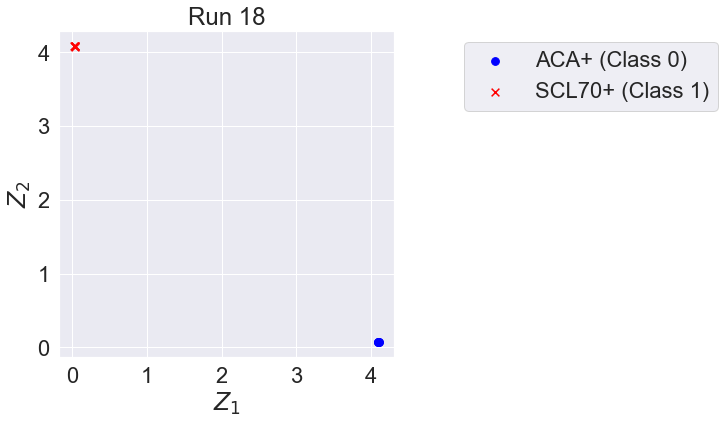

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 14

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3688808  0.3153869  0.29447454 0.28162652]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3476448  0.32838026 0.32142797 0.29205886]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.299516   -0.262997   -0.25658187 -0.25595444]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.29971948 -0.22402091 -0.21656756 -0.20711824]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2602 and ending loss of 0.0826, on epoch 999.
Run 19 now finished, with starting loss of 2.2602 and ending loss of 0.0826, on epoch 999.
Total elapsed time: 1.1 sec.


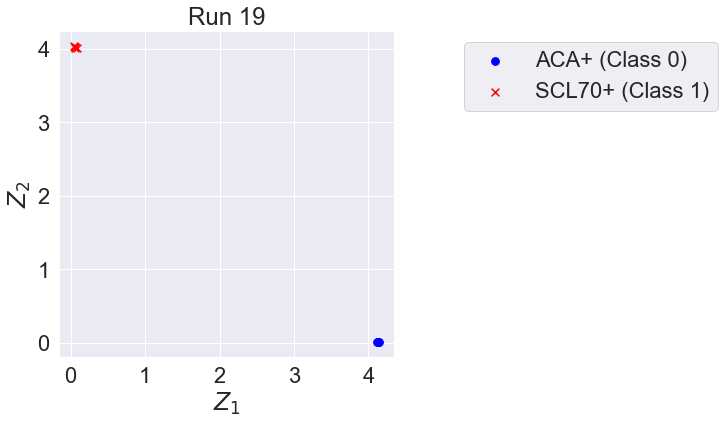

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 14

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.40451142 0.31017682 0.2978317  0.29269814]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.325565   0.31619248 0.31185067 0.29849672]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.31147277 -0.27078792 -0.24244496 -0.2139809 ]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.36498177 -0.27872926 -0.26631123 -0.25627795]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2469 and ending loss of 0.0798, on epoch 999.
Run 20 now finished, with starting loss of 2.2469 and ending loss of 0.0798, on epoch 999.
Total elapsed time: 1.1 sec.


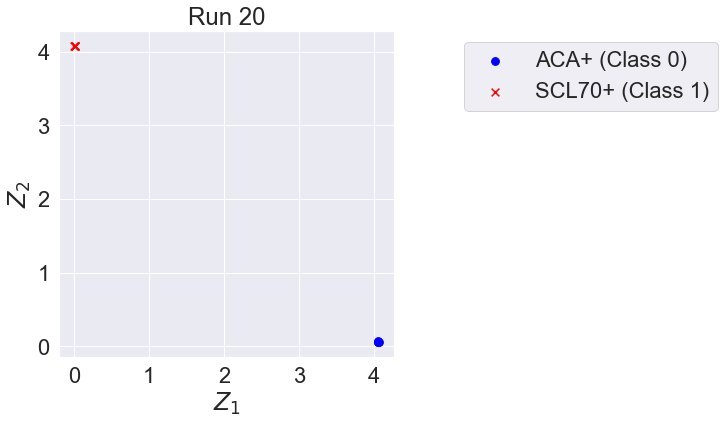

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 21
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 11

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3416148  0.31960985 0.29628155 0.2896083 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3553545  0.3532787  0.3262329  0.31381384]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.29357043 -0.27102324 -0.2611757  -0.25641575]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.31111056 -0.28083295 -0.2472875  -0.24278961]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2534 and ending loss of 1.6239, on epoch 400.
Starting loss of 2.2344 and ending loss of 1.6246, on epoch 400.
Starting loss of 2.2358 and ending loss of 0.0789, on epoch 999.
Run 21 now finished, with starting loss of

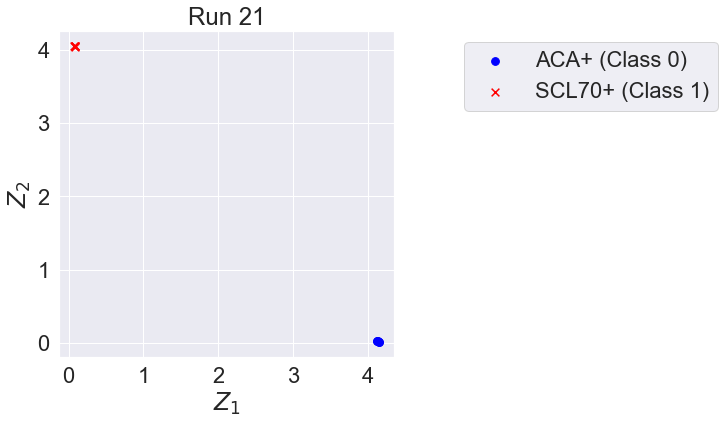

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 14

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.36065012 0.34828445 0.3020014  0.25271603]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.40346617 0.37589425 0.32768995 0.3263487 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.3112391  -0.30669963 -0.27680102 -0.2755503 ]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.2731057  -0.24361703 -0.23215689 -0.21348563]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2695 and ending loss of 0.0783, on epoch 999.
Run 22 now finished, with starting loss of 2.2695 and ending loss of 0.0783, on epoch 999.
Total elapsed time: 1.1 sec.


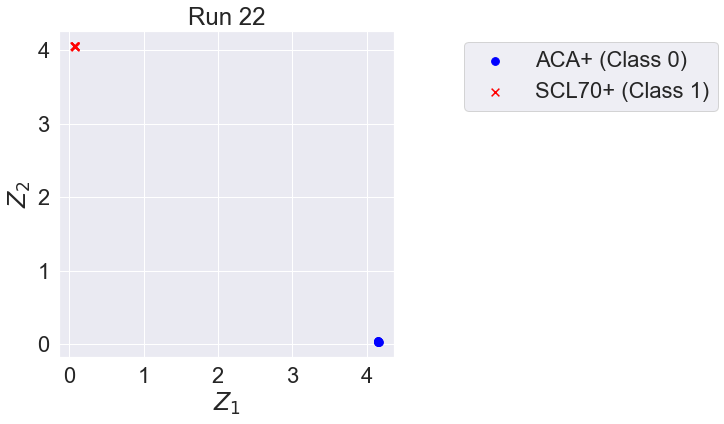

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 20
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 12
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 13
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 19

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3404562  0.326413   0.3157461  0.29779464]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.40245992 0.35082877 0.3072583  0.29637232]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.26701868 -0.2612919  -0.22716415 -0.17641349]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.31955075 -0.2581478  -0.250418   -0.24649319]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2343 and ending loss of 0.0791, on epoch 999.
Run 23 now finished, with starting loss of 2.2343 and ending loss of 0.0791, on epoch 999.
Total elapsed time: 1.1 sec.


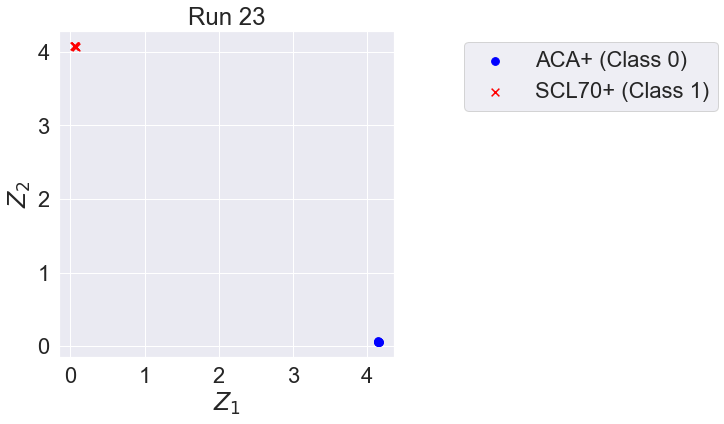

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 20
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 12

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.37713042 0.32823128 0.3281415  0.32804748]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.33086723 0.32913348 0.32510853 0.30186445]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.26892576 -0.26076818 -0.25600588 -0.23230127]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.30928445 -0.30005157 -0.2994861  -0.22729017]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2267 and ending loss of 0.0806, on epoch 999.
Run 24 now finished, with starting loss of 2.2267 and ending loss of 0.0806, on epoch 999.
Total elapsed time: 1.1 sec.


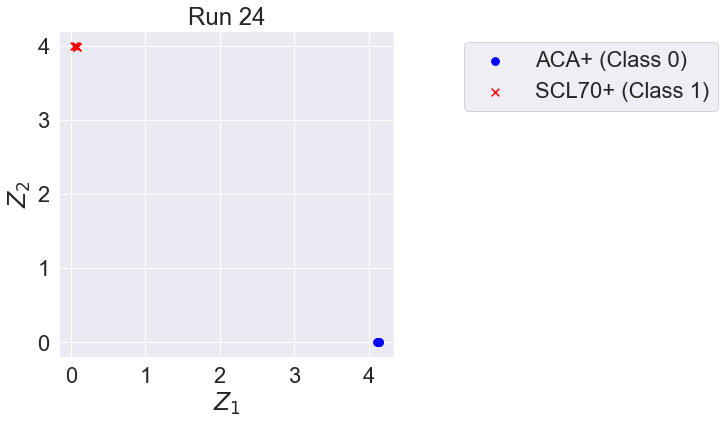

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 21
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 11

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.31364107 0.28059235 0.27543467 0.27049142]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.36316007 0.36166847 0.333747   0.33232778]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.29828006 -0.28992498 -0.28487062 -0.2690755 ]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.29912922 -0.25908524 -0.24660856 -0.14939478]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2419 and ending loss of 1.6295, on epoch 400.
Starting loss of 2.2306 and ending loss of 1.6188, on epoch 400.
Starting loss of 2.2361 and ending loss of 1.6253, on epoch 400.
Starting loss of 2.2611 and ending loss of

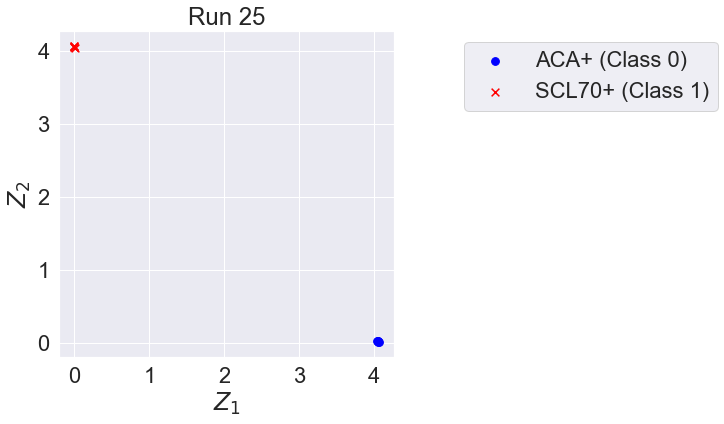

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 14

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.345139   0.31921408 0.30103546 0.30008388]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.37627366 0.37319154 0.32301643 0.31270456]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.3263304  -0.31068102 -0.2613547  -0.25242326]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.2941169  -0.24938469 -0.22869603 -0.17034717]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2533 and ending loss of 0.0792, on epoch 999.
Run 26 now finished, with starting loss of 2.2533 and ending loss of 0.0792, on epoch 999.
Total elapsed time: 1.1 sec.


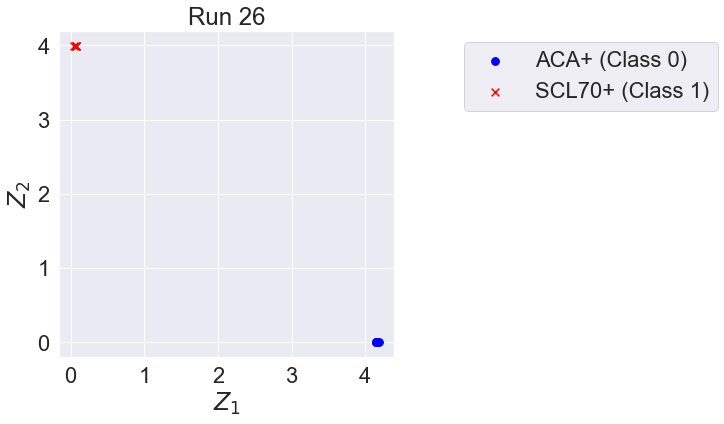

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 13
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 19
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 21
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 11

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.40275875 0.31782088 0.2962771  0.28858358]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3722369  0.34570548 0.33957446 0.29431635]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.2986394  -0.29822695 -0.28447303 -0.26796404]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.33749455 -0.27116254 -0.2467861  -0.23683722]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2407 and ending loss of 0.0770, on epoch 999.
Run 27 now finished, with starting loss of 2.2407 and ending loss of 0.0770, on epoch 999.
Total elapsed time: 1.1 sec.


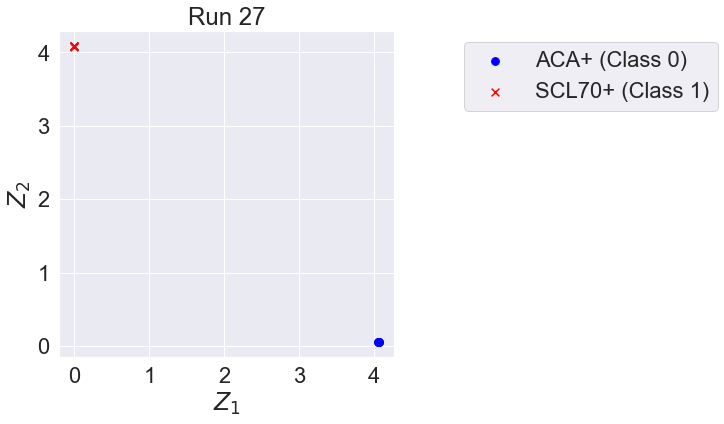

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 16

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3310547  0.2947489  0.2933345  0.28837982]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.38581502 0.3449976  0.31184605 0.29621333]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.2812178  -0.27573588 -0.26912528 -0.26471382]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.29530376 -0.27804223 -0.2753991  -0.2512679 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2558 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2546 and ending loss of 1.6237, on epoch 400.
Starting loss of 2.2361 and ending loss of 0.0878, on epoch 999.
Run 28 now finished, with starting loss of

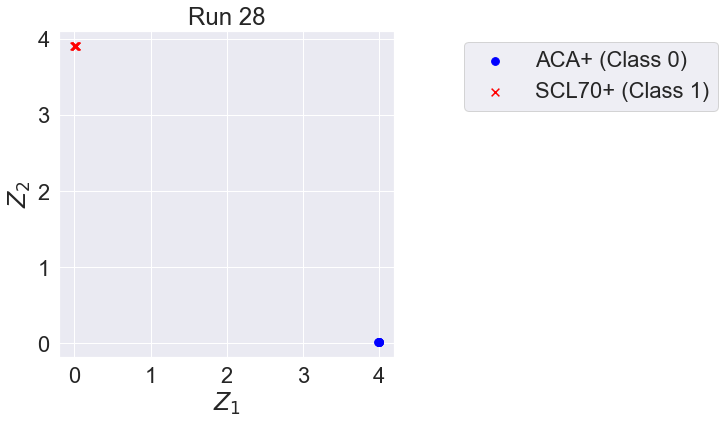

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 21
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 11

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3195165  0.27364346 0.2723451  0.2376749 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3439335  0.26755163 0.2506246  0.250043  ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.25565973 -0.24528812 -0.24524541 -0.24445611]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.32437092 -0.25303283 -0.14783795 -0.12462351]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2411 and ending loss of 0.0803, on epoch 999.
Run 29 now finished, with starting loss of 2.2411 and ending loss of 0.0803, on epoch 999.
Total elapsed time: 1.1 sec.


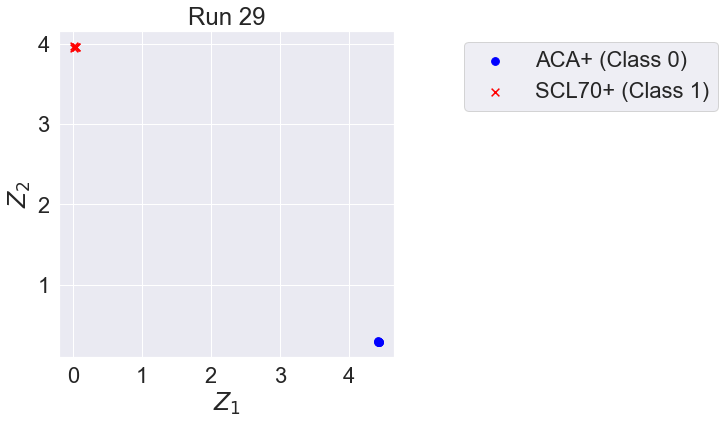

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 15

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.32763335 0.31266642 0.3064689  0.30341712]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.36201322 0.29730654 0.2507108  0.20264518]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.28157824 -0.26909244 -0.24540241 -0.2343686 ]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.31061053 -0.27808517 -0.27148548 -0.21948582]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2390 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2695 and ending loss of 0.0788, on epoch 999.
Run 30 now finished, with starting loss of 2.2695 and ending loss of 0.0788, on epoch 999.
Total elapsed ti

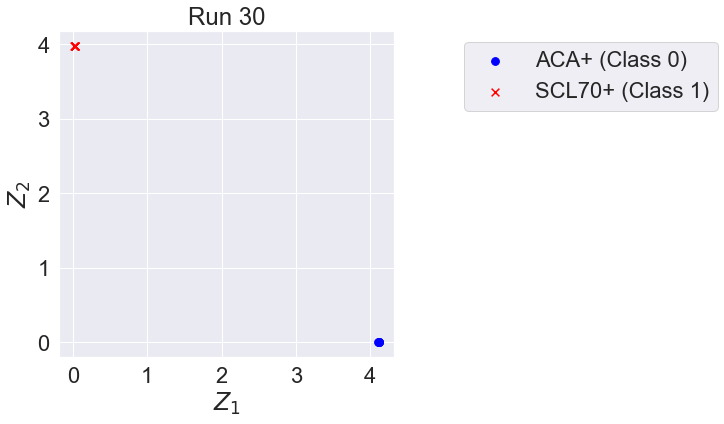

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 13

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3327864  0.3274762  0.32669935 0.31733617]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.38035464 0.3371045  0.3107628  0.30979812]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.23817012 -0.23728473 -0.22224662 -0.21871503]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.24936497 -0.23958606 -0.2322869  -0.22731233]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2318 and ending loss of 1.6183, on epoch 400.
Starting loss of 2.2361 and ending loss of 1.6750, on epoch 400.
Starting loss of 2.2283 and ending loss of 1.6218, on epoch 400.
Starting loss of 2.2318 and ending loss of

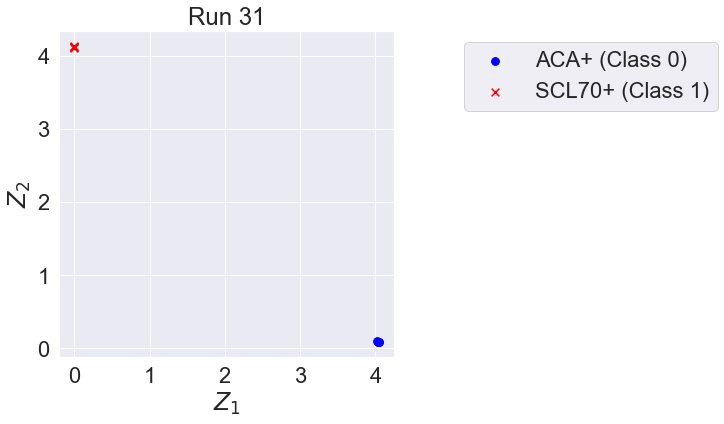

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 13
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 17

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.33158484 0.30286425 0.28529447 0.2816815 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.41385064 0.34363967 0.31928384 0.27880922]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.32172248 -0.3068486  -0.3037888  -0.24207954]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.2762424  -0.2655681  -0.2632769  -0.22361471]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2361 and ending loss of 0.0805, on epoch 999.
Run 32 now finished, with starting loss of 2.2361 and ending loss of 0.0805, on epoch 999.
Total elapsed time: 1.1 sec.


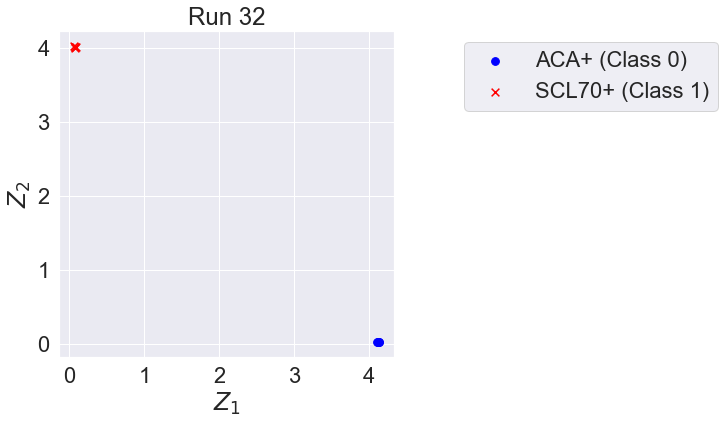

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 14
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 15

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.39528474 0.3737266  0.33705866 0.32727343]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3406447  0.2900453  0.27243114 0.26977357]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.25898635 -0.2559537  -0.23622473 -0.22810972]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.31652403 -0.30655363 -0.2946128  -0.2596985 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2057 and ending loss of 0.0770, on epoch 999.
Run 33 now finished, with starting loss of 2.2057 and ending loss of 0.0770, on epoch 999.
Total elapsed time: 1.2 sec.


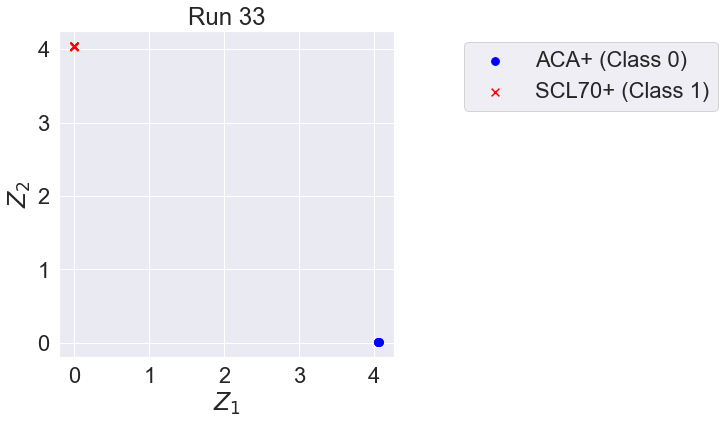

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 15

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.32211134 0.30869132 0.2956615  0.27759975]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3480111  0.34059405 0.3233984  0.31747067]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.2758345  -0.26617843 -0.265757   -0.25774056]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.25922948 -0.25905097 -0.24979141 -0.23661956]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2334 and ending loss of 0.0795, on epoch 999.
Run 34 now finished, with starting loss of 2.2334 and ending loss of 0.0795, on epoch 999.
Total elapsed time: 1.1 sec.


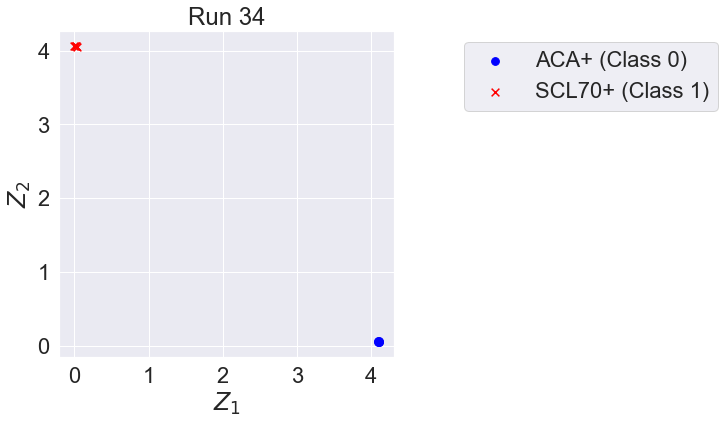

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 14
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 17

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3802517  0.32982236 0.31018412 0.30493122]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.35909295 0.2829356  0.26396197 0.2532884 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.23437075 -0.22213553 -0.21797274 -0.21077263]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.35272577 -0.30975154 -0.30059192 -0.29700387]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2471 and ending loss of 0.0808, on epoch 999.
Run 35 now finished, with starting loss of 2.2471 and ending loss of 0.0808, on epoch 999.
Total elapsed time: 1.1 sec.


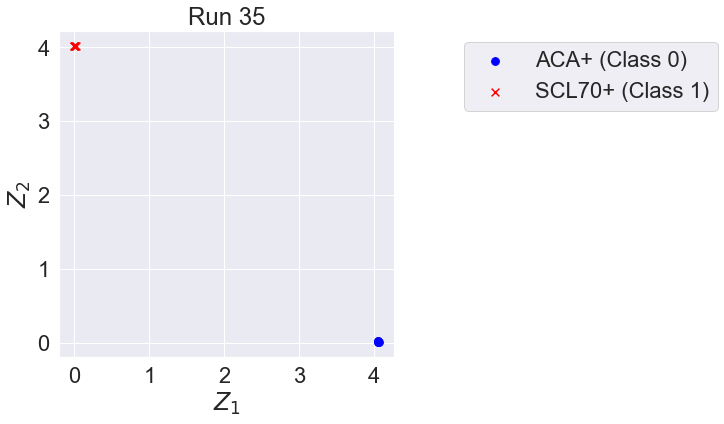

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 17

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.38686353 0.3237357  0.31223387 0.28280857]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3575219  0.32680234 0.2938944  0.2808985 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.25809366 -0.22716667 -0.22334266 -0.22253455]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.28697857 -0.2669551  -0.2661512  -0.22487052]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2825 and ending loss of 0.0784, on epoch 999.
Run 36 now finished, with starting loss of 2.2825 and ending loss of 0.0784, on epoch 999.
Total elapsed time: 1.1 sec.


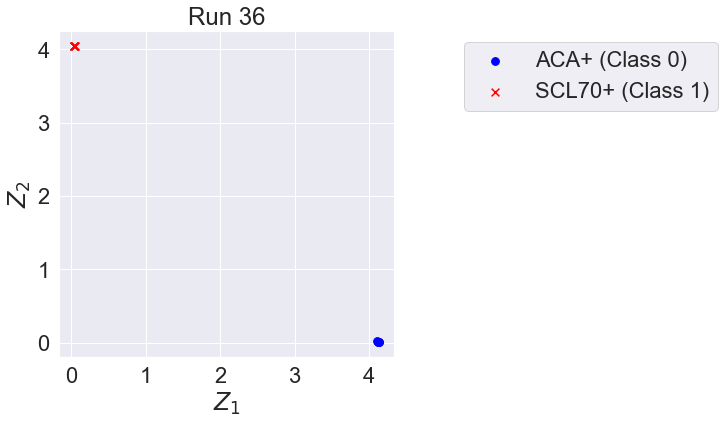

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 15

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.32788607 0.3234189  0.3219049  0.30065677]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.35004014 0.33676323 0.3325234  0.33133948]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.2730861  -0.26821154 -0.26311368 -0.26307228]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.2830839  -0.27886334 -0.24028061 -0.22780524]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2422 and ending loss of 0.0793, on epoch 999.
Run 37 now finished, with starting loss of 2.2422 and ending loss of 0.0793, on epoch 999.
Total elapsed time: 1.1 sec.


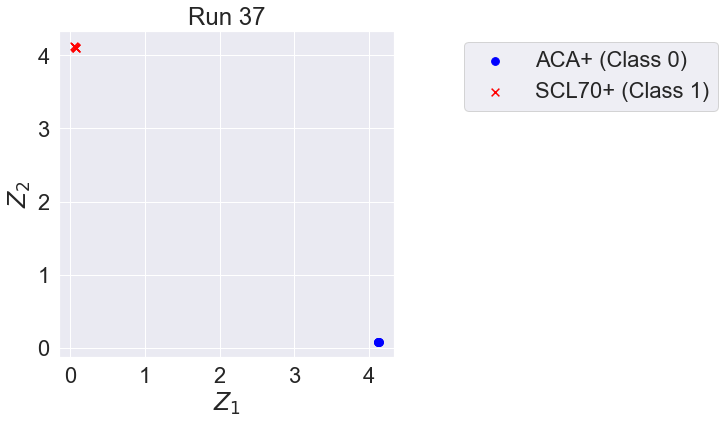

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 14

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.32472983 0.2925386  0.29228178 0.28453994]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.35211    0.31865156 0.30845463 0.30278742]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.27203572 -0.25929183 -0.23070398 -0.23053105]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.28820974 -0.28146622 -0.27312225 -0.2703554 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2397 and ending loss of 1.6280, on epoch 400.
Starting loss of 2.2471 and ending loss of 1.6191, on epoch 400.
Starting loss of 2.2360 and ending loss of 1.6294, on epoch 400.
Starting loss of 2.2589 and ending loss of

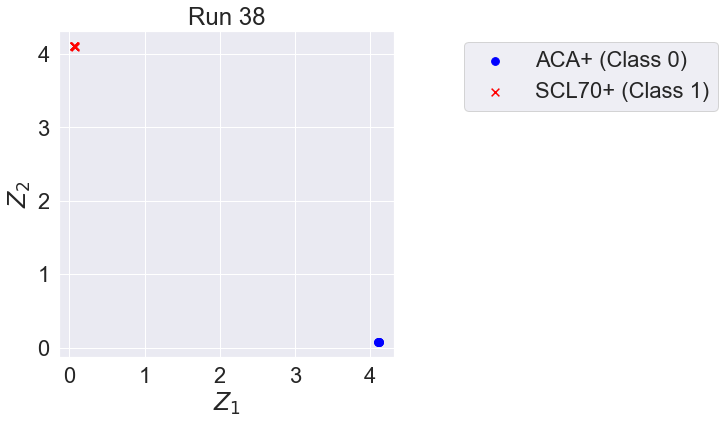

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 13
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 14
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 18

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3266389  0.30294985 0.29910606 0.29629856]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.39189878 0.3752921  0.34292793 0.3227435 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.32162583 -0.3027744  -0.2733153  -0.22715025]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.3038064  -0.2765185  -0.2632269  -0.24822497]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2573 and ending loss of 1.6130, on epoch 400.
Starting loss of 2.2494 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2420 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2490 and ending loss of

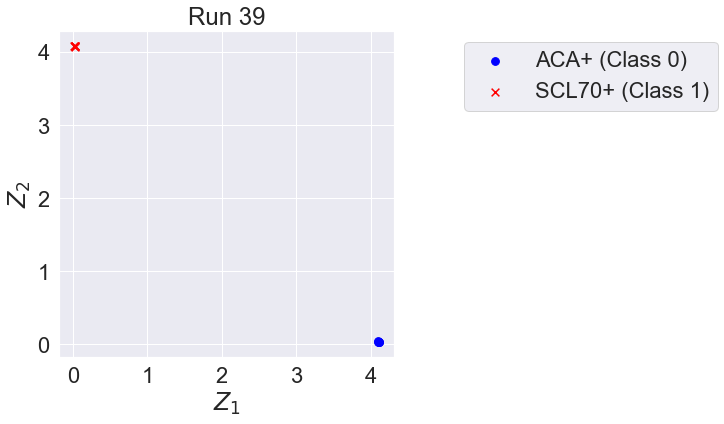

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 13
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 13
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 19

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.33597678 0.30450216 0.30287585 0.2978831 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3404579  0.33234715 0.32664725 0.32443857]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.3168891  -0.29328543 -0.25806162 -0.25630882]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.24974094 -0.2456307  -0.22712374 -0.21934943]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2568 and ending loss of 1.6310, on epoch 400.
Starting loss of 2.2342 and ending loss of 1.6252, on epoch 400.
Starting loss of 2.2361 and ending loss of 1.6251, on epoch 400.
Starting loss of 2.2517 and ending loss of

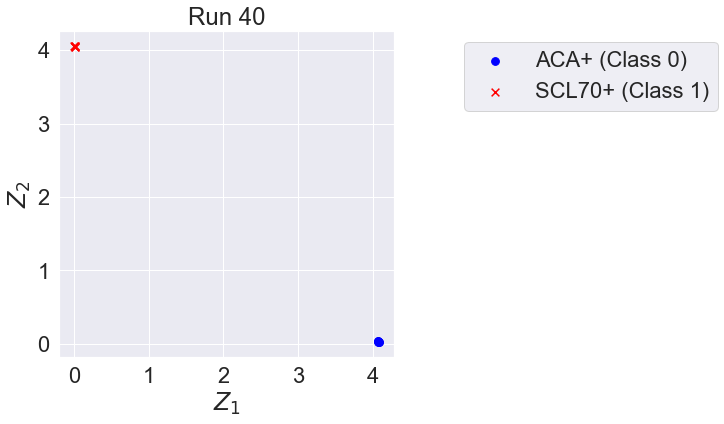

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 14
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 14

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3106969  0.30527267 0.30284193 0.294647  ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.34674367 0.34540367 0.3386413  0.32930204]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.33441806 -0.28134817 -0.24468777 -0.24199894]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.30051842 -0.2952464  -0.2660384  -0.23248902]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2268 and ending loss of 1.6218, on epoch 400.
Starting loss of 2.2361 and ending loss of 1.6376, on epoch 400.
Starting loss of 2.2349 and ending loss of 1.6254, on epoch 400.
Starting loss of 2.3006 and ending loss of

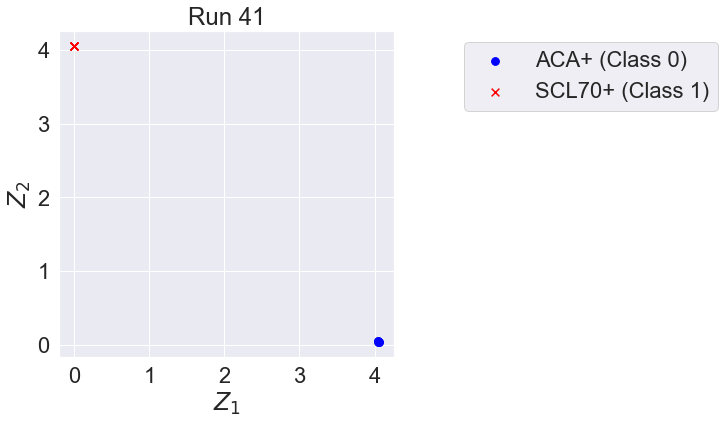

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 14
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 12
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 20

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.37212896 0.32968727 0.32871866 0.3096337 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.45461836 0.3119337  0.3079939  0.2610978 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.2891953  -0.26563993 -0.20623288 -0.19677128]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.2846312  -0.26355675 -0.25128224 -0.2477212 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2378 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2373 and ending loss of 1.6238, on epoch 400.
Starting loss of 2.2879 and ending loss of 1.6373, on epoch 400.
Starting loss of 2.2741 and ending loss of

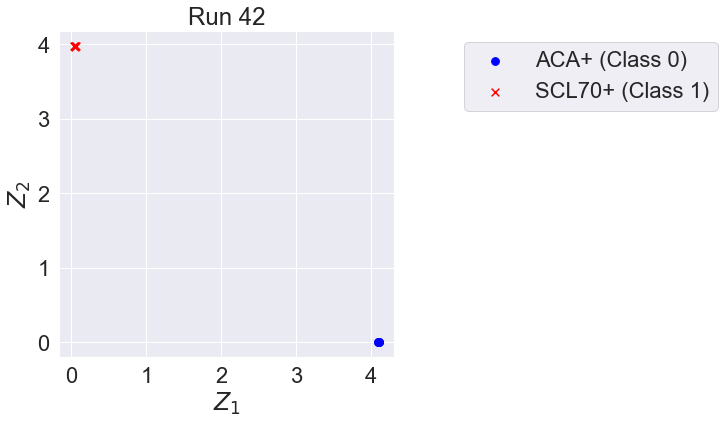

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 14

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.35395217 0.33457434 0.3123726  0.29646698]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.34369507 0.31095216 0.2880937  0.25283727]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.30064046 -0.29078233 -0.26913506 -0.23402165]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.31973472 -0.31615314 -0.3103356  -0.29026935]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2361 and ending loss of 1.6850, on epoch 400.
Starting loss of 2.2437 and ending loss of 1.6338, on epoch 400.
Starting loss of 2.2436 and ending loss of 1.6277, on epoch 400.
Starting loss of 2.2587 and ending loss of

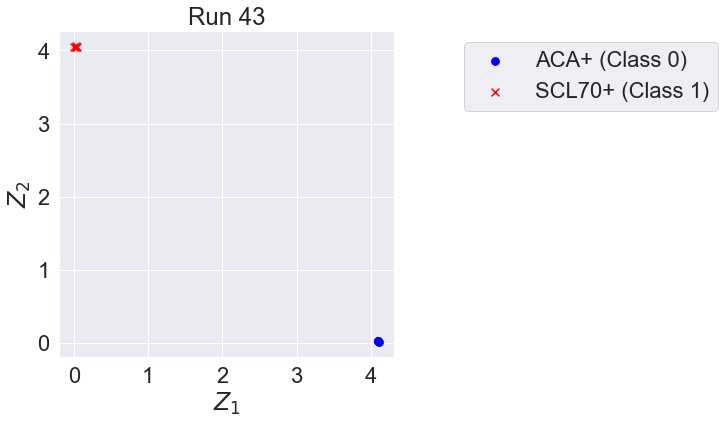

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 13

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.33700076 0.33020157 0.32102937 0.2935727 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.34270537 0.31733397 0.31566414 0.30395144]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.25813144 -0.25757387 -0.24843648 -0.22679913]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.2870505  -0.2837961  -0.26012135 -0.23489036]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2575 and ending loss of 0.0788, on epoch 999.
Run 44 now finished, with starting loss of 2.2575 and ending loss of 0.0788, on epoch 999.
Total elapsed time: 1.2 sec.


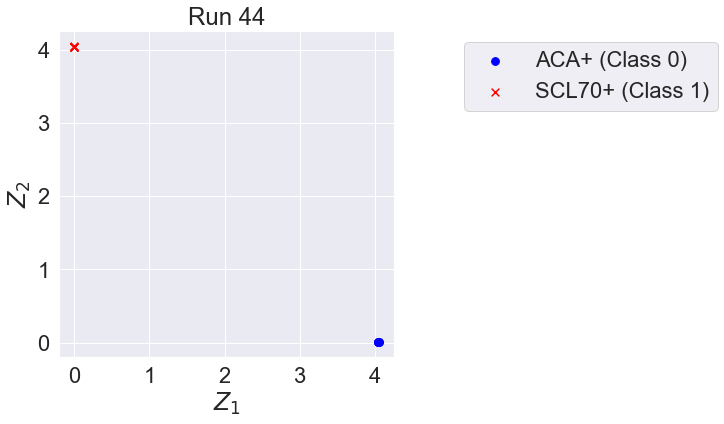

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 20
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 12

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.39194652 0.3105723  0.30995396 0.30312592]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.35374504 0.34845594 0.33618653 0.3308934 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.2688605  -0.26651686 -0.25609067 -0.23708771]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.29670373 -0.2912312  -0.283782   -0.24755087]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2472 and ending loss of 1.6182, on epoch 400.
Starting loss of 2.2497 and ending loss of 0.0780, on epoch 999.
Run 45 now finished, with starting loss of 2.2497 and ending loss of 0.0780, on epoch 999.
Total elapsed ti

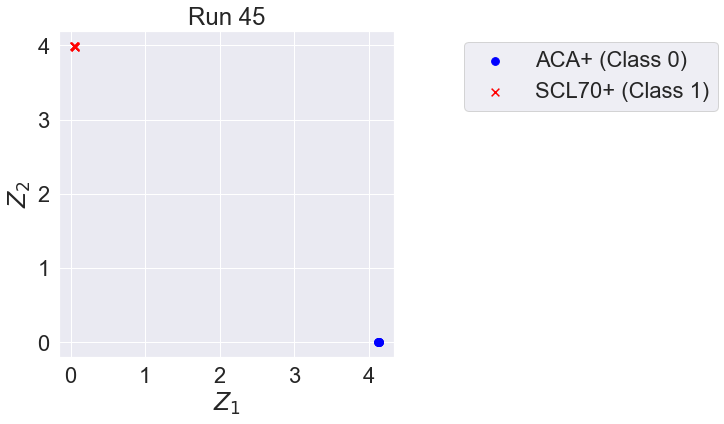

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 14

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.35753593 0.32710266 0.31954512 0.2872707 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.36147982 0.3075362  0.30262432 0.29690933]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.2913096  -0.2827788  -0.2689072  -0.26156345]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.25671467 -0.23523742 -0.22133766 -0.20591627]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2595 and ending loss of 0.0815, on epoch 999.
Run 46 now finished, with starting loss of 2.2595 and ending loss of 0.0815, on epoch 999.
Total elapsed time: 1.1 sec.


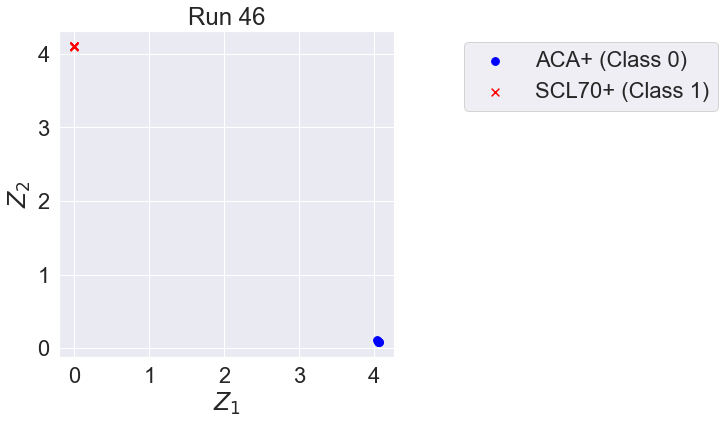

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 15

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3454441  0.34173223 0.3096852  0.30957234]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.31857938 0.31299648 0.3108279  0.3020444 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.30659875 -0.2634456  -0.26312092 -0.20264827]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.30934674 -0.29638186 -0.22365852 -0.2071204 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2119 and ending loss of 0.0775, on epoch 999.
Run 47 now finished, with starting loss of 2.2119 and ending loss of 0.0775, on epoch 999.
Total elapsed time: 1.1 sec.


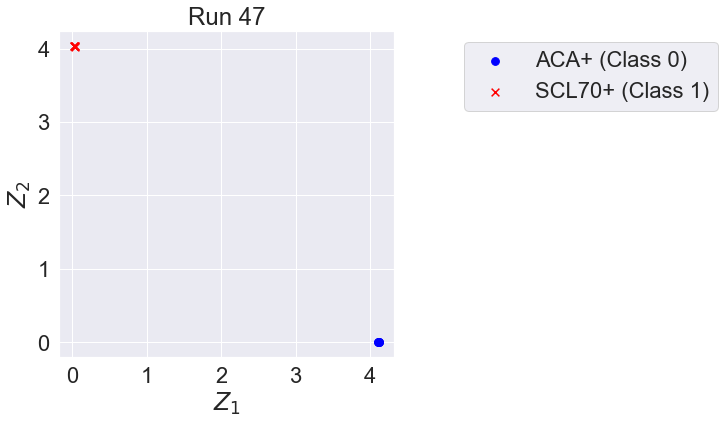

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 20
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 12

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3247789  0.31646565 0.30118302 0.2715948 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.33303708 0.32791057 0.32310477 0.305937  ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.31490275 -0.2835079  -0.27791643 -0.27423346]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.28909475 -0.22322896 -0.22017384 -0.20603146]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2527 and ending loss of 1.6213, on epoch 400.
Starting loss of 2.2346 and ending loss of 0.0800, on epoch 999.
Run 48 now finished, with starting loss of 2.2346 and ending loss of 0.0800, on epoch 999.
Total elapsed ti

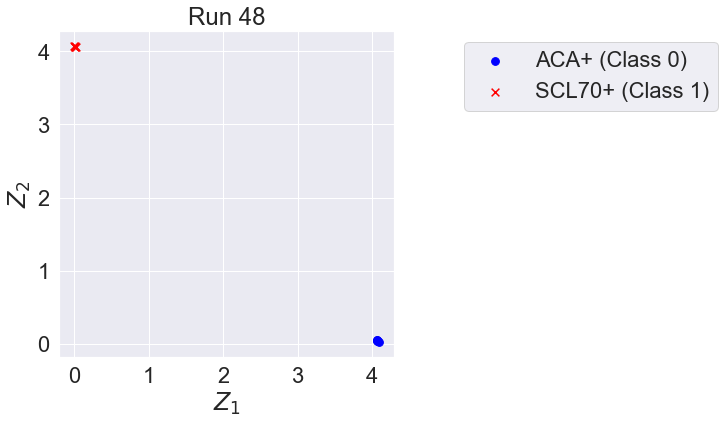

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 20
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 12

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.32769436 0.31060338 0.2931412  0.28839925]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.34272367 0.34055072 0.3178533  0.30272004]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.29762125 -0.28322443 -0.25937545 -0.25139856]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.29195815 -0.24261917 -0.23871535 -0.23557493]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2351 and ending loss of 1.6365, on epoch 400.
Starting loss of 2.2498 and ending loss of 1.6184, on epoch 400.
Starting loss of 2.2486 and ending loss of 0.0782, on epoch 999.
Run 49 now finished, with starting loss of

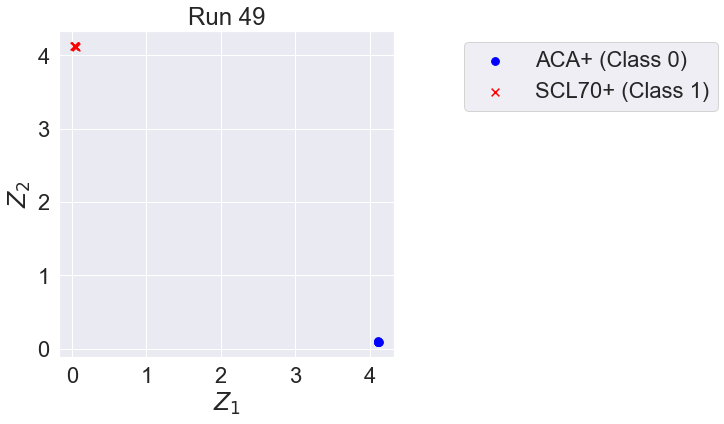

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 12
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 20
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 22
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 10

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.32522216 0.3116632  0.28911963 0.26816127]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.32025746 0.31502873 0.30628005 0.3057811 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.30705598 -0.27424443 -0.2549539  -0.24519645]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.28690875 -0.2740166  -0.21588153 -0.2154439 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2267 and ending loss of 0.0793, on epoch 999.
Run 50 now finished, with starting loss of 2.2267 and ending loss of 0.0793, on epoch 999.
Total elapsed time: 1.2 sec.


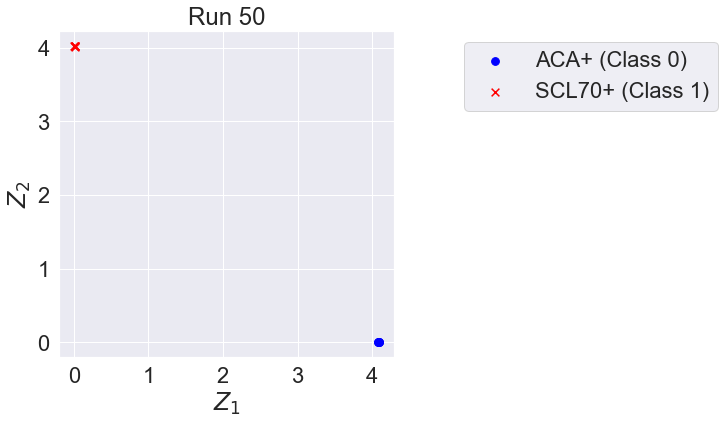

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 14

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3619279  0.30395457 0.27906576 0.27396405]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3575481  0.3285973  0.32708263 0.32287464]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.27961963 -0.26410368 -0.26372486 -0.24041836]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.31906953 -0.27164426 -0.25536373 -0.23817973]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2597 and ending loss of 0.0797, on epoch 999.
Run 51 now finished, with starting loss of 2.2597 and ending loss of 0.0797, on epoch 999.
Total elapsed time: 1.2 sec.


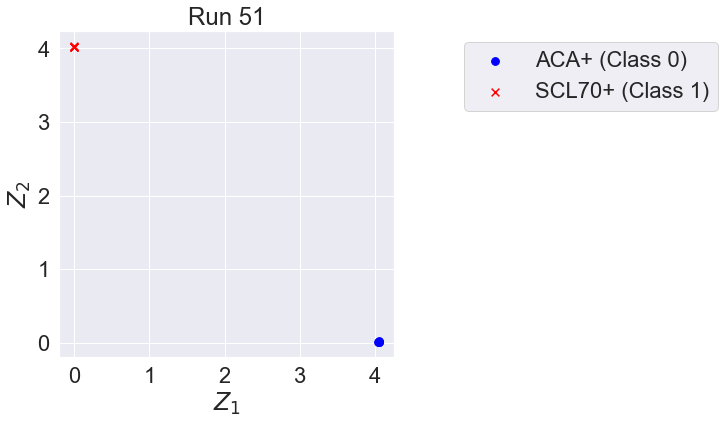

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 14
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 21
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 11

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.33138198 0.3009197  0.29818508 0.29667616]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.33475503 0.31686518 0.3163053  0.30799064]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.2878305  -0.28143787 -0.27492142 -0.2699819 ]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.2751195  -0.26780427 -0.2437505  -0.19391048]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2361 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2398 and ending loss of 0.0782, on epoch 999.
Run 52 now finished, with starting loss of 2.2398 and ending loss of 0.0782, on epoch 999.
Total elapsed ti

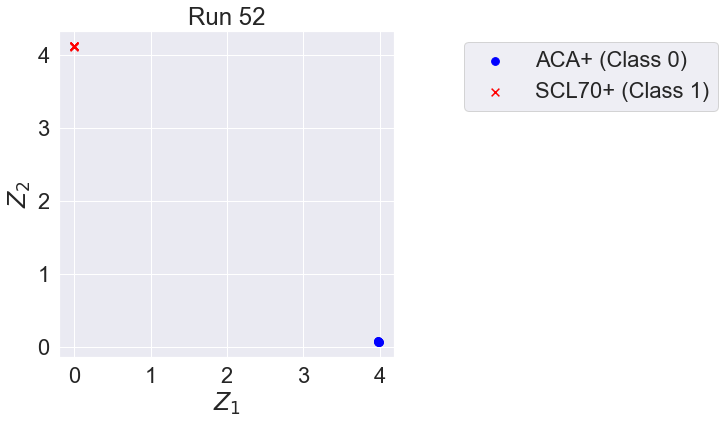

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 16

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.32359606 0.31214607 0.28218496 0.2774169 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.32796076 0.32450184 0.30444285 0.2936698 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.28747007 -0.26944757 -0.26818988 -0.2585175 ]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.2803304  -0.27380937 -0.26597443 -0.21377413]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2658 and ending loss of 0.0780, on epoch 999.
Run 53 now finished, with starting loss of 2.2658 and ending loss of 0.0780, on epoch 999.
Total elapsed time: 1.1 sec.


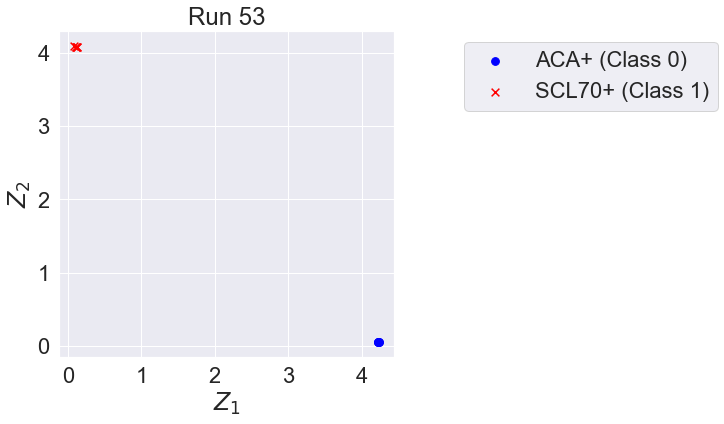

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 13
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 13
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 19

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.38212577 0.34224778 0.3344369  0.30160972]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.33296528 0.32649028 0.3109021  0.27440667]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.30347255 -0.26250115 -0.2358473  -0.23191231]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.32282147 -0.29917887 -0.28697053 -0.27346236]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2453 and ending loss of 0.0811, on epoch 999.
Run 54 now finished, with starting loss of 2.2453 and ending loss of 0.0811, on epoch 999.
Total elapsed time: 1.1 sec.


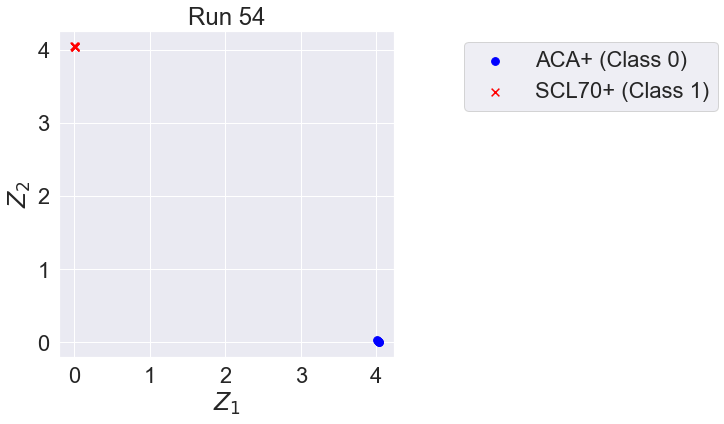

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 13
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 16

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.45504284 0.36376205 0.24988106 0.22691356]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3636334  0.3611792  0.32200983 0.3180186 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.34286484 -0.32732317 -0.2759192  -0.25208086]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.28180262 -0.25314343 -0.22314449 -0.2101224 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2361 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2386 and ending loss of 0.0802, on epoch 999.
Run 55 now finished, with starting loss of 2.2386 and ending loss of 0.0802, on epoch 999.
Total elapsed ti

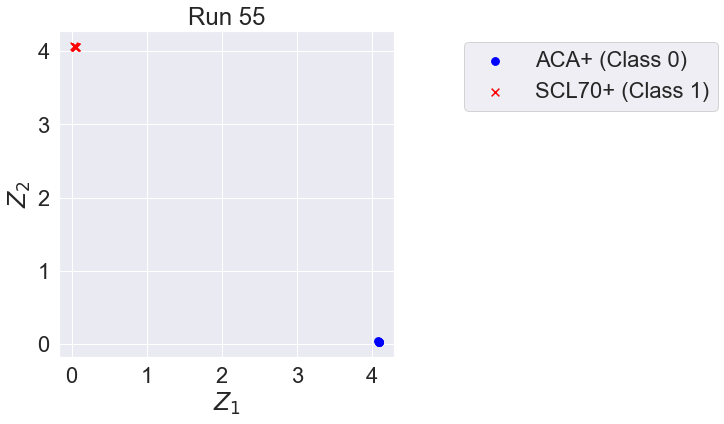

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 16

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.37229913 0.31483966 0.27748993 0.27680486]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.36235952 0.32672215 0.2855085  0.2835383 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.33490917 -0.24747731 -0.23560132 -0.23193033]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.3030499  -0.29545578 -0.20971155 -0.2081155 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2770 and ending loss of 0.0798, on epoch 999.
Run 56 now finished, with starting loss of 2.2770 and ending loss of 0.0798, on epoch 999.
Total elapsed time: 1.1 sec.


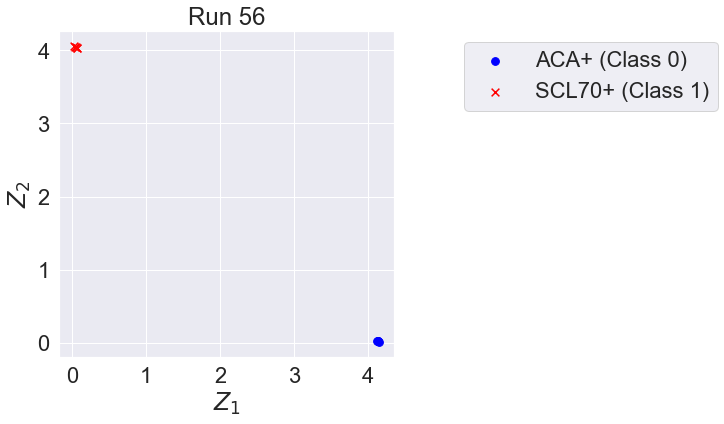

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 17

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.38236046 0.33215424 0.3102721  0.29663146]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.36738074 0.35037765 0.3348514  0.3232755 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.33078158 -0.27799088 -0.27463105 -0.25252968]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.29217184 -0.29190102 -0.29041678 -0.23088144]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2361 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.1993 and ending loss of 0.0793, on epoch 999.
Run 57 now finished, with starting loss of 2.1993 and ending loss of 0.0793, on epoch 999.
Total elapsed ti

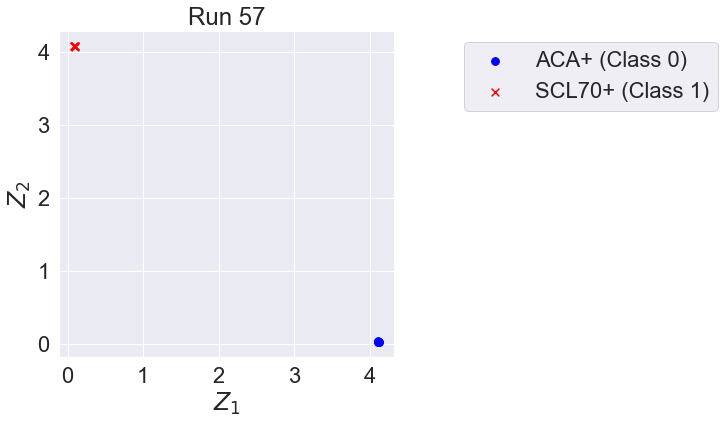

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 9
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 23
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 23
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 9

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.35443735 0.3246318  0.3018526  0.2873755 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.35108173 0.34846044 0.33572426 0.33244804]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.30782282 -0.3057718  -0.29428577 -0.2828404 ]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.27899155 -0.24832647 -0.22393417 -0.17522694]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2358 and ending loss of 1.6294, on epoch 400.
Starting loss of 2.2150 and ending loss of 0.0801, on epoch 999.
Run 58 now finished, with starting loss of 2.2150 and ending loss of 0.0801, on epoch 999.
Total elapsed time

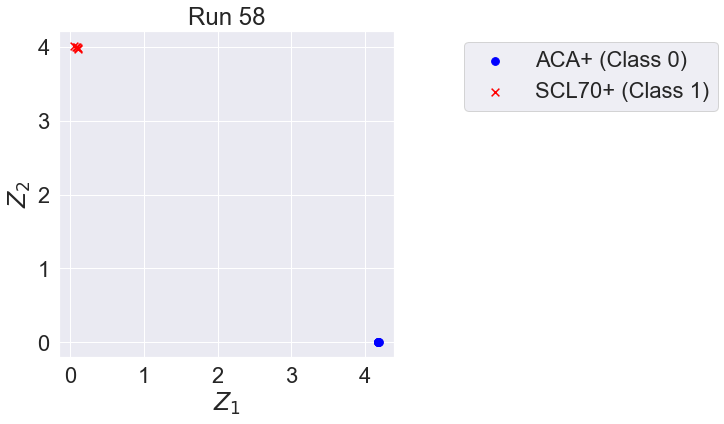

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 21
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 11
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 17

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.409168   0.33426166 0.331799   0.30402043]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.33096752 0.33057296 0.31455994 0.2663902 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.23653957 -0.20321678 -0.20096873 -0.18523939]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.36316234 -0.3131429  -0.2835387  -0.26046234]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2454 and ending loss of 0.0782, on epoch 999.
Run 59 now finished, with starting loss of 2.2454 and ending loss of 0.0782, on epoch 999.
Total elapsed time: 1.1 sec.


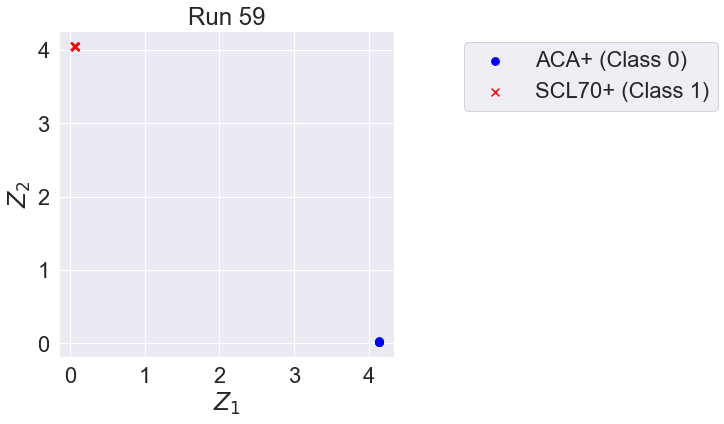

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 15

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.33107919 0.3084546  0.30783123 0.30355382]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.46178252 0.35829124 0.29245737 0.2812787 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.3678345  -0.24719809 -0.23987114 -0.21056622]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.2731491  -0.26461715 -0.25870275 -0.24375074]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2599 and ending loss of 0.0783, on epoch 999.
Run 60 now finished, with starting loss of 2.2599 and ending loss of 0.0783, on epoch 999.
Total elapsed time: 1.1 sec.


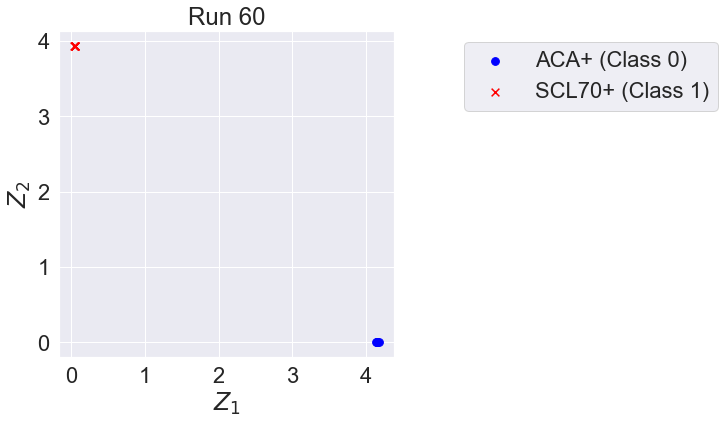

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 20
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 12
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 12
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 20

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.36482292 0.3449222  0.33734223 0.30428368]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.38489753 0.3752384  0.30780742 0.29146466]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.29442906 -0.28518948 -0.21100844 -0.1805525 ]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.300696   -0.2957653  -0.26597464 -0.26232576]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2239 and ending loss of 1.6357, on epoch 400.
Starting loss of 2.2506 and ending loss of 0.0804, on epoch 999.
Run 61 now finished, with starting loss of 2.2506 and ending loss of 0.0804, on epoch 999.
Total elapsed ti

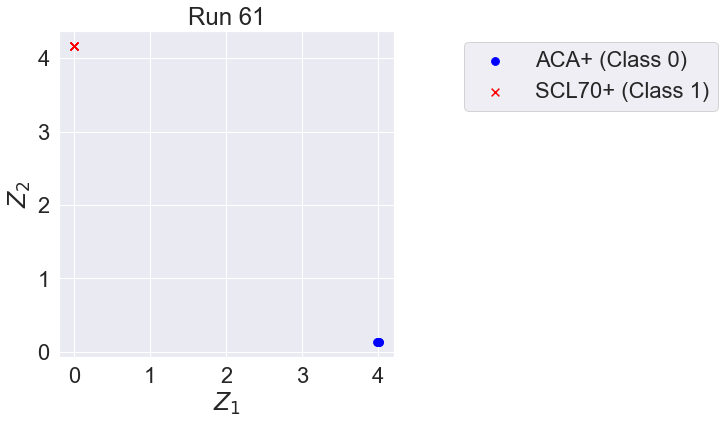

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 13
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 19
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 14

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3450469  0.34368393 0.31796905 0.30748412]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.33325413 0.3238301  0.31282687 0.31277984]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.33630705 -0.2943754  -0.2902178  -0.2473288 ]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.28905988 -0.2251429  -0.21644418 -0.20044774]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2322 and ending loss of 1.6191, on epoch 400.
Starting loss of 2.2417 and ending loss of 1.6229, on epoch 400.
Starting loss of 2.2346 and ending loss of 1.6217, on epoch 400.
Starting loss of 2.2340 and ending loss of

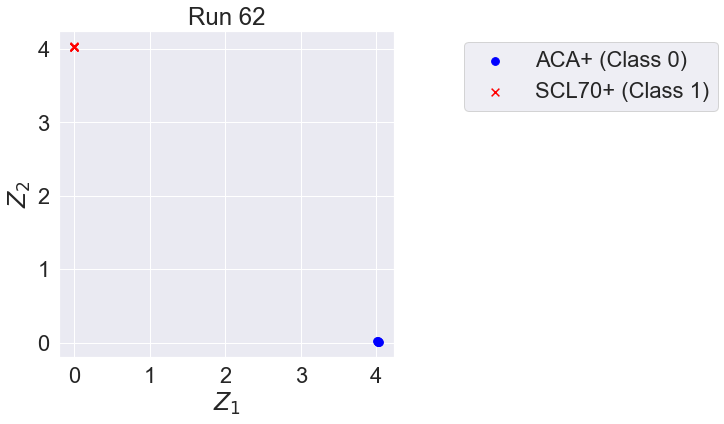

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 21
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 11
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 14
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 18

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.35392627 0.32609862 0.3004533  0.29191837]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.34519652 0.33009055 0.32469296 0.28174314]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.28119916 -0.27635762 -0.25496894 -0.21705616]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.3132717  -0.29766482 -0.29659602 -0.2449488 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2385 and ending loss of 0.0791, on epoch 999.
Run 63 now finished, with starting loss of 2.2385 and ending loss of 0.0791, on epoch 999.
Total elapsed time: 1.1 sec.


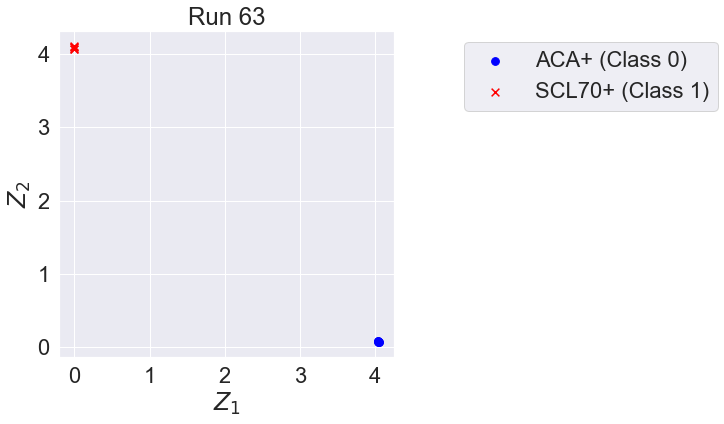

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 14
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 20
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 12

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.35954174 0.32537964 0.3183045  0.31722116]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.39847684 0.3872181  0.3522199  0.2726488 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.29181406 -0.26437798 -0.25560093 -0.24196588]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.3345154  -0.31421962 -0.30660924 -0.23293935]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.3150 and ending loss of 0.0771, on epoch 999.
Run 64 now finished, with starting loss of 2.3150 and ending loss of 0.0771, on epoch 999.
Total elapsed time: 1.1 sec.


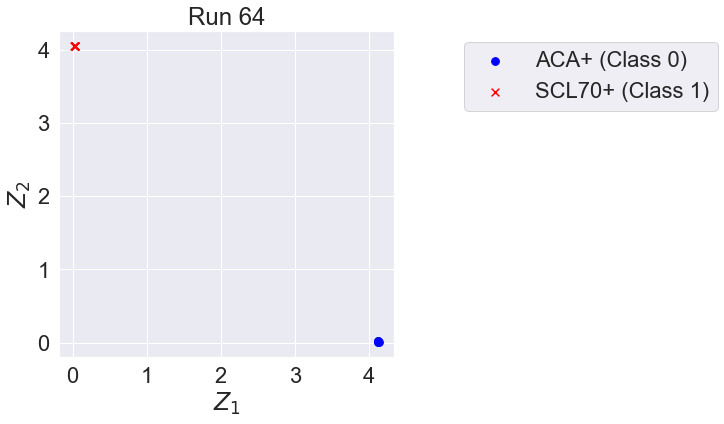

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 15

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.32305816 0.30822542 0.30815548 0.30458212]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.354944   0.33362046 0.32463887 0.3175501 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.3039407  -0.30096638 -0.27466848 -0.2687441 ]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.24889928 -0.24024235 -0.2348697  -0.22132087]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2361 and ending loss of 1.6532, on epoch 400.
Starting loss of 2.2361 and ending loss of 0.0813, on epoch 999.
Run 65 now finished, with starting loss of 2.2361 and ending loss of 0.0813, on epoch 999.
Total elapsed ti

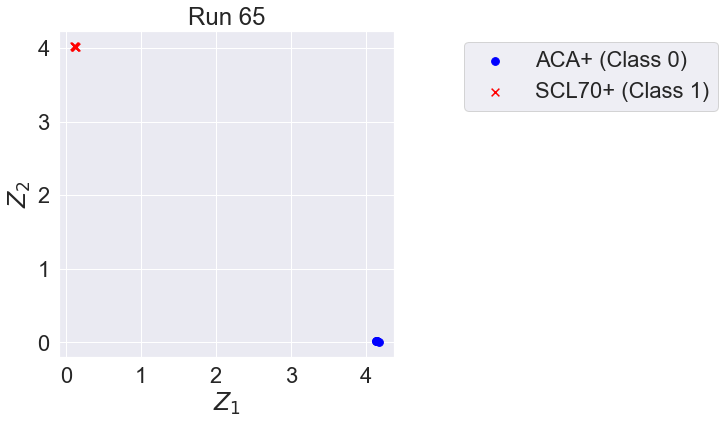

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 16

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.4069057  0.29027218 0.28280914 0.2807781 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3655475  0.34421235 0.30061445 0.2969662 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.28979737 -0.26682138 -0.24236514 -0.23149775]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.25619704 -0.23620342 -0.23213674 -0.19942985]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2165 and ending loss of 0.0783, on epoch 999.
Run 66 now finished, with starting loss of 2.2165 and ending loss of 0.0783, on epoch 999.
Total elapsed time: 1.1 sec.


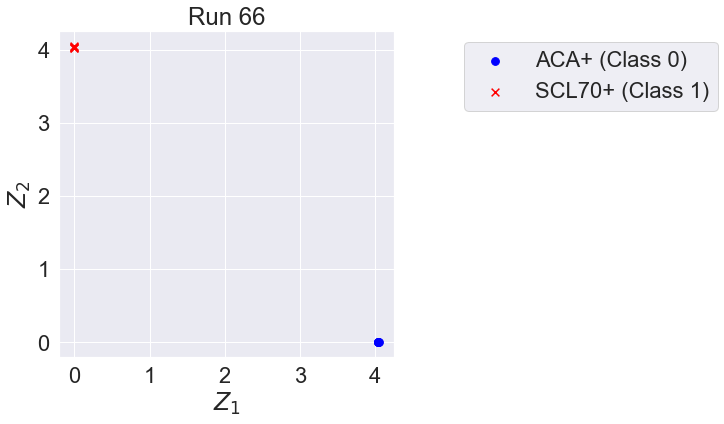

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 21
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 11
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 14
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 18

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.34481272 0.3270322  0.30577102 0.27255616]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.31805113 0.31655544 0.30966726 0.30264664]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.2975243  -0.27479264 -0.24999511 -0.16680087]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.30073866 -0.27123743 -0.25984883 -0.23783459]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2416 and ending loss of 0.0807, on epoch 999.
Run 67 now finished, with starting loss of 2.2416 and ending loss of 0.0807, on epoch 999.
Total elapsed time: 1.1 sec.


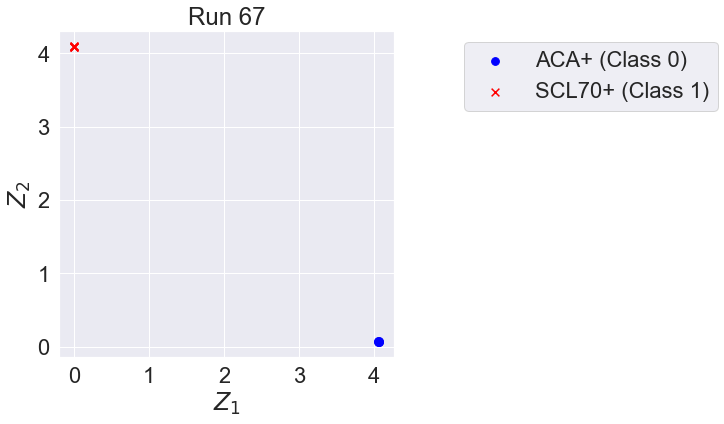

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 13

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.40477407 0.3418094  0.31723565 0.30706093]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.33084375 0.3174984  0.29932937 0.29412904]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.29302984 -0.29213226 -0.257574   -0.2556488 ]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.31950286 -0.30236357 -0.24465248 -0.2286471 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2548 and ending loss of 0.0804, on epoch 999.
Run 68 now finished, with starting loss of 2.2548 and ending loss of 0.0804, on epoch 999.
Total elapsed time: 1.1 sec.


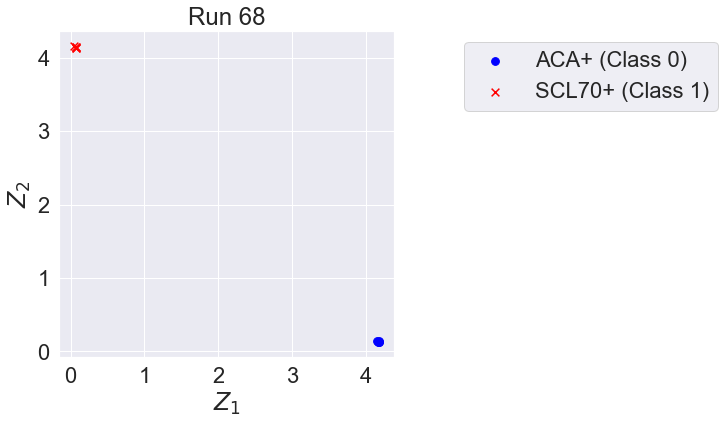

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 14
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 15

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.34048948 0.33407918 0.33175176 0.3267901 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.34942573 0.33654347 0.32722527 0.32123038]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.2933427  -0.26344723 -0.20709713 -0.19768976]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.29596254 -0.29059026 -0.2903066  -0.27328217]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2361 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2521 and ending loss of 0.0797, on epoch 999.
Run 69 now finished, with starting loss of 2.2521 and ending loss of 0.0797, on epoch 999.
Total elapsed ti

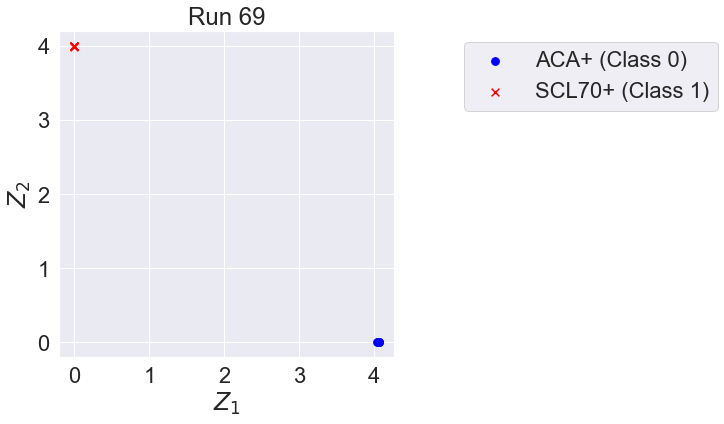

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 13
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 16

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.35621828 0.31589976 0.3066213  0.29232192]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.34450954 0.32976228 0.3233188  0.32000858]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.30803874 -0.25755906 -0.25527346 -0.24220392]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.29892522 -0.2906271  -0.27364203 -0.23647617]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2278 and ending loss of 1.6131, on epoch 400.
Starting loss of 2.2348 and ending loss of 0.0796, on epoch 999.
Run 70 now finished, with starting loss of 2.2348 and ending loss of 0.0796, on epoch 999.
Total elapsed ti

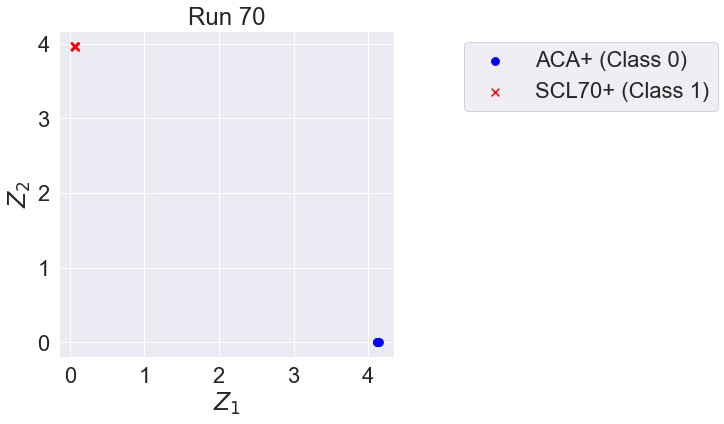

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 20
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 12
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 16

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3405631  0.32305616 0.29526585 0.2938924 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.33533767 0.32149532 0.31595427 0.3002671 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.29723924 -0.2944949  -0.29069898 -0.2837896 ]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.29809257 -0.28947213 -0.2645942  -0.24410821]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2355 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2556 and ending loss of 0.0789, on epoch 999.
Run 71 now finished, with starting loss of 2.2556 and ending loss of 0.0789, on epoch 999.
Total elapsed ti

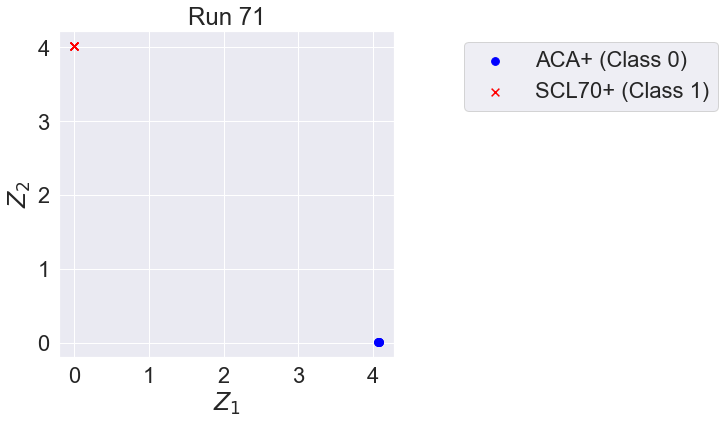

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 13
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 17

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3644956  0.35476604 0.33714804 0.2980055 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3240761  0.3156295  0.2928205  0.29061773]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.30215374 -0.28128207 -0.24941178 -0.21312481]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.32839626 -0.2913793  -0.27384928 -0.2725133 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2243 and ending loss of 0.0786, on epoch 999.
Run 72 now finished, with starting loss of 2.2243 and ending loss of 0.0786, on epoch 999.
Total elapsed time: 1.1 sec.


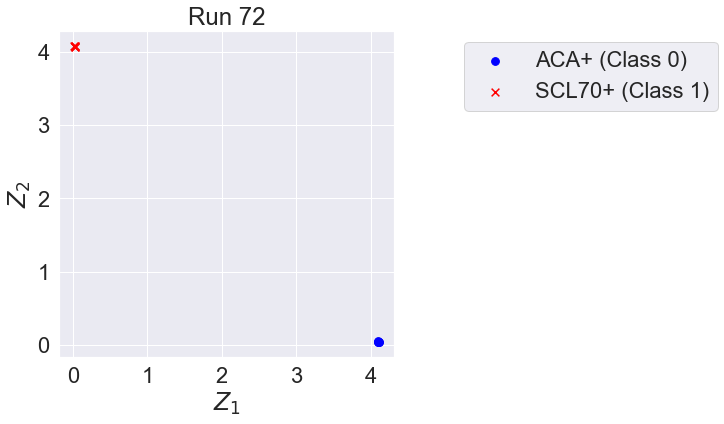

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 15

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.33274478 0.3238948  0.31893745 0.30901796]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3524094  0.31272826 0.31003633 0.3022978 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.25477841 -0.25373673 -0.2227902  -0.19709916]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.30569682 -0.2733872  -0.25388905 -0.23742294]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2227 and ending loss of 0.0810, on epoch 999.
Run 73 now finished, with starting loss of 2.2227 and ending loss of 0.0810, on epoch 999.
Total elapsed time: 1.1 sec.


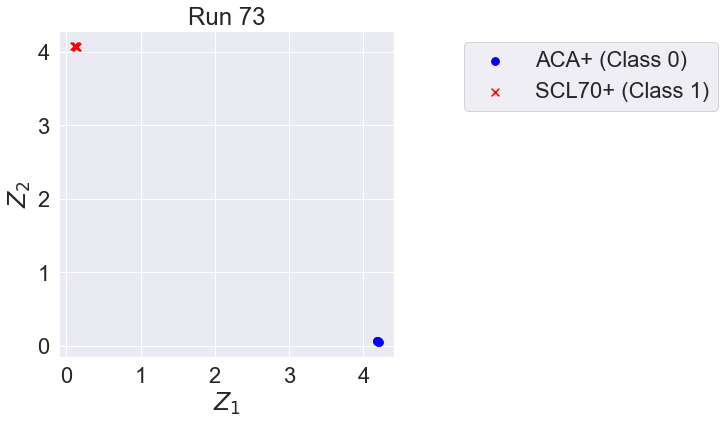

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 13

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.32829386 0.3091031  0.30277073 0.29344144]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.34752586 0.3197788  0.29399726 0.2932043 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.28534567 -0.2726706  -0.27115193 -0.25174144]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.28196982 -0.27315474 -0.24573538 -0.22754827]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2415 and ending loss of 1.6280, on epoch 400.
Starting loss of 2.2565 and ending loss of 0.0777, on epoch 999.
Run 74 now finished, with starting loss of 2.2565 and ending loss of 0.0777, on epoch 999.
Total elapsed ti

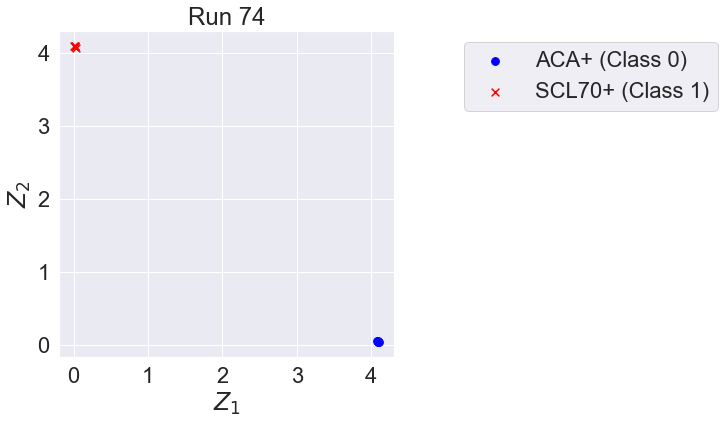

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 14
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 16

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3506329  0.33370608 0.32981065 0.31248167]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.32121348 0.29878083 0.2912579  0.28148782]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.24021962 -0.23559892 -0.21788427 -0.18599255]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.2914534  -0.26993138 -0.26245815 -0.25077447]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.3040 and ending loss of 0.0787, on epoch 999.
Run 75 now finished, with starting loss of 2.3040 and ending loss of 0.0787, on epoch 999.
Total elapsed time: 1.1 sec.


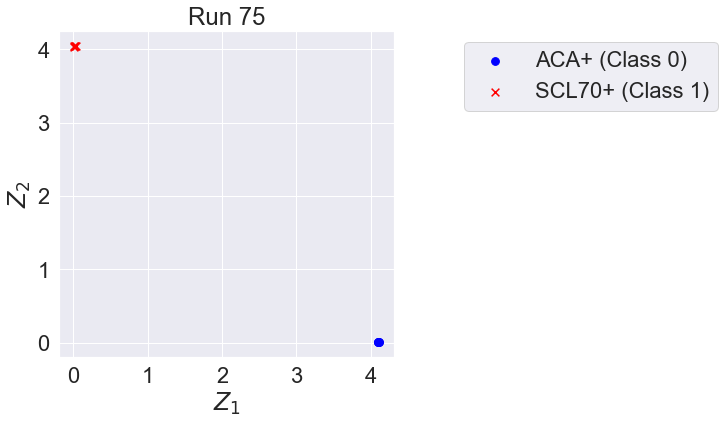

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 13
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 14
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 18

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.33640137 0.33141363 0.31320378 0.2991666 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.38999844 0.35530362 0.30804446 0.29329693]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.32197368 -0.3089612  -0.19960006 -0.1570873 ]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.2760764  -0.27457565 -0.23898898 -0.23561944]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2693 and ending loss of 0.0796, on epoch 999.
Run 76 now finished, with starting loss of 2.2693 and ending loss of 0.0796, on epoch 999.
Total elapsed time: 1.1 sec.


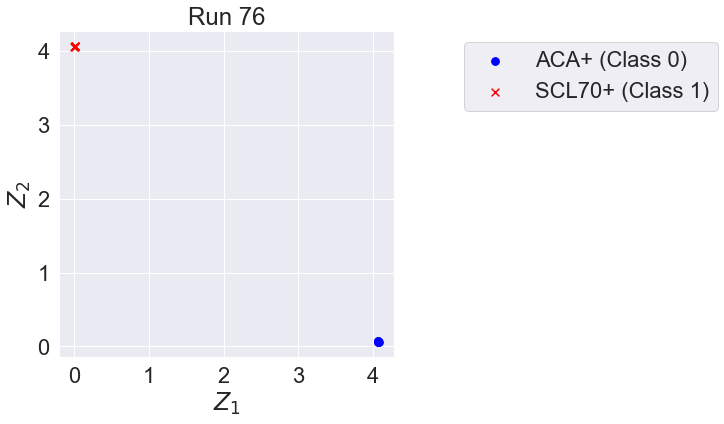

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 13
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 17

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3648268  0.33032888 0.30908448 0.2731286 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.34774268 0.3474559  0.34616    0.32572052]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.33117777 -0.2925505  -0.28394216 -0.25978956]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.2581433  -0.24097614 -0.23629768 -0.19946182]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2573 and ending loss of 1.6250, on epoch 400.
Starting loss of 2.2278 and ending loss of 0.0810, on epoch 999.
Run 77 now finished, with starting loss of 2.2278 and ending loss of 0.0810, on epoch 999.
Total elapsed ti

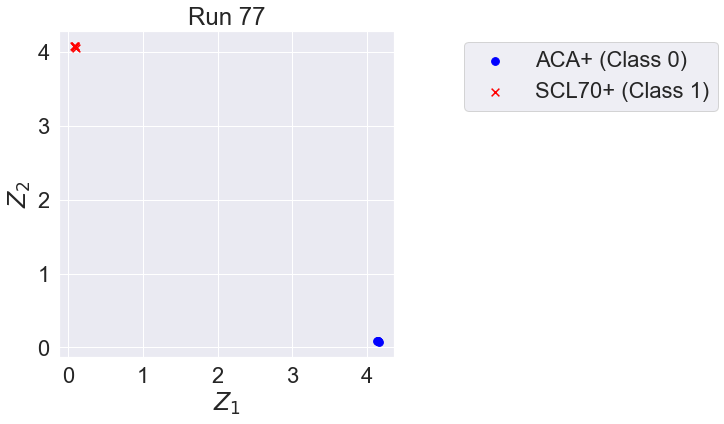

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 21
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 11
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 17

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.32521263 0.30067044 0.29009655 0.2836902 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.41636637 0.3507705  0.34703672 0.31968653]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.3424001  -0.3204807  -0.26086044 -0.25515902]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.29790732 -0.28616908 -0.2743852  -0.25893846]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2336 and ending loss of 1.6343, on epoch 400.
Starting loss of 2.2550 and ending loss of 1.6196, on epoch 400.
Starting loss of 2.2361 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2352 and ending loss of

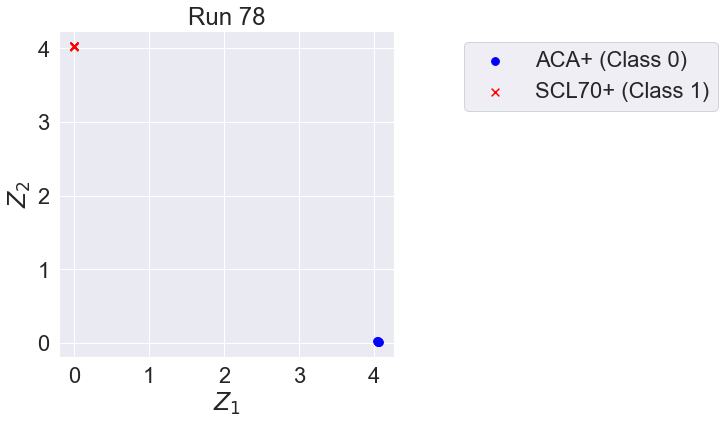

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 14
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 17

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.37323838 0.35396072 0.33870295 0.3245419 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.35556987 0.29016712 0.2832847  0.2718531 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.28509852 -0.2771762  -0.22910802 -0.20339523]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.3325752  -0.33100432 -0.324109   -0.28364527]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2647 and ending loss of 1.6281, on epoch 400.
Starting loss of 2.2482 and ending loss of 1.6359, on epoch 400.
Starting loss of 2.2597 and ending loss of 0.0820, on epoch 999.
Run 79 now finished, with starting loss of

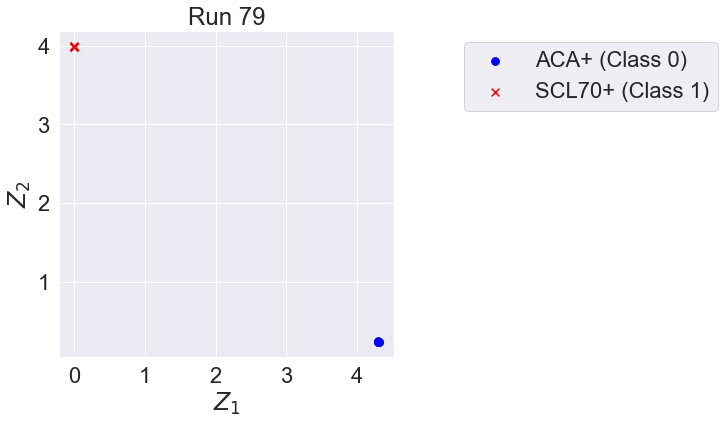

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 14
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 16

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3332471  0.3280745  0.31701392 0.31625468]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.36178914 0.35273892 0.3185689  0.24359064]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.29055044 -0.2800036  -0.2581983  -0.24119802]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.35777447 -0.31633112 -0.23114502 -0.21816409]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2552 and ending loss of 1.6465, on epoch 400.
Starting loss of 2.2301 and ending loss of 1.6204, on epoch 400.
Starting loss of 2.2458 and ending loss of 0.0789, on epoch 999.
Run 80 now finished, with starting loss of

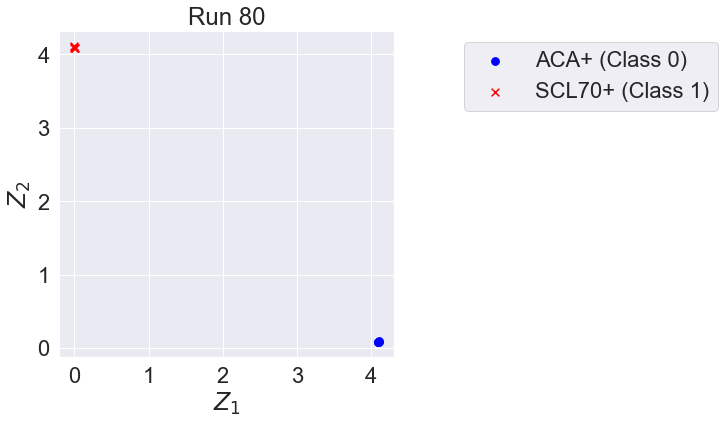

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 14

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.4240963  0.37351856 0.2975026  0.28116804]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3382768  0.33529225 0.3239366  0.29471916]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.24400254 -0.23767047 -0.23492488 -0.19516462]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.37112483 -0.33803955 -0.2928581  -0.23864873]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2460 and ending loss of 1.6279, on epoch 400.
Starting loss of 2.2292 and ending loss of 1.6182, on epoch 400.
Starting loss of 2.2370 and ending loss of 0.0797, on epoch 999.
Run 81 now finished, with starting loss of

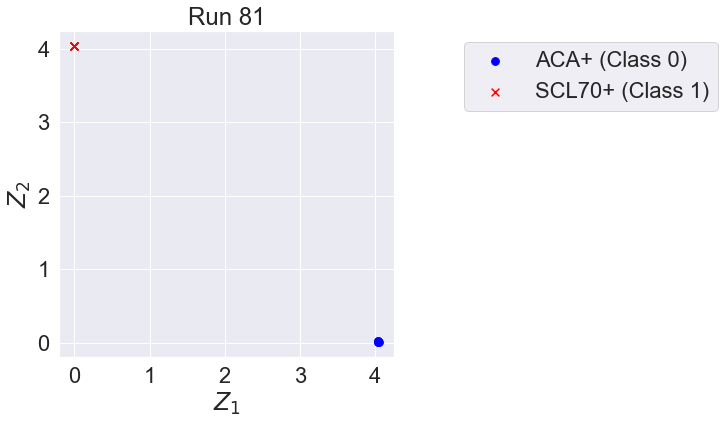

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 21
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 11
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 13
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 19

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.35498852 0.34171474 0.3215723  0.30589226]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3373942  0.33719143 0.3324308  0.2968321 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.30819362 -0.27579725 -0.25548926 -0.23227519]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.31019452 -0.29474804 -0.29247802 -0.2870853 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2361 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2502 and ending loss of 0.0803, on epoch 999.
Run 82 now finished, with starting loss of 2.2502 and ending loss of 0.0803, on epoch 999.
Total elapsed ti

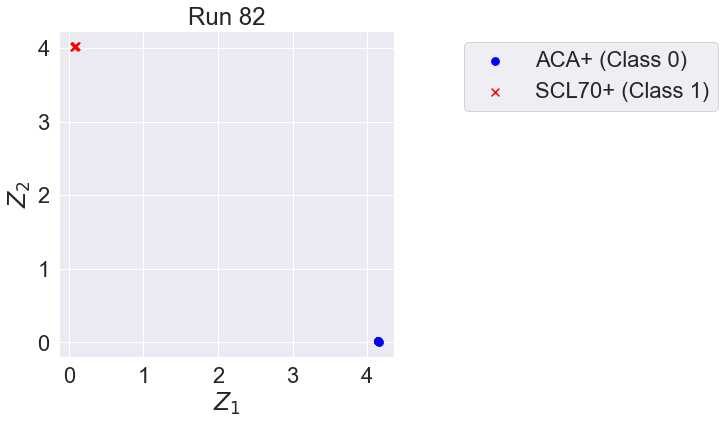

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 13

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3209119  0.31053376 0.29076484 0.25086284]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.37230137 0.36336106 0.34693685 0.3176498 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.2864457  -0.2817948  -0.2816561  -0.27432117]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.26322567 -0.24926905 -0.2256322  -0.20600982]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2545 and ending loss of 1.6167, on epoch 400.
Starting loss of 2.2472 and ending loss of 1.6281, on epoch 400.
Starting loss of 2.2689 and ending loss of 0.0805, on epoch 999.
Run 83 now finished, with starting loss of

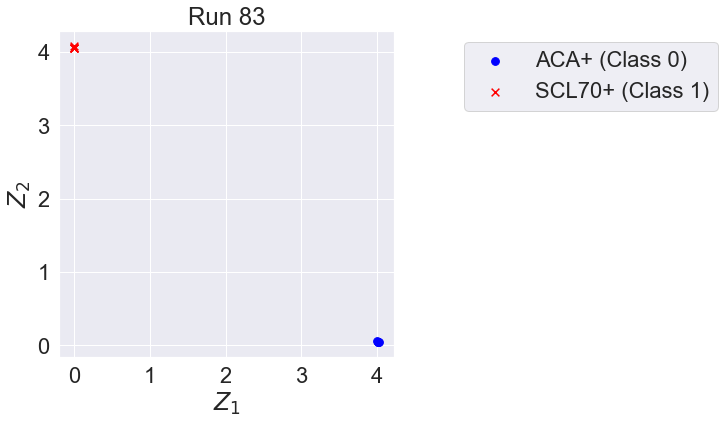

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 14
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 13

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.38820758 0.34097338 0.33045664 0.28782347]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.34139496 0.34085017 0.31188074 0.27240202]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.28265187 -0.28190693 -0.27204168 -0.26357058]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.3293578  -0.2908019  -0.28166026 -0.25242022]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2722 and ending loss of 0.0793, on epoch 999.
Run 84 now finished, with starting loss of 2.2722 and ending loss of 0.0793, on epoch 999.
Total elapsed time: 1.1 sec.


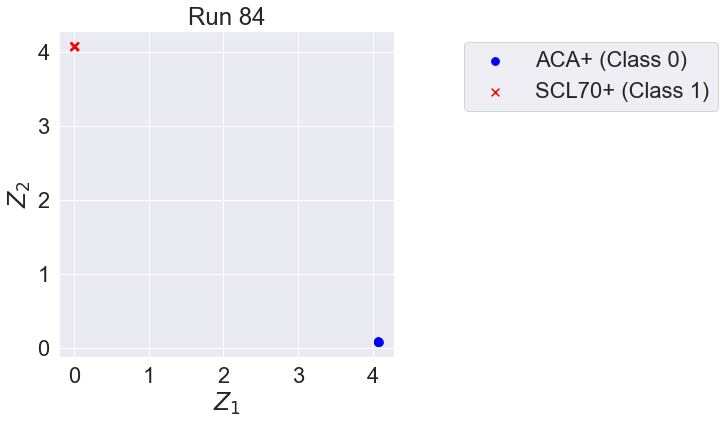

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 14
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 15

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.40486008 0.29373294 0.29060856 0.28454667]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.39053538 0.3582082  0.34797755 0.290331  ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.29364547 -0.2607523  -0.21420386 -0.21379793]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.3623993  -0.31717408 -0.2474044  -0.2353741 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2321 and ending loss of 0.0793, on epoch 999.
Run 85 now finished, with starting loss of 2.2321 and ending loss of 0.0793, on epoch 999.
Total elapsed time: 1.1 sec.


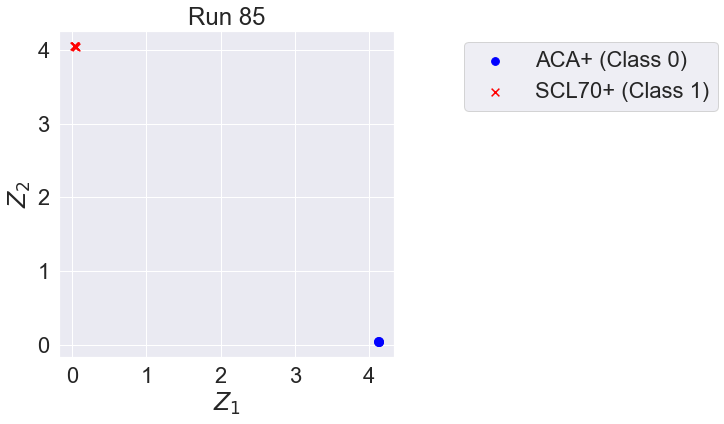

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 14

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3397793  0.33853683 0.33701733 0.32914263]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.29968742 0.29145166 0.27916455 0.26954272]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.2916388  -0.26874283 -0.2643074  -0.24577291]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.3369066  -0.29010332 -0.27481815 -0.24624963]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2560 and ending loss of 1.6159, on epoch 400.
Starting loss of 2.2405 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2361 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2360 and ending loss of

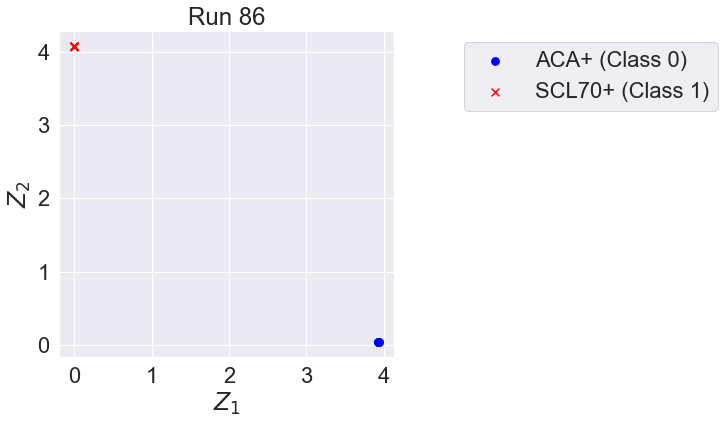

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 13
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 16

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.4154508  0.28104752 0.24487464 0.19684778]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.40855804 0.3771993  0.33725104 0.31635264]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.37974122 -0.37918255 -0.3590614  -0.30762345]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.28969815 -0.28716362 -0.25185096 -0.24104498]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2461 and ending loss of 1.6256, on epoch 400.
Starting loss of 2.2623 and ending loss of 1.6361, on epoch 400.
Starting loss of 2.2361 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2514 and ending loss of

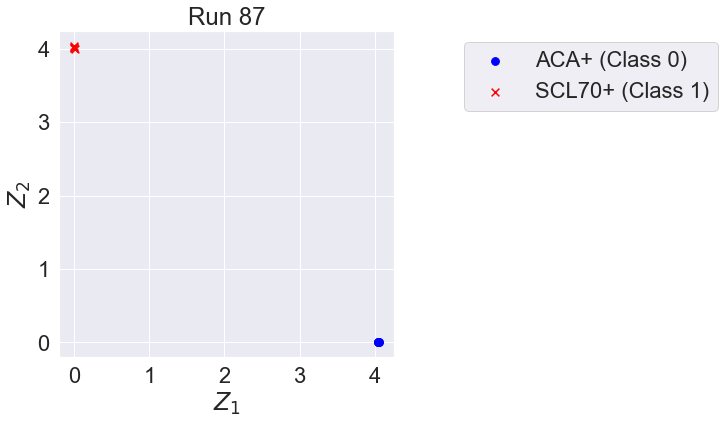

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 15

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.35781714 0.31695718 0.29653683 0.29267913]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3615042  0.35730448 0.3044294  0.30438614]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.30212337 -0.28534696 -0.27839965 -0.25858423]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.2760379  -0.26694795 -0.2660485  -0.25111443]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2368 and ending loss of 0.0785, on epoch 999.
Run 88 now finished, with starting loss of 2.2368 and ending loss of 0.0785, on epoch 999.
Total elapsed time: 1.1 sec.


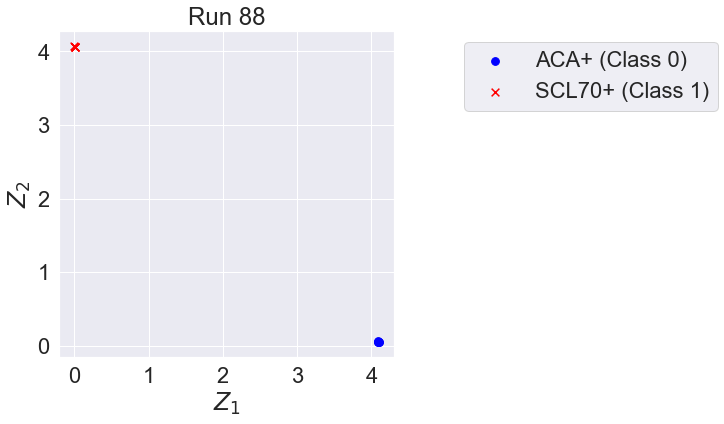

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 22
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 10

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.37755993 0.37246287 0.32337227 0.29554227]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.35411656 0.29523492 0.29265982 0.28513086]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.31180087 -0.3106182  -0.27486715 -0.2591939 ]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.32624182 -0.31108463 -0.27975488 -0.27589968]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2506 and ending loss of 1.6337, on epoch 400.
Starting loss of 2.2314 and ending loss of 0.0776, on epoch 999.
Run 89 now finished, with starting loss of 2.2314 and ending loss of 0.0776, on epoch 999.
Total elapsed ti

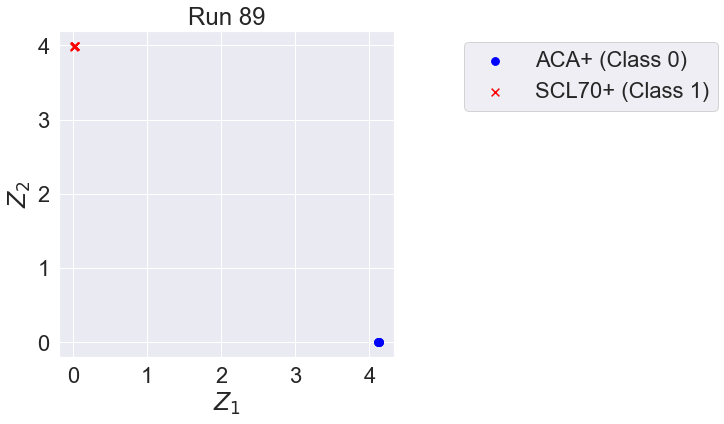

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 21
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 11

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.4182413  0.34240115 0.30704907 0.30168697]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3024927  0.29526106 0.2598081  0.25664568]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.29454315 -0.25543678 -0.25375697 -0.23835272]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.34405074 -0.30344942 -0.29459924 -0.28249332]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2289 and ending loss of 0.0779, on epoch 999.
Run 90 now finished, with starting loss of 2.2289 and ending loss of 0.0779, on epoch 999.
Total elapsed time: 1.2 sec.


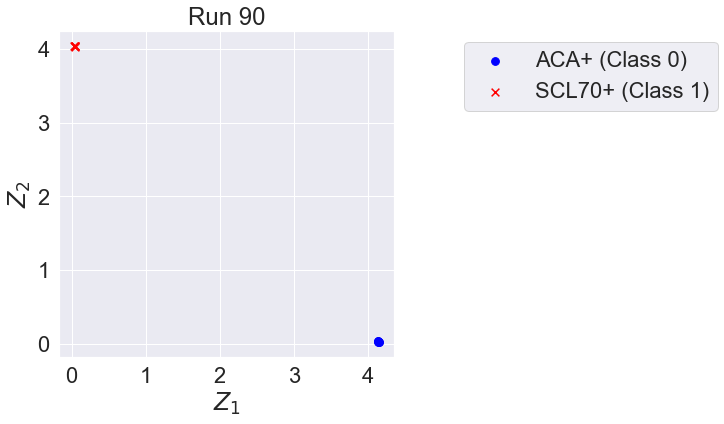

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 14
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 22
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 10

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3511857  0.3374893  0.33026165 0.30792361]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3144585  0.29140958 0.27360466 0.26651654]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.28009608 -0.27891645 -0.27513957 -0.25557178]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.30620635 -0.29532635 -0.28144547 -0.2687566 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2510 and ending loss of 0.0796, on epoch 999.
Run 91 now finished, with starting loss of 2.2510 and ending loss of 0.0796, on epoch 999.
Total elapsed time: 1.1 sec.


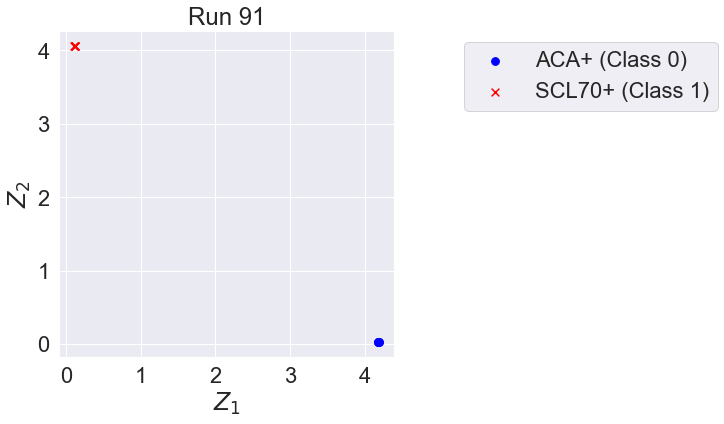

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 13
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 19
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 19
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 13

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.33157665 0.32548913 0.32149664 0.31322393]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.33971816 0.33053327 0.32070634 0.31236532]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.29502448 -0.2692908  -0.25632507 -0.24900478]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.2723566  -0.2230114  -0.20672794 -0.19252332]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2361 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2416 and ending loss of 1.6218, on epoch 400.
Starting loss of 2.2399 and ending loss of 0.0798, on epoch 999.
Run 92 now finished, with starting loss of

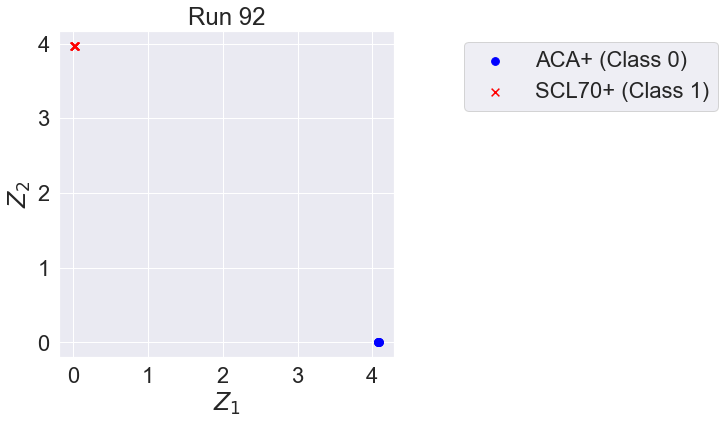

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 14
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 13
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 19

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.36452258 0.3235829  0.32248595 0.31620923]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.37403205 0.27866963 0.25717524 0.228611  ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.26360318 -0.24763232 -0.18956524 -0.1758201 ]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.30919832 -0.3040113  -0.2878447  -0.2676145 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2361 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2705 and ending loss of 0.0812, on epoch 999.
Run 93 now finished, with starting loss of 2.2705 and ending loss of 0.0812, on epoch 999.
Total elapsed ti

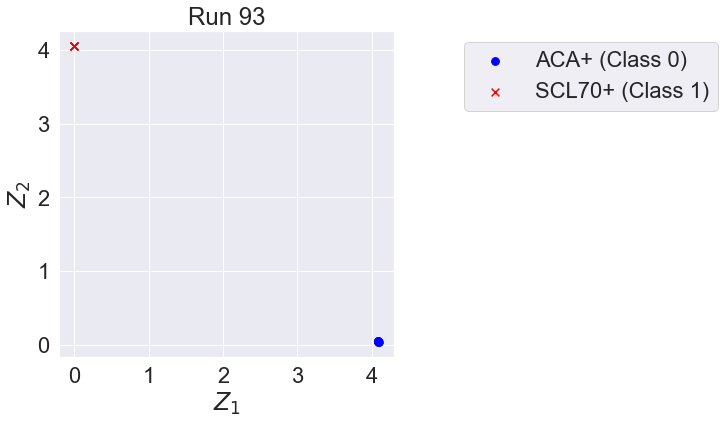

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 23
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 9
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 9
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 23

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.39216152 0.34961757 0.339012   0.3242455 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3621982  0.3611053  0.31872582 0.24781933]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.1664209  -0.16605425 -0.16514812 -0.07898582]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.34722105 -0.33657178 -0.32833618 -0.31148416]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2793 and ending loss of 0.0789, on epoch 999.
Run 94 now finished, with starting loss of 2.2793 and ending loss of 0.0789, on epoch 999.
Total elapsed time: 1.1 sec.


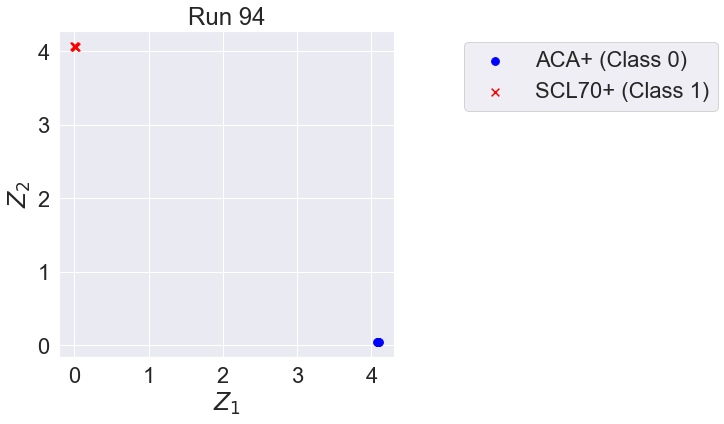

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 15

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3911281  0.350813   0.33602554 0.32084483]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.3663938  0.2994526  0.29232475 0.2693092 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.28650287 -0.28290442 -0.24721639 -0.17807907]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.32808393 -0.26883548 -0.26145935 -0.2548066 ]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2401 and ending loss of 0.0799, on epoch 999.
Run 95 now finished, with starting loss of 2.2401 and ending loss of 0.0799, on epoch 999.
Total elapsed time: 1.1 sec.


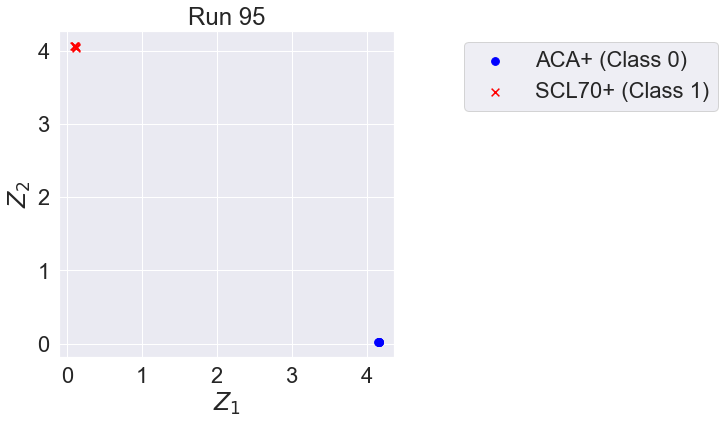

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 20
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 12

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3600742  0.3072383  0.3016737  0.28518668]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.36617014 0.32534018 0.30136895 0.2875349 ]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.3384736  -0.2691538  -0.2133481  -0.20941053]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.3265284  -0.30770358 -0.23303775 -0.22471298]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2434 and ending loss of 1.6354, on epoch 400.
Starting loss of 2.2493 and ending loss of 0.0798, on epoch 999.
Run 96 now finished, with starting loss of 2.2493 and ending loss of 0.0798, on epoch 999.
Total elapsed ti

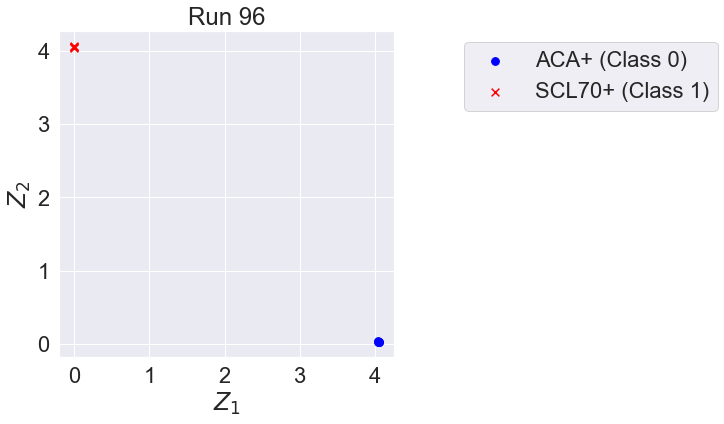

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 14
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 14
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 18

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.3310544  0.3100065  0.29958868 0.28197324]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.36956918 0.34297448 0.32796878 0.31821287]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.29860714 -0.26072866 -0.24427752 -0.20828947]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.30625585 -0.2664363  -0.253837   -0.23610903]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2473 and ending loss of 2.2361, on epoch 400.
Starting loss of 2.2317 and ending loss of 0.0780, on epoch 999.
Run 97 now finished, with starting loss of 2.2317 and ending loss of 0.0780, on epoch 999.
Total elapsed ti

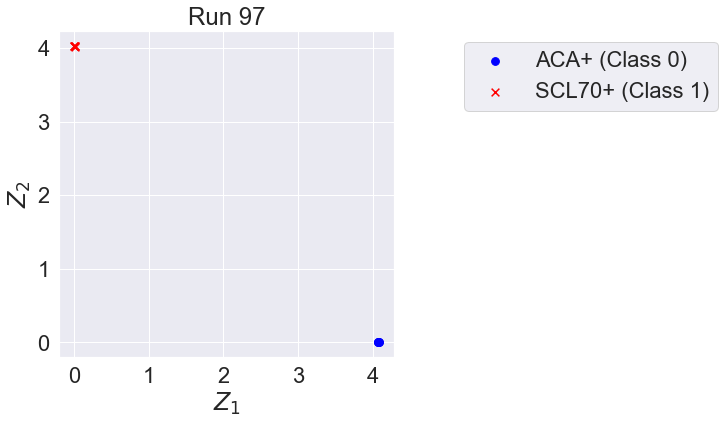

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 16
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 16
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 20
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 12

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.351862   0.34755537 0.33511773 0.29845223]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.37428498 0.3573384  0.29419816 0.29097754]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.29139704 -0.2700176  -0.25362948 -0.24964428]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.28181607 -0.27310216 -0.24653988 -0.18373634]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2353 and ending loss of 1.6287, on epoch 400.
Starting loss of 2.2285 and ending loss of 1.6251, on epoch 400.
Starting loss of 2.2527 and ending loss of 1.6373, on epoch 400.
Starting loss of 2.2585 and ending loss of

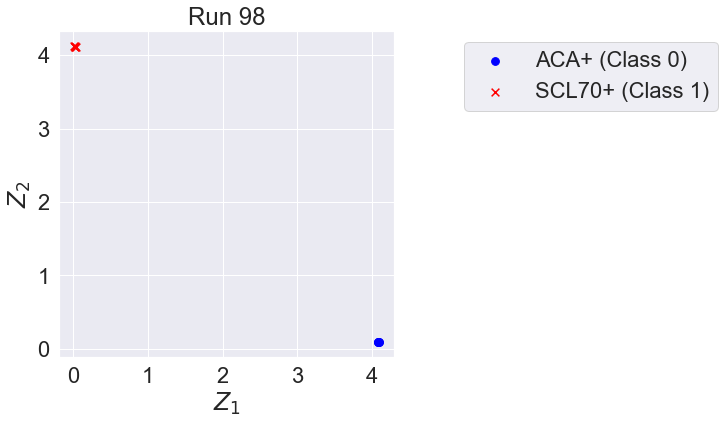

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 17
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 15
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 17

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.33972797 0.31081662 0.3081887  0.3072724 ]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.35932302 0.3524816  0.321146   0.31909773]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.32700634 -0.20839073 -0.19104517 -0.16640952]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.27796686 -0.27573296 -0.2500507  -0.24930482]

---------------------------------------------------------------------------------------------------------
Starting loss of 2.2442 and ending loss of 0.0785, on epoch 999.
Run 99 now finished, with starting loss of 2.2442 and ending loss of 0.0785, on epoch 999.
Total elapsed time: 1.2 sec.


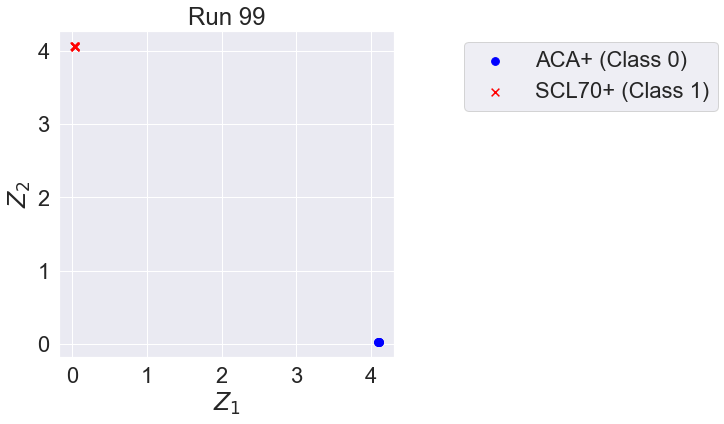

Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: 14
Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: 18
Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: 14

Hidden Layer 2 -- Class 0 Most Positive Weights: [0.32552406 0.30864114 0.30679026 0.28730363]

Hidden Layer 2 -- Class 1 Most Positive Weights: [0.45137277 0.39685673 0.33882368 0.32094505]

Hidden Layer 2 -- Class 0 Most Negative Weights: [-0.30398798 -0.2948596  -0.27214897 -0.25997448]

Hidden Layer 2 -- Class 1 Most Negative Weights: [-0.2995325  -0.2588912  -0.23743962 -0.20226121]

---------------------------------------------------------------------------------------------------------


In [38]:
X = X_scaled
y = y_labels

lamb = 1E-1 # Center loss lambda value

num_neurons_array = np.array([32])
m = num_neurons_array.shape[0] + 1

num_epoch = 1000

num_experiments = 100
d = X.shape[1]

X_train_all = X
y_train_all = y

X_ANN_train = torch.tensor(X_train_all.astype('float32'))

C = np.unique(y_train_all).shape[0] # Number of classes

y_ANN_train = np.eye(C)[y_train_all.astype(int)] # Convert categorical to one-hot-encoding
y_ANN_train = torch.tensor(y_ANN_train.astype('float32'))

## Network loss function w.r.t. parameters:
# Define loss w.r.t. parameters:
def weight_loss_criterion(model,input,target):
    # Grab parameters
    p_dict = {}
    ii = 0
    for p in model.parameters():
        p_dict[ii] = p
        ii += 1

    # Grab parameter norms
    n_params = len(p_dict)
    NN = input.shape[0]

    # Forward prop:
    ZL = {}
    ZL[0] = input
    for ii in range(1,m+1):
        this_W = p_dict[2*ii-2].T
        this_b = p_dict[2*ii-1].reshape(-1,1).T
        ones_matrix = torch.ones((NN,1))
        ZL[ii] = relu( torch.mm(ZL[ii-1],this_W) + torch.mm(ones_matrix,this_b) )
        
    # Backprop:
    temp_softmax = torch.nn.Softmax(dim=1)
    Z_Class_0 = ZL[m][y_train_all==0]
    Z_Class_1 = ZL[m][y_train_all==1]
    
    Z_Center_0 = torch.mean(ZL[m][y_train_all==0],axis=0)
    Z_Center_1 = torch.mean(ZL[m][y_train_all==1],axis=0)
    
    Center_loss = lamb*0.5*( torch.norm((Z_Class_0 - Z_Center_0),2) + torch.norm((Z_Class_1 - Z_Center_1),2) )
    
    loss = torch.norm( ( target - temp_softmax(ZL[m]) ) , 2 ) + Center_loss
    
    return loss, ZL, p_dict

top_Class0_Positive_dict = {}
top_Class0_Negative_dict = {}
top_Class1_Positive_dict = {}
top_Class1_Negative_dict = {}

W_Class0_Positive_dict = {}
W_Class0_Negative_dict = {}
W_Class1_Positive_dict = {}
W_Class1_Negative_dict = {}

### START OF RUNS ###
for run_num in range(0,num_experiments):
    
    p_array = [] # Parameters
    Z_array = [] # Hidden layer values
    loss_array = [] # Total loss

    last_epoch_loss = 1
    time_start = time.time()
    while last_epoch_loss > 0.1:

        ## Initialize Neural Network Architecture
        model = torch.nn.Sequential(
        torch.nn.Linear(d,num_neurons_array[0], bias=True),
        torch.nn.ReLU(),
        torch.nn.Linear(num_neurons_array[0],C, bias=True),
        torch.nn.ReLU(),
        torch.nn.Softmax(dim=1)
        )

        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay = 0.1)
        loss_list = []

        for epoch in range(0,num_epoch):

            input = Variable(X_ANN_train)
            target = Variable(y_ANN_train)

            # Forward prop
            out = model(input)
            loss, ZL, p_dict = weight_loss_criterion(model,input,target)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch == 0:
                first_epoch_loss = loss.data.item()

            this_loss = loss.data.item()
            loss_list.append(loss.data.item())

            ## Early-stopping criteria 
            earliest_stopping_epoch = 400

            if epoch >= earliest_stopping_epoch and loss.data.item() > 1:
                break
    #         early_stopping_num_epochs = 20
    #         early_stopping_thresh = 1E-3

    #         if epoch >= (earliest_stopping_epoch):
    #             loss_differences = []

    #             for jjj in range(epoch-early_stopping_num_epochs , epoch):
    #                 loss_differences.append(np.abs(loss_list[jjj]-loss_list[jjj+1]))

    #             if np.mean(loss_differences) < early_stopping_thresh:
    #                 break

        last_epoch_loss = loss.data.item()
        print("Starting loss of {:.4f} and ending loss of {:.4f}, on epoch {}.".format(first_epoch_loss,last_epoch_loss,epoch))

    print("Run {} now finished, with starting loss of {:.4f} and ending loss of {:.4f}, on epoch {}.".format(run_num,first_epoch_loss,last_epoch_loss,epoch))
    time_end = time.time()
    print("Total elapsed time: {:.1f} sec.".format(time_end-time_start))

    Z_array.append(ZL) # Hidden layer values
    p_array.append(p_dict)

    X_train_all_this = X_train_all

    #### LATENT SPACE PLOTS ####
    N_train = N

    ### Grab optimal DL model parameters
    ## Hidden Layer 1: k_1 = 100
    W_1 = p_array[0][0].detach().numpy().T
    b_1 = p_array[0][1].detach().numpy()

    ## Hidden Layer 2 (Pre-Softmax): k_2 = C = 2
    W_2 = p_array[0][2].detach().numpy().T
    b_2 = p_array[0][3].detach().numpy()

    ### Calculate all sample values in Hidden Layers 1 and 2:
    B_1_train = np.ones((N_train,num_neurons_array[0]))
    B_2_train = np.ones((N_train,C))

    for i in range(0,N_train):
        B_1_train[i,:] = b_1.reshape(1,-1)
        B_2_train[i,:] = b_2.reshape(1,-1)

    ## Training samples
    Z_train_HL1 = np.matmul(X_train_all_this,W_1) + B_1_train
    Z_train_HL1 = relu(torch.tensor(Z_train_HL1.astype('float32'))).detach().numpy()

    Z_train_HL2 = np.matmul(Z_train_HL1,W_2) + B_2_train
    Z_train_HL2 = relu(torch.tensor(Z_train_HL2.astype('float32'))).detach().numpy()

    Z_train_HL2_0 = Z_train_HL2[y_train_all==0] # Class 0, ACA+
    Z_train_HL2_1 = Z_train_HL2[y_train_all==1] # Class 1, SCL70+

    ## Latent Space Plots
    dim_1 = 0
    dim_2 = 1

    %matplotlib inline

    plt.figure(figsize=(6,6))
    plt.title("Run {}".format(run_num))
    plt.scatter(Z_train_HL2_0[:,dim_1], Z_train_HL2_0[:,dim_2], marker='o', s=60, color='blue', label = "ACA+ (Class 0)")
    plt.scatter(Z_train_HL2_1[:,dim_1], Z_train_HL2_1[:,dim_2], marker='x', s=60, color='red', label = "SCL70+ (Class 1)")
    plt.xlabel("$Z_1$")
    plt.ylabel("$Z_2$")

    plt.legend(bbox_to_anchor=(2,1))
    plt.show()

    #### FEATURE EXTRACTION (ENSEMBLE APPROACH) ####
    #### Second hidden layer weight traceback
    W_HL2 = p_array[0][2].T.detach().numpy()
    W_HL2_0 = W_HL2[:,0]
    W_HL2_1 = W_HL2[:,1]

    print("Hidden Layer 2 -- Class 0 -- Total number of Positive Weights: {}".format(np.sum(W_HL2_0 > 0)))
    print("Hidden Layer 2 -- Class 0 -- Total number of Negative Weights: {}".format(np.sum(W_HL2_0 < 0)))
    print("Hidden Layer 2 -- Class 1 -- Total number of Positive Weights: {}".format(np.sum(W_HL2_1 > 0)))
    print("Hidden Layer 2 -- Class 1 -- Total number of Negative Weights: {}".format(np.sum(W_HL2_1 < 0)))
    print("")

    m_top_HL2 = 4 # Number of top weights to consider during traceback

    ## Find most positively-correlated weights
    # Z_0 - Pertaining to Class 0
    top_HL2_Class0_Positive = (-W_HL2_0).argsort()[0:m_top_HL2]
    print("Hidden Layer 2 -- Class 0 Most Positive Weights: {}".format(W_HL2_0[top_HL2_Class0_Positive]))
    print("")

    # Z_1 - Pertaining to Class 1
    top_HL2_Class1_Positive = (-W_HL2_1).argsort()[0:m_top_HL2]
    print("Hidden Layer 2 -- Class 1 Most Positive Weights: {}".format(W_HL2_1[top_HL2_Class1_Positive]))
    print("")

    ## Find most negatively-correlated weights
    # Z_0 - Pertaining to Class 0
    top_HL2_Class0_Negative = (W_HL2_0).argsort()[0:m_top_HL2]
    print("Hidden Layer 2 -- Class 0 Most Negative Weights: {}".format(W_HL2_0[top_HL2_Class0_Negative]))
    print("")

    # Z_1 - Pertaining to Class 1
    top_HL2_Class1_Negative = (W_HL2_1).argsort()[0:m_top_HL2]
    print("Hidden Layer 2 -- Class 1 Most Negative Weights: {}".format(W_HL2_1[top_HL2_Class1_Negative]))
    print("")
    print("---------------------------------------------------------------------------------------------------------")

    #### First hidden layer weight traceback
    W_HL1 = p_array[0][0].T.detach().numpy()
    m_top_HL1 = 10 # Number of top weights to consider during traceback

    # Weights most positively-correlated to Class 0
    top_Class0_Positive_pospos = (-W_HL1[:,top_HL2_Class0_Positive]).argsort(axis=0)[0:m_top_HL1]
    top_Class0_Positive_negneg = (W_HL1[:,top_HL2_Class0_Negative]).argsort(axis=0)[0:m_top_HL1]
    top_Class0_Positive = np.concatenate((top_Class0_Positive_pospos,top_Class0_Positive_negneg),axis=1)

    # Weights most positively-correlated to Class 1
    top_Class1_Positive_pospos = (-W_HL1[:,top_HL2_Class1_Positive]).argsort(axis=0)[0:m_top_HL1]
    top_Class1_Positive_negneg = (W_HL1[:,top_HL2_Class1_Negative]).argsort(axis=0)[0:m_top_HL1]
    top_Class1_Positive = np.concatenate((top_Class1_Positive_pospos,top_Class1_Positive_negneg),axis=1)

    # Weights most negatively-correlated to Class 0
    top_Class0_Negative_posneg = (-W_HL1[:,top_HL2_Class0_Negative]).argsort(axis=0)[0:m_top_HL1]
    top_Class0_Negative_negpos = (W_HL1[:,top_HL2_Class0_Positive]).argsort(axis=0)[0:m_top_HL1]
    top_Class0_Negative = np.concatenate((top_Class0_Negative_posneg,top_Class0_Negative_negpos),axis=1)

    # Weights most negatively-correlated to Class 1
    top_Class1_Negative_posneg = (-W_HL1[:,top_HL2_Class1_Negative]).argsort(axis=0)[0:m_top_HL1]
    top_Class1_Negative_negpos = (W_HL1[:,top_HL2_Class1_Positive]).argsort(axis=0)[0:m_top_HL1]
    top_Class1_Negative = np.concatenate((top_Class1_Negative_posneg,top_Class1_Negative_negpos),axis=1)

    # Compile results
    W_Class0_Positive = np.zeros((m_top_HL1,m_top_HL2*2))
    W_Class1_Positive = np.zeros((m_top_HL1,m_top_HL2*2))
    W_Class0_Negative = np.zeros((m_top_HL1,m_top_HL2*2))
    W_Class1_Negative = np.zeros((m_top_HL1,m_top_HL2*2))

    for j in range(0,m_top_HL2):
        W_Class0_Positive[:,j] = W_HL1[:,top_HL2_Class0_Positive][:,j][top_Class0_Positive_pospos[:,j]]
        W_Class0_Positive[:,j+m_top_HL2] = W_HL1[:,top_HL2_Class0_Negative][:,j][top_Class0_Positive_negneg[:,j]]

        W_Class1_Positive[:,j] = W_HL1[:,top_HL2_Class1_Positive][:,j][top_Class1_Positive_pospos[:,j]]
        W_Class1_Positive[:,j+m_top_HL2] = W_HL1[:,top_HL2_Class1_Negative][:,j][top_Class1_Positive_negneg[:,j]]

        W_Class0_Negative[:,j] = W_HL1[:,top_HL2_Class0_Negative][:,j][top_Class0_Negative_posneg[:,j]]
        W_Class0_Negative[:,j+m_top_HL2] = W_HL1[:,top_HL2_Class0_Positive][:,j][top_Class0_Negative_negpos[:,j]]

        W_Class1_Negative[:,j] = W_HL1[:,top_HL2_Class1_Negative][:,j][top_Class1_Negative_posneg[:,j]]
        W_Class1_Negative[:,j+m_top_HL2] = W_HL1[:,top_HL2_Class1_Positive][:,j][top_Class1_Negative_negpos[:,j]]

    top_Class0_Positive_dict[run_num] = top_Class0_Positive
    top_Class0_Negative_dict[run_num] = top_Class0_Negative
    top_Class1_Positive_dict[run_num] = top_Class1_Positive
    top_Class1_Negative_dict[run_num] = top_Class1_Negative

    W_Class0_Positive_dict[run_num] = W_Class0_Positive
    W_Class0_Negative_dict[run_num] = W_Class0_Negative
    W_Class1_Positive_dict[run_num] = W_Class1_Positive
    W_Class1_Negative_dict[run_num] = W_Class1_Negative

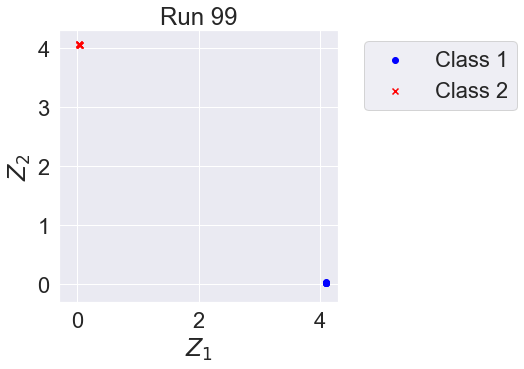

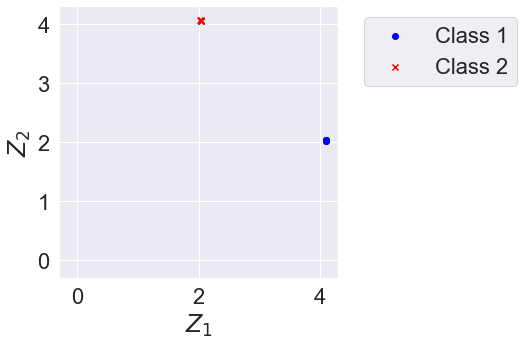

In [39]:
%matplotlib inline

plt.figure(figsize=(5,5))
plt.title("Run {}".format(run_num))
plt.scatter(Z_train_HL2_0[:,dim_1], Z_train_HL2_0[:,dim_2], marker='o', color='blue', label = "Class 1")
plt.scatter(Z_train_HL2_1[:,dim_1], Z_train_HL2_1[:,dim_2], marker='x', color='red', label = "Class 2")
plt.xlabel("$Z_1$")
plt.ylabel("$Z_2$")
plt.xlim([-0.3,4.3])
plt.ylim([-0.3,4.3])

plt.legend(bbox_to_anchor=(1.68,1))
plt.show()

plt.figure(figsize=(5,5))
#plt.title("Run {}".format(run_num))
plt.scatter(Z_train_HL2_0[:,dim_1], Z_train_HL2_0[:,dim_2]+2, marker='o', color='blue', label = "Class 1")
plt.scatter(Z_train_HL2_1[:,dim_1]+2, Z_train_HL2_1[:,dim_2], marker='x', color='red', label = "Class 2")
plt.xlim([-0.3,4.3])
plt.ylim([-0.3,4.3])
plt.xlabel("$Z_1$")
plt.ylabel("$Z_2$")

plt.legend(bbox_to_anchor=(1.68,1))
plt.show()

### Effect of center-binding weight $\alpha$

### Feature Extraction using the Optimal, Discriminative-Center-Loss ANN

We see that the **SCL70+** patients can primarily characterized by latent dimension $Z_1$. Similarly, the **ACA+** patients can be primarily characterized using latent dimension $Z_0$. Therefore, we backtrack $Z_0$ and $Z_1$ (by back-tracing their respective weight matrices) to find out what raw protein combinations they are made of.

**Input Layer** to **Hidden Layer 1:** $ Z^{[1]} = A^{[1]}(XW^{[1]}+B^{[1]}) $

**Hidden Layer 1** to **Hidden Layer 2:** $ Z^{[2]} = A^{[2]}(Z^{[1]}W^{[2]}+B^{[2]}) $

**Input Layer** to **Hidden Layer 2:** $ Z^{[2]} = A^{[2]}\big(A^{[1]}(XW^{[1]}+B^{[1]})W^{[2]}+B^{[2]}\big) $

In [42]:
RF_biomarkers_MDG = protein_IDs[unique_indices]
RF_biomarkers_MDG_plot = []
for s in RF_biomarkers_MDG:
    start = s.find("|") + len("|")
    end = s.find("_")
    RF_biomarkers_MDG_plot.append(s[start:end])

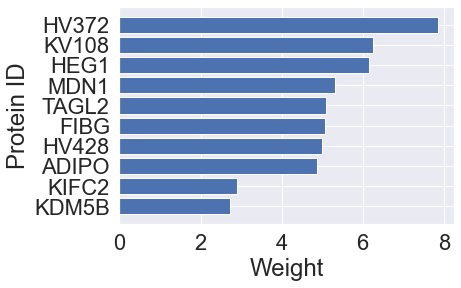

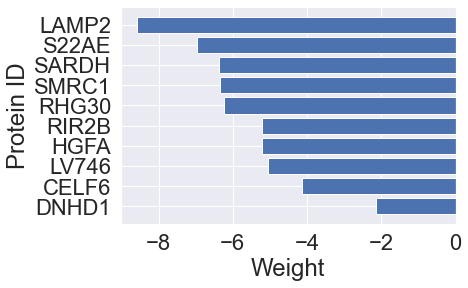

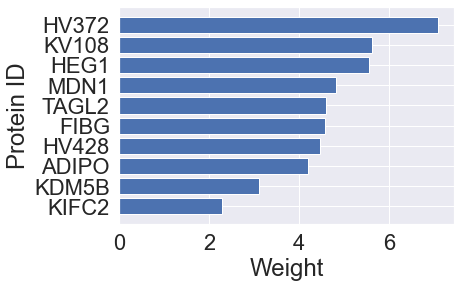

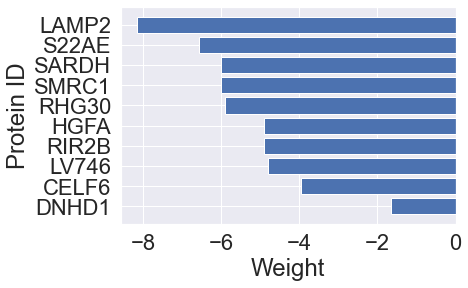

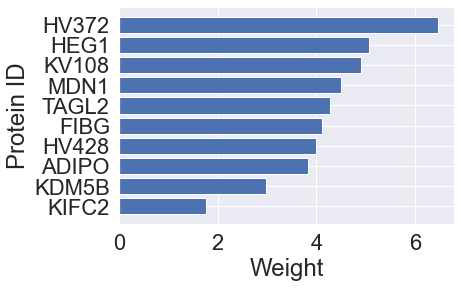

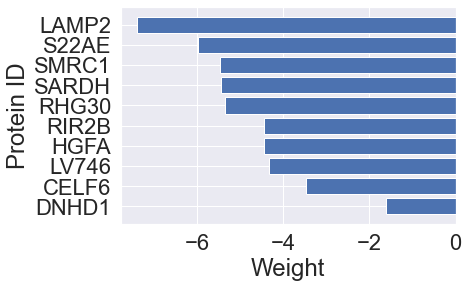

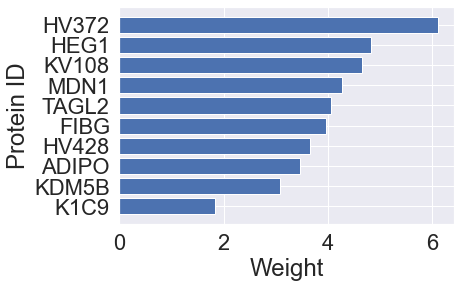

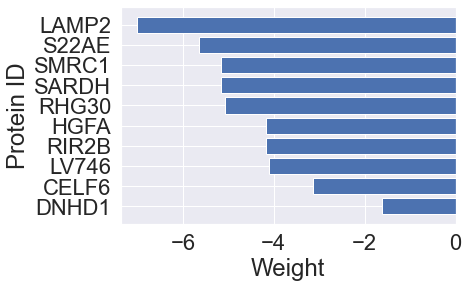

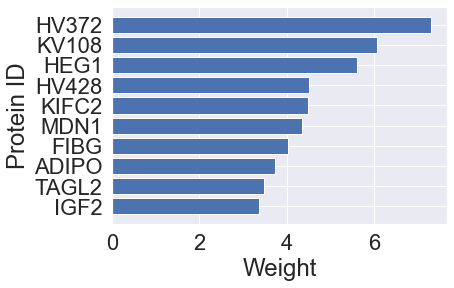

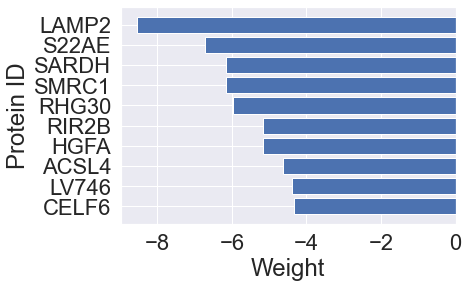

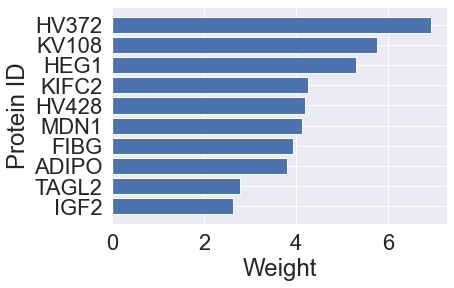

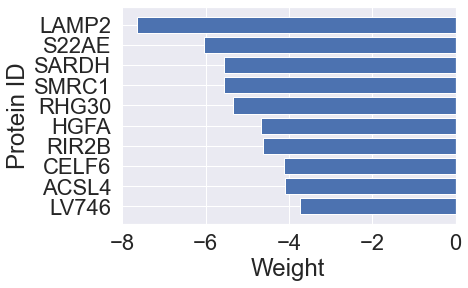

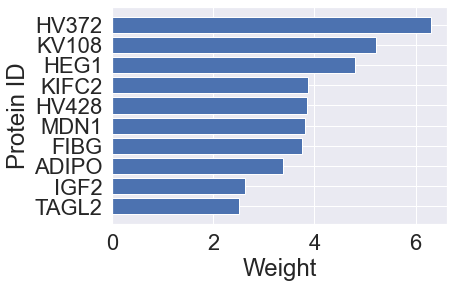

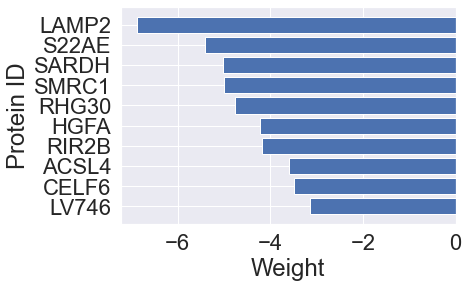

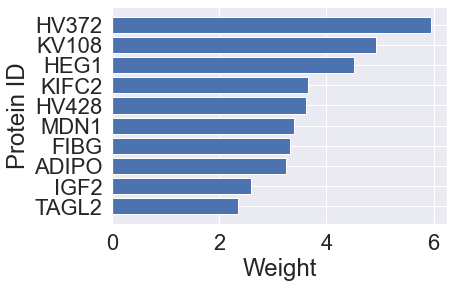

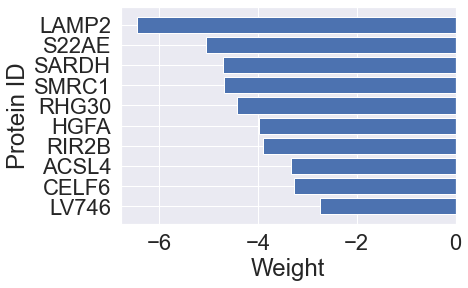

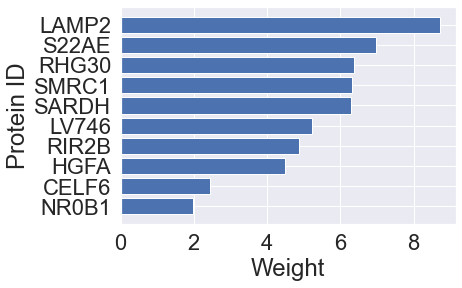

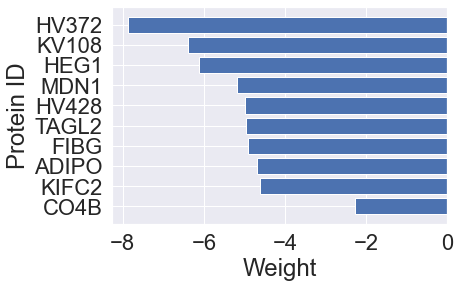

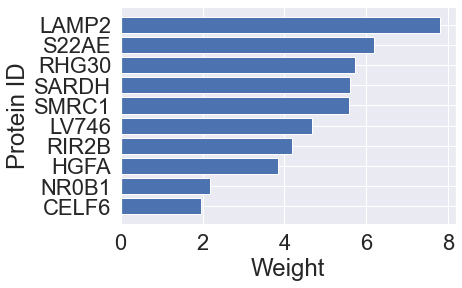

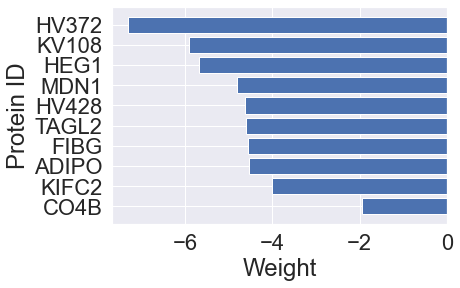

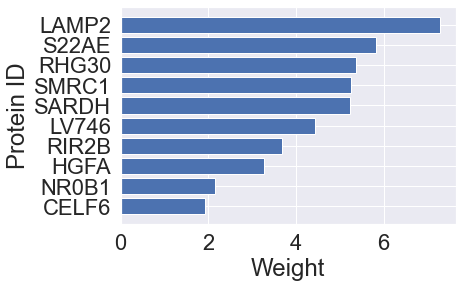

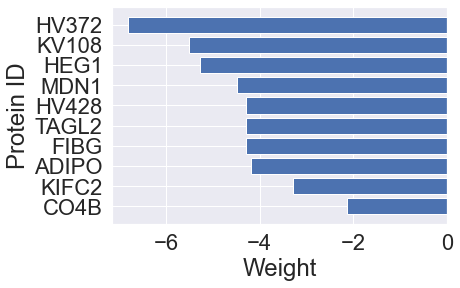

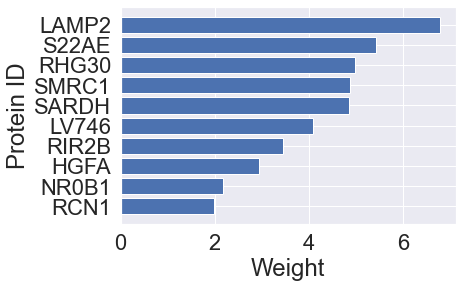

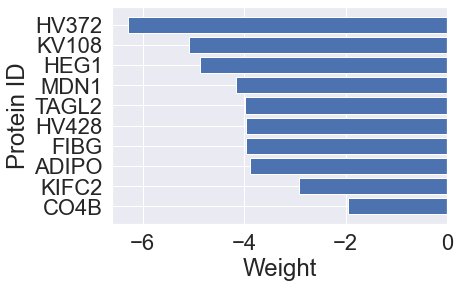

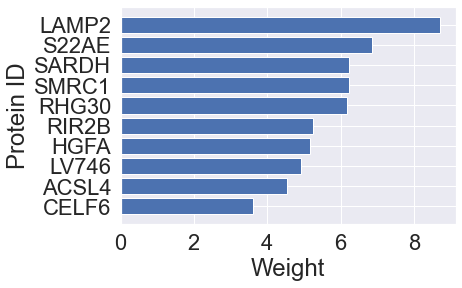

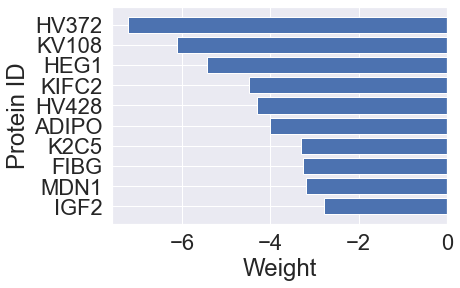

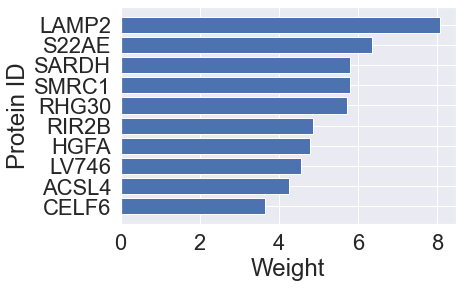

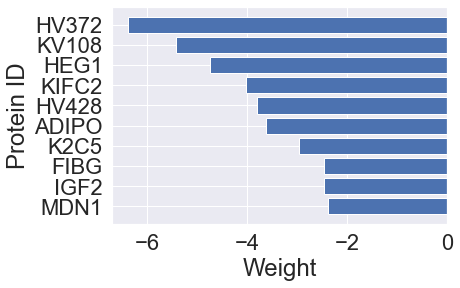

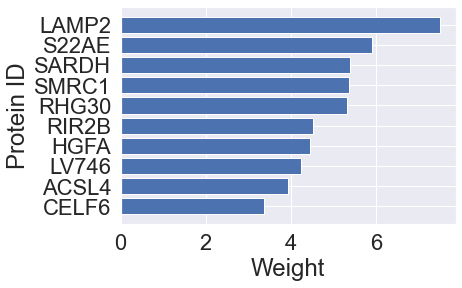

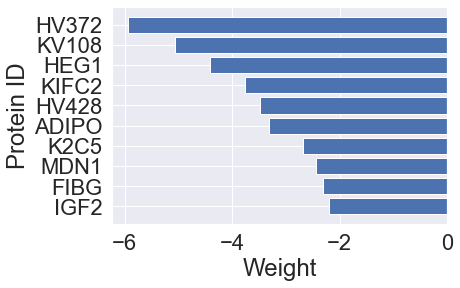

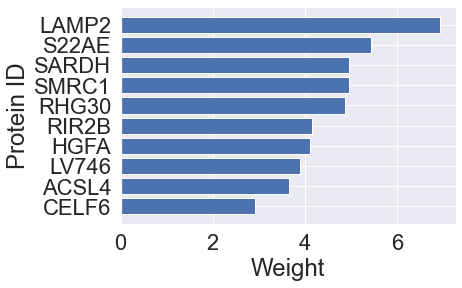

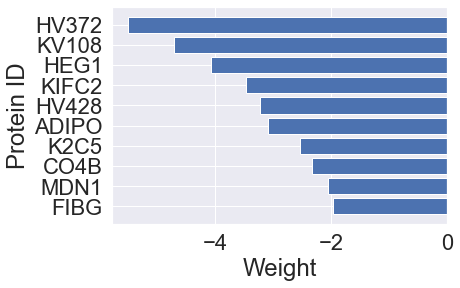

In [43]:
#### Consolidate results ####
def ensemblefy_DLFE(indices_dict,importances_dict,m_top_HL1,m_top_HL2):

    final_DLFE_importances = np.zeros((m_top_HL1,2*m_top_HL2))
    final_DLFE_indices = np.zeros((m_top_HL1,2*m_top_HL2))

    for j in range(0,2*m_top_HL2):
        these_DLFE_importances = []
        these_DLFE_indices = []

        for i in range(0,num_experiments):
            these_DLFE_indices.append(indices_dict[i][:,j])
            these_DLFE_importances.append(importances_dict[i][:,j])

        these_DLFE_importances = np.abs(np.array(these_DLFE_importances))
        these_DLFE_indices = np.array(these_DLFE_indices)

        unique_DLFE_indices = np.unique(these_DLFE_indices)
        unique_DLFE_importances = np.zeros((unique_DLFE_indices.shape[0],))

        for ii in range(0,unique_DLFE_indices.shape[0]):
            unique_DLFE_importances[ii] = np.sum(these_DLFE_importances[these_DLFE_indices == unique_DLFE_indices[ii]])

        final_DLFE_importances[:,j] = -np.sort(-unique_DLFE_importances)[0:m_top_HL1]
        eee = unique_DLFE_indices[np.argsort(-unique_DLFE_importances)[0:m_top_HL1]]
        final_DLFE_indices[:,j] = eee.astype(int)

    return final_DLFE_indices, final_DLFE_importances

## Class 0 Positively-correlated
[Class0_Positive_Final_Indices, Class0_Positive_Final_Importances] = ensemblefy_DLFE(top_Class0_Positive_dict,W_Class0_Positive_dict,m_top_HL1,m_top_HL2)
Class0_Positive_Final_Importances = np.abs(Class0_Positive_Final_Importances)
Class0_Positive_Final_Indices = Class0_Positive_Final_Indices.astype(int)

## Class 0 Negative-correlated
[Class0_Negative_Final_Indices, Class0_Negative_Final_Importances] = ensemblefy_DLFE(top_Class0_Negative_dict,W_Class0_Negative_dict,m_top_HL1,m_top_HL2)
Class0_Negative_Final_Importances = -np.abs(Class0_Negative_Final_Importances)
Class0_Negative_Final_Indices = Class0_Negative_Final_Indices.astype(int)

## Class 1 Positively-correlated
[Class1_Positive_Final_Indices, Class1_Positive_Final_Importances] = ensemblefy_DLFE(top_Class1_Positive_dict,W_Class1_Positive_dict,m_top_HL1,m_top_HL2)
Class1_Positive_Final_Importances = np.abs(Class1_Positive_Final_Importances)
Class1_Positive_Final_Indices = Class1_Positive_Final_Indices.astype(int)

## Class 1 Negative-correlated
[Class1_Negative_Final_Indices, Class1_Negative_Final_Importances] = ensemblefy_DLFE(top_Class1_Negative_dict,W_Class1_Negative_dict,m_top_HL1,m_top_HL2)
Class1_Negative_Final_Importances = -np.abs(Class1_Negative_Final_Importances)
Class1_Negative_Final_Indices = Class1_Negative_Final_Indices.astype(int)

### PLOT RESULTS ###
for j in range(0,2*m_top_HL2):
    plt.figure()
    y_ticks = np.arange(m_top_HL1,0,-1)
    
    these_proteins = protein_IDs[Class0_Positive_Final_Indices[:,j]]
    these_proteins_plot = []
    for s in these_proteins:
        start = s.find("|") + len("|")
        end = s.find("_")
        these_proteins_plot.append(s[start:end])
    
    #plt.title("Class 0 -- Positively-Correlated Biomarker Set {}".format(j),fontsize=22)
    plt.barh(y_ticks,Class0_Positive_Final_Importances[:,j])    
    plt.yticks(y_ticks,these_proteins_plot)
    plt.ylabel("Protein ID",fontsize=24)
    plt.xlabel("Weight",fontsize=24)
    
    plt.figure()
    y_ticks = np.arange(m_top_HL1,0,-1)
    
    these_proteins = protein_IDs[Class0_Negative_Final_Indices[:,j]]
    these_proteins_plot = []
    for s in these_proteins:
        start = s.find("|") + len("|")
        end = s.find("_")
        these_proteins_plot.append(s[start:end])
    
    #plt.title("Class 0 -- Negatively-Correlated Biomarker Set {}".format(j),fontsize=22)
    plt.barh(y_ticks,Class0_Negative_Final_Importances[:,j])
    plt.yticks(y_ticks,these_proteins_plot)
    plt.ylabel("Protein ID",fontsize=24)
    plt.xlabel("Weight",fontsize=24)

for j in range(0,2*m_top_HL2):
    plt.figure()
    y_ticks = np.arange(m_top_HL1,0,-1)
    
    these_proteins = protein_IDs[Class1_Positive_Final_Indices[:,j]]
    these_proteins_plot = []
    for s in these_proteins:
        start = s.find("|") + len("|")
        end = s.find("_")
        these_proteins_plot.append(s[start:end])
    
    #plt.title("Class 1 -- Positively-Correlated Biomarker Set {}".format(j),fontsize=22)
    plt.barh(y_ticks,Class1_Positive_Final_Importances[:,j])
    plt.yticks(y_ticks,these_proteins_plot)
    plt.ylabel("Protein ID",fontsize=24)
    plt.xlabel("Weight",fontsize=24)
    
    plt.figure()
    y_ticks = np.arange(m_top_HL1,0,-1)
    
    these_proteins = protein_IDs[Class1_Negative_Final_Indices[:,j]]
    these_proteins_plot = []
    for s in these_proteins:
        start = s.find("|") + len("|")
        end = s.find("_")
        these_proteins_plot.append(s[start:end])
    
    #plt.title("Class 1 -- Negatively-Correlated Biomarker Set {}".format(j),fontsize=22)
    plt.barh(y_ticks,Class1_Negative_Final_Importances[:,j])
    plt.yticks(y_ticks,these_proteins_plot)
    plt.ylabel("Protein ID",fontsize=24)
    plt.xlabel("Weight",fontsize=24)

In [44]:
W_Class0_Positive_dict

{0: array([[ 0.07960276,  0.0792573 ,  0.06881962,  0.06081892, -0.07156474,
         -0.06902602, -0.05984071, -0.04157944],
        [ 0.06473925,  0.06433   ,  0.05582641,  0.04775384, -0.05849098,
         -0.05766233, -0.04904775, -0.03460011],
        [ 0.06201929,  0.06122393,  0.05368449,  0.04749539, -0.0535025 ,
         -0.05120197, -0.04482969, -0.0320924 ],
        [ 0.05270912,  0.05149866,  0.04556605,  0.04219946, -0.0438978 ,
         -0.04263323, -0.03621279, -0.02582991],
        [ 0.05097912,  0.05028707,  0.04390502,  0.04002181, -0.04319297,
         -0.04128459, -0.03592394, -0.02540278],
        [ 0.05055687,  0.04965981,  0.04386058,  0.03945165, -0.04305359,
         -0.04097515, -0.03592218, -0.02528317],
        [ 0.05044637,  0.04952786,  0.04337734,  0.0388795 , -0.04233557,
         -0.04078795, -0.03551934, -0.02524591],
        [ 0.0489778 ,  0.04883141,  0.04215714,  0.03811167, -0.04195438,
         -0.04042194, -0.03501108, -0.02521369],
        [ 0.0

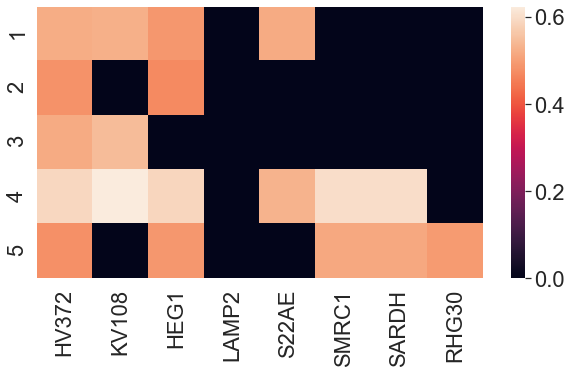

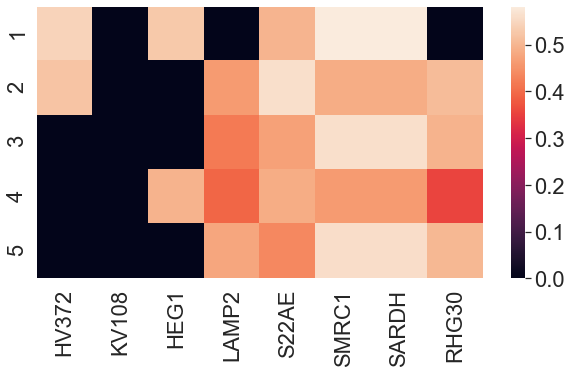

In [98]:
My_Class_0_Proteins = ['A0A0B4J1Y9|HV372_HUMAN',
                       'A0A0C4DH67|KV108_HUMAN',
                       'Q9ULI3|HEG1_HUMAN']

My_Class_1_Proteins = ['P13473|LAMP2_HUMAN',
                       'Q9Y267|S22AE_HUMAN',
                       'Q92922|SMRC1_HUMAN',
                       'Q9UL12|SARDH_HUMAN',
                       'Q7Z6I6|RHG30_HUMAN']

My_Proteins = My_Class_0_Proteins + My_Class_1_Proteins

My_Proteins_short = []
for s in My_Proteins:
    start = s.find("|") + len("|")
    end = s.find("_")
    My_Proteins_short.append(s[start:end])

My_Class_0_Protein_Indices = []
for j in My_Class_0_Proteins:
    My_Class_0_Protein_Indices.append(np.arange(0,d,1)[protein_IDs == j])

My_Class_0_Protein_Indices = np.array(My_Class_0_Protein_Indices).reshape(-1)

My_Class_1_Protein_Indices = []
for j in My_Class_1_Proteins:
    My_Class_1_Protein_Indices.append(np.arange(0,d,1)[protein_IDs == j])

My_Class_1_Protein_Indices = np.array(My_Class_1_Protein_Indices).reshape(-1)

X_Class_0 = X_scaled[y_labels == 0]
X_Class_1 = X_scaled[y_labels == 1]

X_Class_0_biomarkers_positive = X_Class_0[:,My_Class_0_Protein_Indices]
X_Class_0_biomarkers_negative = X_Class_0[:,My_Class_1_Protein_Indices]
X_Class_1_biomarkers_positive = X_Class_1[:,My_Class_1_Protein_Indices]
X_Class_1_biomarkers_negative = X_Class_1[:,My_Class_0_Protein_Indices]

X_Class_0_biomarkers = np.concatenate((X_Class_0_biomarkers_positive,X_Class_0_biomarkers_negative),axis=1)
X_Class_1_biomarkers = np.concatenate((X_Class_1_biomarkers_negative,X_Class_1_biomarkers_positive),axis=1)

plt.figure(figsize=(10,5))
sns.heatmap(X_Class_0_biomarkers,yticklabels=np.arange(1,6,1),xticklabels=My_Proteins_short)
plt.show()

plt.figure(figsize=(10,5))
sns.heatmap(X_Class_1_biomarkers,yticklabels=np.arange(1,6,1),xticklabels=My_Proteins_short)
plt.show()

In [90]:
np.arange(1,6,1)

array([1, 2, 3, 4, 5])

In [69]:
protein_IDs[My_Class_0_Protein_Indices]

array(['A0A0B4J1Y9|HV372_HUMAN', 'A0A0C4DH67|KV108_HUMAN',
       'Q9ULI3|HEG1_HUMAN'], dtype=object)

In [66]:
My_Class_0_Protein_Indices

array([197, 389, 183])

### 3.1 RF modelling on DLDCL latent features

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

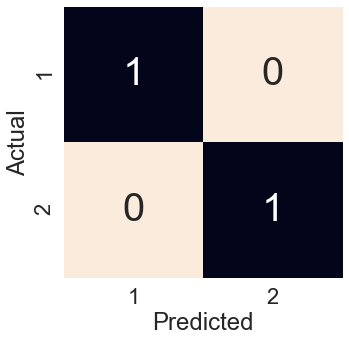

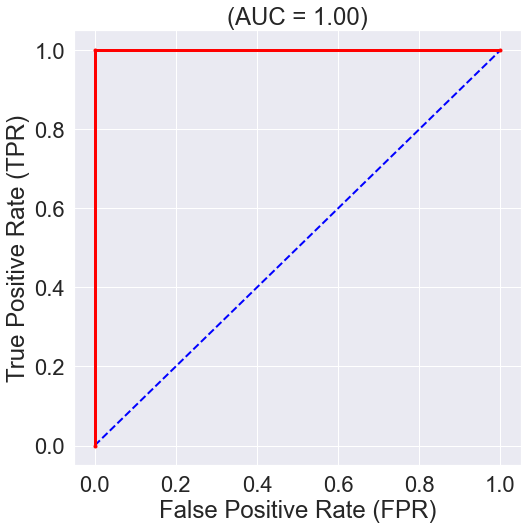

In [45]:
num_experiments = 100

conf_matrix_dict = {}
RF_train_acc_array = []
RF_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(Z_train_HL2,y,trainfrac)

    RF_model = RFC(random_state=0)
    RF_model.fit(X_train_all, y_train_all)

    y_train_hat = RF_model.predict(X_train_all)
    RF_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    RF_train_acc_array.append(RF_train_acc)

    y_test_hat = RF_model.predict(X_test_all)
    RF_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    RF_test_acc_array.append(RF_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)

    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(RF_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(RF_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(RF_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(RF_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(RF_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(RF_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_RF = np.zeros((C,C))
for i in range(0,conf_matrix_RF.shape[0]):
    conf_matrix_RF[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_RF = pd.DataFrame(conf_matrix_RF, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_RF, cbar=False, annot=True, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_RF[1,1]
FN = conf_matrix_RF[1,0]
FP = conf_matrix_RF[0,1]
TN = conf_matrix_RF[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='RF Model')
plt.title('(AUC = {:.2f})'.format(AUC))
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

### 3.2 SVM modelling on DLDCL latent features

Experiment 0 now complete.
Experiment 1 now complete.
Experiment 2 now complete.
Experiment 3 now complete.
Experiment 4 now complete.
Experiment 5 now complete.
Experiment 6 now complete.
Experiment 7 now complete.
Experiment 8 now complete.
Experiment 9 now complete.
Experiment 10 now complete.
Experiment 11 now complete.
Experiment 12 now complete.
Experiment 13 now complete.
Experiment 14 now complete.
Experiment 15 now complete.
Experiment 16 now complete.
Experiment 17 now complete.
Experiment 18 now complete.
Experiment 19 now complete.
Experiment 20 now complete.
Experiment 21 now complete.
Experiment 22 now complete.
Experiment 23 now complete.
Experiment 24 now complete.
Experiment 25 now complete.
Experiment 26 now complete.
Experiment 27 now complete.
Experiment 28 now complete.
Experiment 29 now complete.
Experiment 30 now complete.
Experiment 31 now complete.
Experiment 32 now complete.
Experiment 33 now complete.
Experiment 34 now complete.
Experiment 35 now complete.
Ex

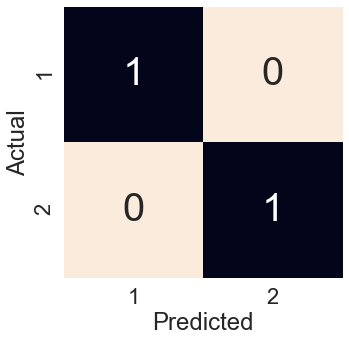

Text(0.5, 1.0, '(AUC = 1.00)')

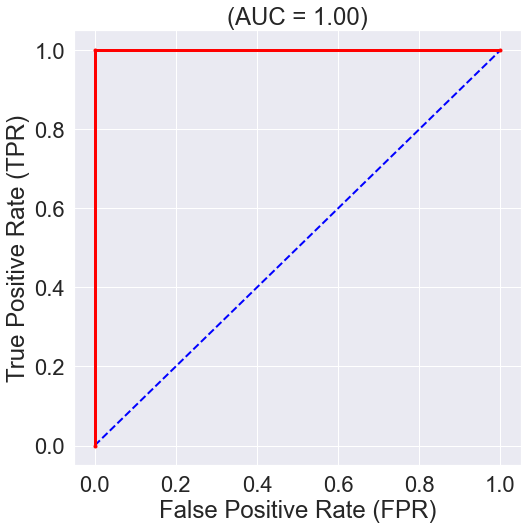

In [46]:
num_experiments = 100

conf_matrix_dict = {}
SVM_train_acc_array = []
SVM_test_acc_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(Z_train_HL2,y,trainfrac)
    
    SVM_model = svm.SVC(decision_function_shape='ovr',gamma='auto', random_state=0)
    SVM_model.fit(X_train_all, y_train_all)

    y_train_hat = SVM_model.predict(X_train_all)
    SVM_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    SVM_train_acc_array.append(SVM_train_acc)

    y_test_hat = SVM_model.predict(X_test_all)
    SVM_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    SVM_test_acc_array.append(SVM_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)
    print("Experiment {} now complete.".format(i))
    
print("Average training accuracy is {:.2f}%.".format(np.mean(SVM_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(SVM_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(SVM_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(SVM_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(SVM_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(SVM_test_acc_array)))

%matplotlib inline

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_SVM = np.zeros((C,C))
for i in range(0,conf_matrix_SVM.shape[0]):
    conf_matrix_SVM[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
plt.figure(figsize=(5,5))
df_cm_SVM = pd.DataFrame(conf_matrix_SVM, range(1,C+1), range(1,C+1))
sns.set(font_scale=2) 
sns.heatmap(df_cm_SVM, annot=True, cbar=False, annot_kws={"size": 40}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.xlabel("Predicted", fontsize=24)
plt.ylabel("Actual", fontsize=24)
plt.show()

%matplotlib inline

TP = conf_matrix_SVM[1,1]
FN = conf_matrix_SVM[1,0]
FP = conf_matrix_SVM[0,1]
TN = conf_matrix_SVM[0,0]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
AUC = 0.5*(1 + TPR - FPR)

## ROC Curves
plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], linestyle='--',linewidth=2, c='blue', label='No-Skill Classifier')
plt.plot([0, FPR, 1],[0, TPR, 1], marker='.', linewidth=3, c='red', label='SVM Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('(AUC = {:.2f})'.format(AUC))

## APPENDIX

In [ ]:
num_experiments = 100

conf_matrix_dict = {}
RF_train_acc_array = []
RF_test_acc_array = []
FPR_array = []
TPR_array = []
ROC_AUC_array = []

for i in range(0,num_experiments):

    trainfrac = 0.8
    [X_train_all, X_test_all, y_train_all, y_test_all, aaa, bbb] = traintestsplit_c(X_scaled,y_labels,trainfrac)

    RF_model = RFC(random_state=0)
    RF_model.fit(X_train_all, y_train_all)

    y_train_hat = RF_model.predict(X_train_all)
    RF_train_acc = np.sum(y_train_hat == y_train_all)/y_train_hat.shape[0]*100
    RF_train_acc_array.append(RF_train_acc)

    y_test_hat = RF_model.predict(X_test_all)
    RF_test_acc = np.sum(y_test_hat == y_test_all)/y_test_hat.shape[0]*100
    RF_test_acc_array.append(RF_test_acc)
    
    conf_matrix_dict[i] = confusion_matrix(y_test_all, y_test_hat)

    ## ROC curve calculations
    y_test_hat = RF_model.predict_proba(X_test_all)
    Class_1_probs = y_test_hat[:, 1]
    FPR, TPR, _ = roc_curve(y_test_all, Class_1_probs)
    ROC_AUC = roc_auc_score(y_test_all, Class_1_probs)
    ROC_AUC_array.append(ROC_AUC)
    
    ## Address the singular case where FPR vs TPR follows the No-Skill diagonal:
    if np.sum(FPR == [0,1]) == 2 or np.sum(TPR == [0,1]) == 2:
        FPR_array.append(np.array([0,0.5,1]))
        TPR_array.append(np.array([0,0.5,1]))
    else:
        FPR_array.append(FPR)
        TPR_array.append(TPR)
    
    print("Experiment {} now complete.".format(i))
    
FPR_array = np.array(FPR_array)
TPR_array = np.array(TPR_array)

In [ ]:
print("Average training accuracy is {:.2f}%.".format(np.mean(RF_train_acc_array)))
print("Maximum training accuracy is {:.2f}%.".format(np.max(RF_train_acc_array)))
print("Minimum training accuracy is {:.2f}%.".format(np.min(RF_train_acc_array)))
print("Average testing accuracy is {:.2f}%.".format(np.mean(RF_test_acc_array)))
print("Maximum testing accuracy is {:.2f}%.".format(np.max(RF_test_acc_array)))
print("Minimum testing accuracy is {:.2f}%.".format(np.min(RF_test_acc_array)))

%matplotlib notebook

conf_matrix_calc = conf_matrix_dict[0].copy()

for i in range(1,len(conf_matrix_dict)):
    conf_matrix_calc += conf_matrix_dict[i]

class_sums = np.sum(conf_matrix_calc,axis=1)

conf_matrix_RF = np.zeros((C,C))
for i in range(0,conf_matrix_RF.shape[0]):
    conf_matrix_RF[i,:] = conf_matrix_calc[i,:] / class_sums[i]
    
df_cm_RF = pd.DataFrame(conf_matrix_RF, range(C), range(C))
sns.set(font_scale=1.4) 
sns.heatmap(df_cm_RF, annot=True, annot_kws={"size": 16}, cmap=sns.cm.rocket_r,vmin=0, vmax=1) 

plt.title("Random Forests, All Original Proteins")
plt.show()

In [500]:
d

531